# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

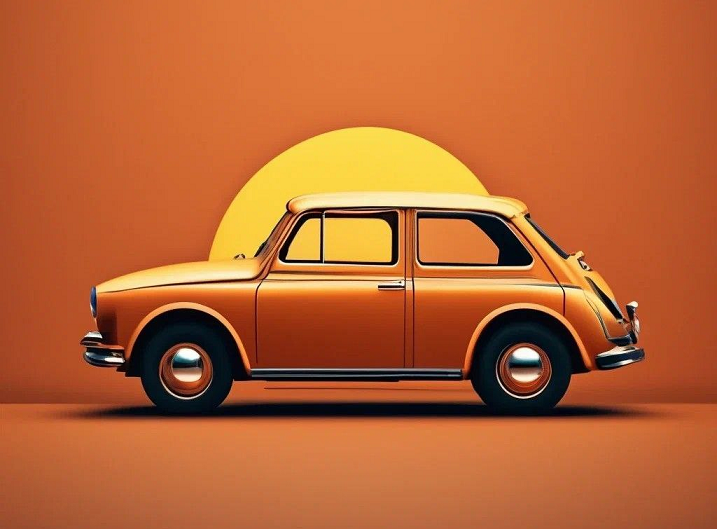

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DummyRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li><li><span><a href="#Результат" data-toc-modified-id="Результат-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Результат</a></span></li></ul></div>

## Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  
    
Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sb

from scipy import stats as st
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder 
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV

In [2]:
try:
    df = pd.read_csv('C://datasets/autos.csv')


except:
    df = pd.read_csv('/datasets/autos.csv')

display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
print('Доля пропусков, %')
round(df.isna().sum()/len(df)*100,2)


Доля пропусков, %


DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

- переименовываем все столбцы в нижний регистр с подчеркиванием и заодно удаляем бесполезный "NumberOfPictures", который  информации не содержит.


In [5]:
df = df.drop('NumberOfPictures', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [6]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
              'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'postal_code', 'last_seen']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [7]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

- После обработки данных необходимо повторить процедуру проверки на дубликаты.

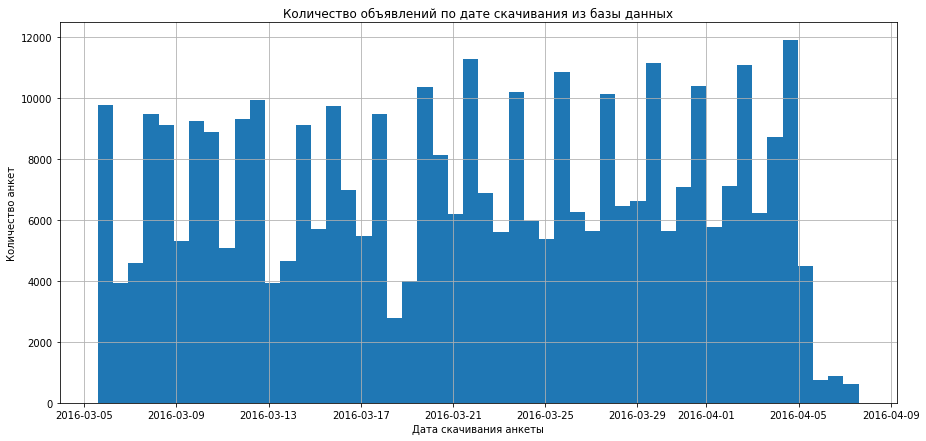

In [9]:
ax = df['date_crawled'].hist(bins = 50, figsize = (15,7))
ax.set_title('Количество объявлений по дате скачивания из базы данных')
ax.set_xlabel('Дата скачивания анкеты')
ax.set_ylabel('Количество анкет')
None

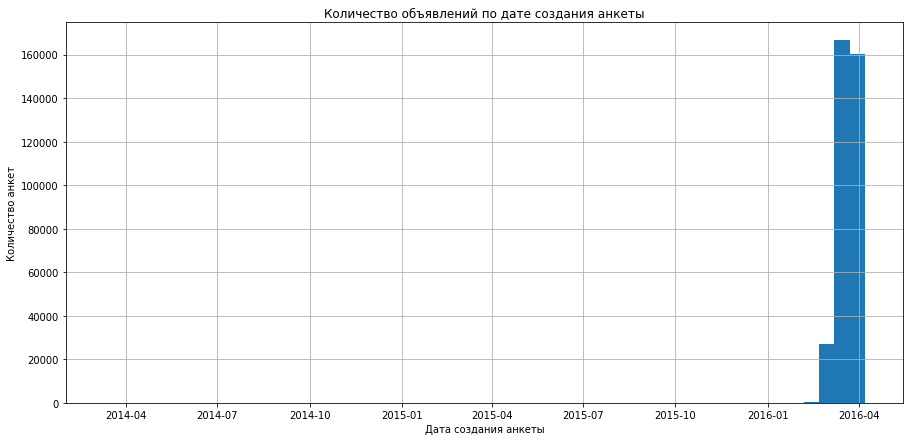

In [10]:
ax = df['date_created'].hist(bins = 50, figsize = (15,7))
ax.set_title('Количество объявлений по дате создания анкеты')
ax.set_xlabel('Дата создания анкеты')
ax.set_ylabel('Количество анкет')
None

In [11]:
df['date_created'].sort_values().head(20)

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
221002   2015-09-04
75598    2015-09-04
340616   2015-09-09
9972     2015-11-02
161567   2015-11-08
282938   2015-11-10
75684    2015-11-12
60168    2015-11-17
153650   2015-11-23
301180   2015-11-23
77378    2015-11-24
125286   2015-11-24
226822   2015-12-05
260635   2015-12-05
85505    2015-12-05
Name: date_created, dtype: datetime64[ns]

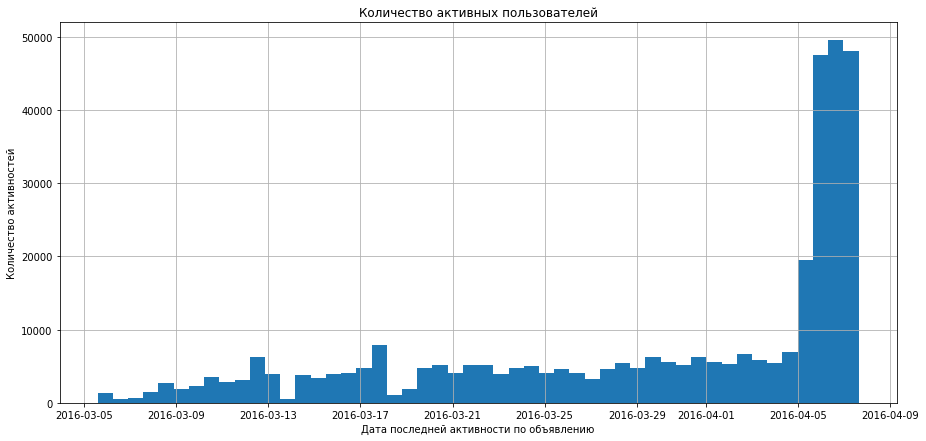

In [12]:
ax = df['last_seen'].hist(bins = 50, figsize = (15,7))
ax.set_title('Количество активных пользователей')
ax.set_xlabel('Дата последней активности по объявлению')
ax.set_ylabel('Количество активностей')
None

- Столбцы "last_seen" и "date_crawled" содержат очень маленький интервал и нам не понадобятся. Фактор инфляции тут не применим. А вот в date_created есть объявления за целый год, хоть и крайне мало. Рассмотрим данные.


In [13]:
df['price'][df['date_created'] <= '2016-03-01'].describe()

count      543.000000
mean      6418.206262
std       4780.030855
min          0.000000
25%       2400.000000
50%       5499.000000
75%       9300.000000
max      20000.000000
Name: price, dtype: float64

In [14]:
df['price'][df['date_created'] > '2016-03-01'].describe()

count    353822.000000
mean       4413.608148
std        4513.081336
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

- Средние и медианные значения цены разительно отличаются по периодам. Старые объявления - по всей видимости с завышенными ценами. Поскольку такие ориентиры нам не очень нужны - выкидываем.

In [15]:
df = df[df['date_created'] > '2016-03-01']

In [16]:
df['price'].describe()

count    353822.000000
mean       4413.608148
std        4513.081336
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

- Больше столбцы с датами нам не нужны.


In [17]:
df = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353822 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               353822 non-null  int64 
 1   vehicle_type        316384 non-null  object
 2   registration_year   353822 non-null  int64 
 3   gearbox             334006 non-null  object
 4   power               353822 non-null  int64 
 5   model               334149 non-null  object
 6   kilometer           353822 non-null  int64 
 7   registration_month  353822 non-null  int64 
 8   fuel_type           320969 non-null  object
 9   brand               353822 non-null  object
 10  not_repaired        282761 non-null  object
 11  postal_code         353822 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


- Посмотрим сколько бесплатных машин за ноль евро.    

In [18]:
df['price'].value_counts()

0        10766
500       5670
1500      5391
1000      4645
1200      4590
         ...  
16050        1
9298         1
9649         1
1366         1
8188         1
Name: price, Length: 3729, dtype: int64

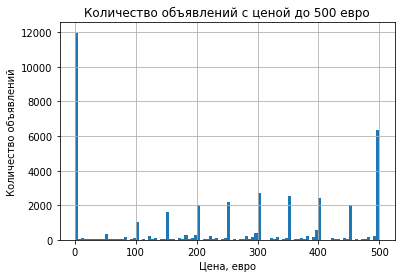

In [19]:
ax = df['price'][df['price'] <= 500].hist(bins = 100)
ax.set_title('Количество объявлений с ценой до 500 евро')
ax.set_xlabel('Цена, евро')
ax.set_ylabel('Количество объявлений')
None

- Бесплатные автомобили мы сразу выкинем. Мы не хотим предсказывать нули.

- Если по какой-то причине человек не хочет указывать цену в объявлении и "дарит" автомобиль, наша задача всё равно определить его рыночную цену. Она не может быть ноль.

- Тут же в глаза бросается дикая любовь к круглым числам - 50, 100, 150, 200 и т.д. Вроде 21 век на дворе, все знают, что надо продавать за 199.

- Рассмотрим, что за автомобили до 200 долларов.

In [20]:
df = df[df['price'] != 0]

In [21]:
df[df['price'] < 200]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,53721
79,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,78315
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,40589
145,150,NaN,1985,NaN,0,100,150000,4,petrol,audi,NaN,87616
238,130,wagon,1998,NaN,0,e_klasse,150000,0,NaN,mercedes_benz,NaN,22047
...,...,...,...,...,...,...,...,...,...,...,...,...
354018,100,small,1996,manual,0,polo,150000,0,petrol,volkswagen,NaN,75172
354117,1,wagon,1993,auto,217,5er,150000,12,petrol,bmw,NaN,22941
354273,150,small,1993,manual,55,astra,150000,3,petrol,opel,yes,66424
354309,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,91301


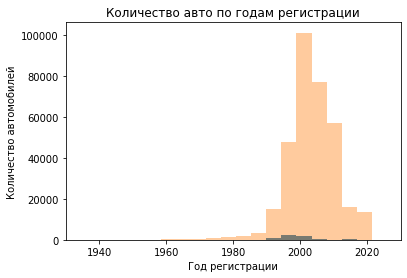

In [22]:
ax = df['registration_year'][df['price'] < 200].plot.hist(bins = 2000, xlim = (1930, 2030))
df['registration_year'][df['price'] >= 200].plot.hist(bins = 2000, xlim = (1930, 2030), alpha = 0.4)
ax.set_title('Количество авто по годам регистрации')
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Количество автомобилей')
None

In [23]:
df['kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000])

- Очень много старых автомобилей;
- Ауди 1985 года может стоить 150 евро. Возможно низкая цена связана с высокими налогами и/или высокой стоимостью утилизации авто;
- Пробег автомобиля фактически оказался категориальным признаком. Его необходимо будет закодировать.

In [24]:
df.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.033845,0.160375,-0.350383,0.097844,0.071766
registration_year,0.033845,1.000000,0.000689,-0.054832,-0.010877,-0.002802
power,0.160375,0.000689,1.000000,0.021518,0.038601,0.020858
kilometer,-0.350383,-0.054832,0.021518,1.000000,0.002450,-0.009061
registration_month,0.097844,-0.010877,0.038601,0.002450,1.000000,0.009928
postal_code,0.071766,-0.002802,0.020858,-0.009061,0.009928,1.000000


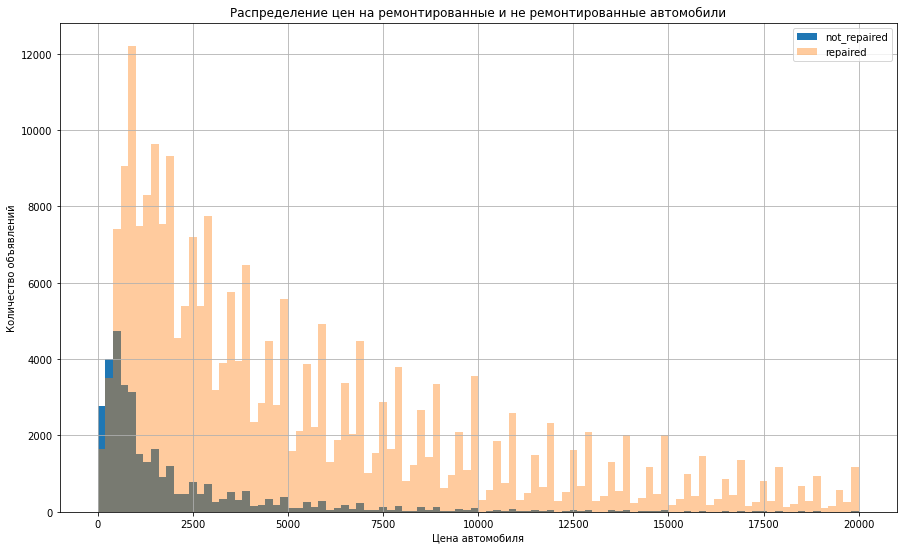

In [25]:
df['price'][df['not_repaired'] == 'yes'].hist(bins = 100, legend = True, figsize = (15,9))
ax = df['price'][df['not_repaired'] == 'no'].hist(bins = 100, alpha = 0.4, legend = True)
ax.set_title('Распределение цен на ремонтированные и не ремонтированные автомобили')
ax.set_xlabel('Цена автомобиля')
ax.set_ylabel('Количество объявлений')
ax.legend(['not_repaired', 'repaired'])
None

In [26]:
display(df['price'][df['not_repaired'] == 'yes'].describe())
display(df['price'][df['not_repaired'] == 'no'].describe())
display(df['price'][df['not_repaired'].isna()].describe())

count    34023.000000
mean      2028.110984
std       2706.111828
min          1.000000
25%        500.000000
50%        999.000000
75%       2400.000000
max      20000.000000
Name: price, dtype: float64

count    243259.000000
mean       5369.678581
std        4714.121518
min           1.000000
25%        1690.000000
50%        3777.000000
75%        7800.000000
max       20000.000000
Name: price, dtype: float64

count    65774.000000
mean      2834.046888
std       3403.146610
min          1.000000
25%        690.000000
50%       1500.000000
75%       3500.000000
max      20000.000000
Name: price, dtype: float64

In [27]:
print('Количество пропусков в столбце "not_repaired" ', 
      round(len(df['price'][df['not_repaired'].isna()]) / len(df)*100, 2), '%')

Количество пропусков в столбце "not_repaired"  19.17 %


- Разница между авто подвергавшихся и не подвергавшихся ремонту очевидна. Удалить столбец - потерять важные данные.
    
- В столбце 65 тысяч пропусков. Судя по среднему и дисперсии, цены там близки к "ремонтированным" автомобилям, но всё же слегка смещены выше. 
    
- Тут два варианта - либо там действительно какой-то процент людей новых машин "забыли" указать, что они новые, либо некоторые люди смекнули, что если не напомнить, что машина из ремонта, то можно чуток и цену накинуть. Судя по среднему - в среднем на 40%.
    
- Что же, мы можем только принять для себя гипотезу, что в объявлениях указана рыночная цена, а значит отсутсвие данных в этом столбце является отдельной категорией, чья цена отличается от предыдущих двух. Пропуски в этом столбце составляют 19%, все их выкинуть - снизить качество модели. Придётся заполнить новым значением. Возьмем "unknown".

In [28]:
display(df['not_repaired'].value_counts())
df['not_repaired'] = df['not_repaired'].fillna(value = 'unknown')
display(df['not_repaired'].value_counts())

no     243259
yes     34023
Name: not_repaired, dtype: int64

no         243259
unknown     65774
yes         34023
Name: not_repaired, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343056 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               343056 non-null  int64 
 1   vehicle_type        309356 non-null  object
 2   registration_year   343056 non-null  int64 
 3   gearbox             325716 non-null  object
 4   power               343056 non-null  int64 
 5   model               325567 non-null  object
 6   kilometer           343056 non-null  int64 
 7   registration_month  343056 non-null  int64 
 8   fuel_type           313639 non-null  object
 9   brand               343056 non-null  object
 10  not_repaired        343056 non-null  object
 11  postal_code         343056 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 34.0+ MB


- У нас будет стоять задача численного определения стоимости, а значит -  регрессии, для этого нам придётся кодировать все категоральные значения. Отсюда есть смысл так же заполнить пропуски в категоральных столбцах как "unknown", либо удалить.
    
- Но если удалить, то получится не очень красивая картина, фича сервиса будет работать, только при полном заполнении всех полей, что негативно скажется на пользователях, котоыре могут не знать или не понимать такого типа автомобиль или каакая у него модель. Стоит отметить, что колонка "brand", данные для которых написаны минимум в трех местах автомобиля, не содержит пропусков.

In [30]:
df['vehicle_type'] = df['vehicle_type'].fillna(value = 'unknown')
df['gearbox'] = df['gearbox'].fillna(value = 'unknown')
df['model'] = df['model'].fillna(value = 'unknown')
df['fuel_type'] = df['fuel_type'].fillna(value = 'unknown')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343056 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               343056 non-null  int64 
 1   vehicle_type        343056 non-null  object
 2   registration_year   343056 non-null  int64 
 3   gearbox             343056 non-null  object
 4   power               343056 non-null  int64 
 5   model               343056 non-null  object
 6   kilometer           343056 non-null  int64 
 7   registration_month  343056 non-null  int64 
 8   fuel_type           343056 non-null  object
 9   brand               343056 non-null  object
 10  not_repaired        343056 non-null  object
 11  postal_code         343056 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 34.0+ MB


- Завершили заполнение пропусков;
- Необходимо исследовать выбросы в числовых значениях:
        
    registration_year
    
    power
    
    kilometer (Как показывали ранее - категориальный признак)
    
    registration_month

    

In [32]:
df['registration_year'].describe()

count    343056.000000
mean       2004.092854
std          78.455665
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Первы автомобиль:
    появляется в 1806 году.
    
Люди до 1806 года:
     через сотни лет мы разместим свою гужевую повозку на сервисе "не бит не крашен".

    
 - У раритетных автомобилей рыночная цена формируется на аукционах, а у автомобилей из будущего - в книгах писателей-фантастов. Посмотрим, какой процент автомобилей зарегистрирован до 1980 года (старше тридцати пяти лет) и после 2016. Если их процент не высок - будем удалять такие объявления.
    
- С точки зрения бизнеса я не заню, почему на сайте можно регестрировать автомобили из будущего, но и разбираться сейчас смысла не вижу. Если бы у нас был прямой доступ к заказчику, могли бы обсудить. Цель нашей работы сейчас не в этом.

In [33]:
print('Количество автомобилей с потенциально недостоверной датой регистрации', 
      (1 - len(df.query('1980 <= registration_year < 2017'))/ len(df))*100, '%') 

Количество автомобилей с потенциально недостоверной датой регистрации 4.932430856769743 %


In [34]:
df = df.query('1980 <= registration_year < 2017')

<AxesSubplot:>

<AxesSubplot:ylabel='Frequency'>

count    326135.000000
mean        112.211241
std         183.476805
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

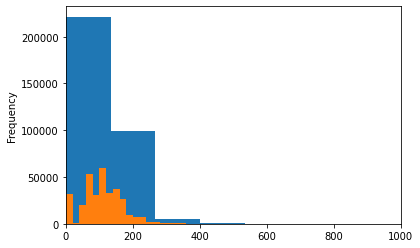

In [35]:
display(df['power'].hist(bins = 150))
None
display(df['power'].plot.hist(bins = 1000, xlim = (0, 1000)))
None
df['power'].describe()


In [36]:
for brand in df['brand'].unique():
    print(brand, len(df[df['brand'] == brand]))

volkswagen 70193
audi 27552
jeep 602
skoda 5271
bmw 34596
peugeot 10388
ford 23199
mazda 5239
nissan 4616
renault 16378
mercedes_benz 29885
seat 6344
honda 2581
fiat 8674
opel 36332
mini 3037
smart 4955
hyundai 3392
sonstige_autos 2137
alfa_romeo 2105
subaru 712
volvo 2998
mitsubishi 2813
kia 2303
suzuki 2197
lancia 421
citroen 4732
toyota 4378
chevrolet 1559
dacia 863
daihatsu 748
trabant 370
chrysler 1302
jaguar 474
daewoo 504
porsche 663
rover 431
saab 499
land_rover 504
lada 188


In [37]:
for model in df[df['brand'] == 'volkswagen']['model'].unique():
    print(model, len(df[df['model'] == model]))

golf 26666
passat 9543
polo 12006
scirocco 565
transporter 4447
other 21779
jetta 336
unknown 14880
eos 500
touran 3221
lupo 2406
caddy 1455
tiguan 645
sharan 1378
up 339
fox 707
beetle 768
touareg 558
phaeton 204
cc 129
bora 829
kaefer 151
amarok 12


<AxesSubplot:ylabel='Frequency'>

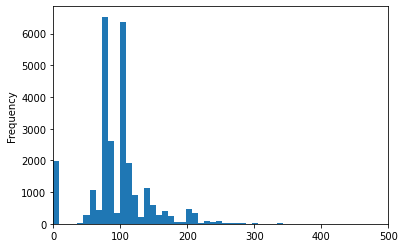

In [38]:
df.query('model == "golf" and brand == "volkswagen"')['power'].plot.hist(bins = 1000, xlim = (0, 500))

- По информации в открытых источниках мощность двигателя у фольцваген поло варьируется в пределах от 40 до 220 лошадиных сил, самый слабый двигатель в мире обладает 4.1 лошадиные силы (электромопед в корпусе автомобиля), а самый мощный - 1600 лошадиных сил. 
    
- Пытаться угадать мощность двигателя - только портить данные. Тут не подойдет замена на среднее или медианное значение. Данные с мощностями выше 1600 и ниже 4 стоит просто удалить.

- Обладателям таких уникальных средств передвижения придётся уточнять рыночную цену самостоятельно.

In [39]:
df = df.query('4 <= power <= 1600')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294013 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               294013 non-null  int64 
 1   vehicle_type        294013 non-null  object
 2   registration_year   294013 non-null  int64 
 3   gearbox             294013 non-null  object
 4   power               294013 non-null  int64 
 5   model               294013 non-null  object
 6   kilometer           294013 non-null  int64 
 7   registration_month  294013 non-null  int64 
 8   fuel_type           294013 non-null  object
 9   brand               294013 non-null  object
 10  not_repaired        294013 non-null  object
 11  postal_code         294013 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.2+ MB


 - Осталось подготовить:
    
    kilometer
    
    registration_month  
 - Как уже показывали ранее, "kilometer" категориальный признак без пропусков.

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

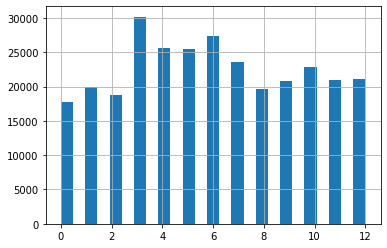

In [40]:
df['registration_month'].hist(bins = 25)
df['registration_month'].unique()

- В налиции 13 месяцев года, включая нулевой.

In [41]:
df.corr()['price']

price                 1.000000
registration_year     0.569468
power                 0.460943
kilometer            -0.387154
registration_month    0.070701
postal_code           0.064299
Name: price, dtype: float64

In [42]:
df.query('registration_year > 2015').corr()['price']

price                 1.000000
registration_year          NaN
power                 0.335422
kilometer            -0.415983
registration_month    0.091144
postal_code           0.038926
Name: price, dtype: float64

In [43]:
price_vs_month = df.pivot_table(
    index = 'registration_month' , values = 'price', aggfunc = ['count', 'mean', 'median'])
price_vs_month

,count,mean,median
,price,price,price
registration_month,,,
0,17770,2340.399606,1200
1,19994,4969.384965,3200
2,18703,4841.684061,3200
3,30175,4822.134051,3100
4,25594,5026.537978,3400
5,25443,4918.120465,3300
6,27356,4970.839743,3300
7,23508,5013.440063,3350


In [44]:
for month in df['registration_month'].unique():
    print(month)
    display(df.query('registration_month == @month').describe())

5


,price,registration_year,power,kilometer,registration_month,postal_code
count,25443.000000,25443.000000,25443.000000,25443.000000,25443.0,25443.000000
mean,4918.120465,2003.204575,120.327634,127700.349802,5.0,51501.644971
std,4602.744290,5.909706,57.056984,36732.394774,0.0,25862.448195
min,1.000000,1980.000000,4.000000,5000.000000,5.0,1067.000000
25%,1400.000000,1999.000000,79.000000,125000.000000,5.0,31061.000000
50%,3300.000000,2003.000000,110.000000,150000.000000,5.0,50739.000000
75%,6999.000000,2007.000000,147.000000,150000.000000,5.0,72336.000000
max,20000.000000,2016.000000,1598.000000,150000.000000,5.0,99998.000000


8


,price,registration_year,power,kilometer,registration_month,postal_code
count,19619.000000,19619.000000,19619.000000,19619.000000,19619.0,19619.000000
mean,4961.708395,2003.367042,120.759315,127619.654417,8.0,50625.873847
std,4570.515911,5.712957,55.624302,37004.370976,0.0,25556.835926
min,1.000000,1980.000000,5.000000,5000.000000,8.0,1067.000000
25%,1450.000000,1999.000000,77.000000,125000.000000,8.0,30823.000000
50%,3300.000000,2003.000000,110.000000,150000.000000,8.0,49504.000000
75%,7200.000000,2008.000000,150.000000,150000.000000,8.0,70734.000000
max,20000.000000,2016.000000,1120.000000,150000.000000,8.0,99994.000000


6


,price,registration_year,power,kilometer,registration_month,postal_code
count,27356.000000,27356.000000,27356.000000,27356.000000,27356.0,27356.000000
mean,4970.839743,2003.214359,122.038456,128020.178389,6.0,51192.000548
std,4624.639414,5.901442,59.542896,36611.064656,0.0,25842.932715
min,1.000000,1980.000000,4.000000,5000.000000,6.0,1067.000000
25%,1450.000000,1999.000000,80.000000,125000.000000,6.0,30900.000000
50%,3300.000000,2003.000000,114.000000,150000.000000,6.0,50734.000000
75%,7100.000000,2007.000000,150.000000,150000.000000,6.0,72163.000000
max,20000.000000,2016.000000,1598.000000,150000.000000,6.0,99996.000000


7


,price,registration_year,power,kilometer,registration_month,postal_code
count,23508.000000,23508.000000,23508.000000,23508.000000,23508.0,23508.000000
mean,5013.440063,2002.874000,124.592947,128758.507742,7.0,51963.531691
std,4648.078527,5.948578,58.349779,35946.856054,0.0,25765.015664
min,1.000000,1980.000000,4.000000,5000.000000,7.0,1067.000000
25%,1400.000000,1999.000000,82.000000,125000.000000,7.0,31303.000000
50%,3350.000000,2003.000000,116.000000,150000.000000,7.0,51371.000000
75%,7300.000000,2007.000000,150.000000,150000.000000,7.0,72827.000000
max,20000.000000,2016.000000,1436.000000,150000.000000,7.0,99988.000000


10


,price,registration_year,power,kilometer,registration_month,postal_code
count,22867.000000,22867.000000,22867.000000,22867.000000,22867.0,22867.000000
mean,5092.478681,2003.299864,123.123934,128377.137360,10.0,51735.780032
std,4615.443413,5.648672,58.892122,36449.790514,0.0,25552.077894
min,1.000000,1980.000000,4.000000,5000.000000,10.0,1067.000000
25%,1500.000000,1999.000000,80.000000,125000.000000,10.0,31587.000000
50%,3500.000000,2003.000000,116.000000,150000.000000,10.0,50827.000000
75%,7490.000000,2007.000000,150.000000,150000.000000,10.0,72160.000000
max,20000.000000,2016.000000,1598.000000,150000.000000,10.0,99998.000000


0


,price,registration_year,power,kilometer,registration_month,postal_code
count,17770.000000,17770.000000,17770.000000,17770.000000,17770.0,17770.000000
mean,2340.399606,2000.602814,111.131345,135886.325267,0.0,48851.503433
std,2956.179515,6.711515,61.234733,34016.611443,0.0,26092.908848
min,1.000000,1980.000000,4.000000,5000.000000,0.0,1067.000000
25%,550.000000,1997.000000,75.000000,150000.000000,0.0,27442.000000
50%,1200.000000,2000.000000,101.000000,150000.000000,0.0,47506.000000
75%,2899.000000,2004.000000,136.000000,150000.000000,0.0,67060.500000
max,20000.000000,2016.000000,1500.000000,150000.000000,0.0,99998.000000


12


,price,registration_year,power,kilometer,registration_month,postal_code
count,21169.000000,21169.000000,21169.000000,21169.000000,21169.0,21169.000000
mean,4905.339837,2002.948651,123.709245,129609.806793,12.0,50191.507960
std,4538.840239,5.526910,60.740941,35697.037504,0.0,25782.679291
min,1.000000,1980.000000,4.000000,5000.000000,12.0,1067.000000
25%,1450.000000,1999.000000,80.000000,125000.000000,12.0,29525.000000
50%,3300.000000,2003.000000,116.000000,150000.000000,12.0,49084.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,12.0,70599.000000
max,20000.000000,2016.000000,1600.000000,150000.000000,12.0,99998.000000


11


,price,registration_year,power,kilometer,registration_month,postal_code
count,20960.000000,20960.000000,20960.000000,20960.000000,20960.0,20960.000000
mean,5209.912166,2003.309017,124.225143,127903.864504,11.0,51067.233158
std,4726.235013,5.632746,59.449364,36897.379807,0.0,25814.821515
min,1.000000,1980.000000,5.000000,5000.000000,11.0,1067.000000
25%,1500.000000,1999.000000,82.000000,125000.000000,11.0,30539.000000
50%,3550.000000,2004.000000,116.000000,150000.000000,11.0,50321.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,11.0,71711.000000
max,20000.000000,2016.000000,1600.000000,150000.000000,11.0,99994.000000


2


,price,registration_year,power,kilometer,registration_month,postal_code
count,18703.000000,18703.000000,18703.000000,18703.000000,18703.0,18703.000000
mean,4841.684061,2003.430305,118.994760,127977.329840,2.0,51315.603486
std,4575.611047,5.840586,58.589239,36929.152335,0.0,25678.434244
min,1.000000,1980.000000,10.000000,5000.000000,2.0,1067.000000
25%,1350.000000,2000.000000,75.000000,125000.000000,2.0,31228.000000
50%,3200.000000,2003.000000,109.000000,150000.000000,2.0,50171.000000
75%,6999.000000,2008.000000,143.000000,150000.000000,2.0,71686.000000
max,20000.000000,2016.000000,1506.000000,150000.000000,2.0,99998.000000


3


,price,registration_year,power,kilometer,registration_month,postal_code
count,30175.000000,30175.000000,30175.000000,30175.000000,30175.0,30175.000000
mean,4822.134051,2003.154432,119.440166,127338.856669,3.0,51886.137266
std,4600.884623,5.923941,57.354789,37302.032717,0.0,25917.137342
min,1.000000,1980.000000,4.000000,5000.000000,3.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.0,31224.000000
50%,3100.000000,2003.000000,110.000000,150000.000000,3.0,51103.000000
75%,6900.000000,2007.000000,145.000000,150000.000000,3.0,72649.000000
max,20000.000000,2016.000000,1598.000000,150000.000000,3.0,99988.000000


1


,price,registration_year,power,kilometer,registration_month,postal_code
count,19994.000000,19994.000000,19994.000000,19994.000000,19994.0,19994.000000
mean,4969.384965,2003.222267,122.296439,129222.516755,1.0,51022.347204
std,4726.423794,5.952673,60.561536,36123.554228,0.0,25503.407770
min,1.000000,1980.000000,4.000000,5000.000000,1.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,1.0,31167.000000
50%,3200.000000,2003.000000,114.000000,150000.000000,1.0,49724.500000
75%,7200.000000,2008.000000,150.000000,150000.000000,1.0,71133.250000
max,20000.000000,2016.000000,1501.000000,150000.000000,1.0,99998.000000


4


,price,registration_year,power,kilometer,registration_month,postal_code
count,25594.000000,25594.000000,25594.000000,25594.000000,25594.0,25594.000000
mean,5026.537978,2003.209659,121.645815,127571.501133,4.0,52112.113855
std,4702.927639,6.016723,58.654666,36825.058473,0.0,25738.129260
min,1.000000,1980.000000,4.000000,5000.000000,4.0,1067.000000
25%,1399.000000,1999.000000,80.000000,125000.000000,4.0,31582.000000
50%,3400.000000,2004.000000,114.000000,150000.000000,4.0,51545.000000
75%,7299.000000,2008.000000,150.000000,150000.000000,4.0,73054.000000
max,20000.000000,2016.000000,1600.000000,150000.000000,4.0,99976.000000


9


,price,registration_year,power,kilometer,registration_month,postal_code
count,20855.000000,20855.000000,20855.000000,20855.000000,20855.0,20855.000000
mean,5159.687461,2003.406234,123.095948,127494.126109,9.0,51551.603500
std,4688.534764,5.681192,61.816168,36818.057264,0.0,25676.393032
min,1.000000,1980.000000,4.000000,5000.000000,9.0,1067.000000
25%,1500.000000,1999.000000,80.000000,125000.000000,9.0,31138.000000
50%,3500.000000,2004.000000,115.000000,150000.000000,9.0,50859.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.0,72336.000000
max,20000.000000,2016.000000,1598.000000,150000.000000,9.0,99998.000000


- Автомобили с нулевым месяцем регистрации в среднем зарегистрированы раньше, с большим пробегом и меньшей мощностью. По всей видимости, часто, либо всегда, за нулевым месяцем прячутся более старые автомобили. А какая там статистика по коробкам передач? И как распределяется годы регистрации в нулевой месяц относительно остальных?

In [45]:
display(df.query('registration_month == 0')['gearbox'].value_counts())
display(df.query('registration_month != 0')['gearbox'].value_counts())

manual     13812
auto        2395
unknown     1563
Name: gearbox, dtype: int64

manual     216577
auto        55937
unknown      3729
Name: gearbox, dtype: int64

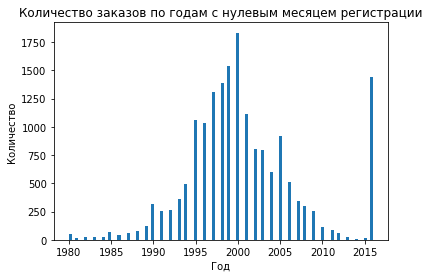

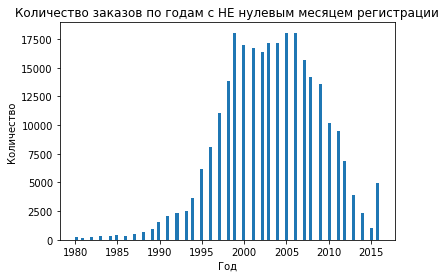

In [46]:
plt.hist(df[df['registration_month'] == 0]['registration_year'], bins = 100)
plt.title('Количество заказов по годам с нулевым месяцем регистрации')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

plt.hist(df[df['registration_month'] != 0]['registration_year'], bins = 100)
plt.title('Количество заказов по годам с НЕ нулевым месяцем регистрации')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()
None

In [47]:
df.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.569468,0.460943,-0.387154,0.070701,0.064299
registration_year,0.569468,1.000000,0.121583,-0.365722,0.041935,0.032953
power,0.460943,0.121583,1.000000,0.091617,0.036618,0.047390
kilometer,-0.387154,-0.365722,0.091617,1.000000,-0.017445,-0.010832
registration_month,0.070701,0.041935,0.036618,-0.017445,1.000000,0.002483
postal_code,0.064299,0.032953,0.047390,-0.010832,0.002483,1.000000


- факт достаточно очевиден - нулевой месяц влияет на цену, поскольку основная кореляция между ценой и годом регистрации, а средний год регистрации у объявлений с нулевым месяцем - меньше.

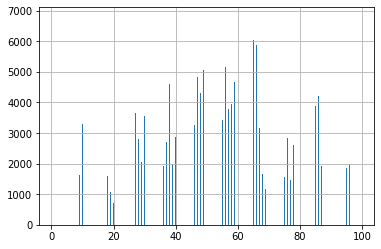

In [48]:
(df['postal_code']//1000).hist(bins = 1000)
None

- Анализ почтовых кодов показывает, что они являются zip кодами Германии. Первые две цифры показывают регион, а последние 3 специфику локации. Раздели почтовый код и проанализируем. Очевидно, что уточнение для расположения из трёх последний чисел нам не пригодится, для категоральной переменной - слишком много категорий.
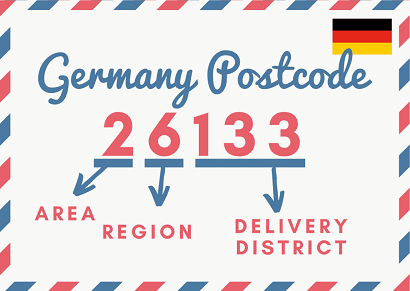

In [49]:
df['postal_code1'] = df['postal_code'].astype(str).str[:1].astype(int)
df['postal_code2'] = df['postal_code'].astype(str).str[1:2].astype(int)
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,postal_code1,postal_code2
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954,6,6
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480,9,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,9,1
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,6,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,auto,150,159,150000,12,unknown,alfa_romeo,no,51371,5,1
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465,9,6
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135,2,6
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439,8,7


- Обучаться на слишком низких ценах так же может быть вредно. В таких объявлениях низкие цены обычно обоснованы объективными причинами, которые не указаны в данной таблице. На всякий случай уберем нижние 3% объявлений о цене. Просто интуитивно кажется, что надо так сделать.

In [50]:
df['price'].quantile(0.03)

300.0

In [51]:
df = df.query('price >= 300')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286235 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               286235 non-null  int64 
 1   vehicle_type        286235 non-null  object
 2   registration_year   286235 non-null  int64 
 3   gearbox             286235 non-null  object
 4   power               286235 non-null  int64 
 5   model               286235 non-null  object
 6   kilometer           286235 non-null  int64 
 7   registration_month  286235 non-null  int64 
 8   fuel_type           286235 non-null  object
 9   brand               286235 non-null  object
 10  not_repaired        286235 non-null  object
 11  postal_code         286235 non-null  int64 
 12  postal_code1        286235 non-null  int64 
 13  postal_code2        286235 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 32.8+ MB


In [52]:
df[df.duplicated()].head(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,postal_code1,postal_code2
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no,52388,5,2
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no,32756,3,2
3907,500,small,1999,manual,55,corsa,150000,12,petrol,opel,no,51377,5,1
4134,18750,sedan,2014,manual,150,golf,20000,9,gasoline,volkswagen,no,38518,3,8
4222,14500,wagon,2007,manual,140,a6,100000,3,gasoline,audi,no,94060,9,4
4300,1250,wagon,2000,manual,131,mondeo,150000,7,petrol,ford,no,17389,1,7
4604,7000,suv,2006,manual,177,rav,150000,0,gasoline,toyota,no,51105,5,1
4826,5500,sedan,2000,manual,170,3er,150000,5,petrol,bmw,no,41470,4,1
5036,8000,bus,2012,manual,114,vivaro,100000,6,gasoline,opel,no,10115,1,0
6872,1000,sedan,1991,manual,116,vectra,80000,11,petrol,opel,no,25856,2,5


In [53]:
df.query('(model == "golf") and (price == 1699) and (vehicle_type == "convertible")').head(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,postal_code1,postal_code2
1705,1699,convertible,1996,auto,101,golf,150000,6,petrol,volkswagen,no,18209,1,8
6972,1699,convertible,1996,auto,101,golf,150000,6,petrol,volkswagen,no,18209,1,8
17206,1699,convertible,1999,manual,101,golf,150000,1,petrol,volkswagen,no,47798,4,7
97096,1699,convertible,1997,manual,110,golf,150000,6,gasoline,volkswagen,no,82362,8,2
128307,1699,convertible,1988,manual,90,golf,150000,0,petrol,volkswagen,unknown,90542,9,0
193902,1699,convertible,1994,manual,75,golf,150000,4,petrol,volkswagen,unknown,58313,5,8
267719,1699,convertible,1998,manual,101,golf,150000,5,petrol,volkswagen,no,49413,4,9
268219,1699,convertible,1982,manual,72,golf,150000,11,petrol,volkswagen,no,6237,6,2
319057,1699,convertible,1994,manual,75,golf,150000,7,petrol,volkswagen,no,38259,3,8


In [54]:
df = df.drop_duplicates()
df.duplicated().sum()

0

- месяц, пробег и первые две цефры почтового кода будут категориальными переменными. Поэтому переведем числовое int в object.
- postal_code нам больше не понадобится, его удалим.


In [55]:
df['registration_month'] = df['registration_month'].astype('object')
df['kilometer'] = df['kilometer'].astype('object')
df['postal_code1'] = df['postal_code1'].astype('object')
df['postal_code2'] = df['postal_code2'].astype('object')
df = df.drop('postal_code', axis=1)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267903 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               267903 non-null  int64 
 1   vehicle_type        267903 non-null  object
 2   registration_year   267903 non-null  int64 
 3   gearbox             267903 non-null  object
 4   power               267903 non-null  int64 
 5   model               267903 non-null  object
 6   kilometer           267903 non-null  object
 7   registration_month  267903 non-null  object
 8   fuel_type           267903 non-null  object
 9   brand               267903 non-null  object
 10  not_repaired        267903 non-null  object
 11  postal_code1        267903 non-null  object
 12  postal_code2        267903 non-null  object
dtypes: int64(3), object(10)
memory usage: 28.6+ MB


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code1,postal_code2
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,6,6
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,9,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9,1
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3,3


    В ходе подготовки данных к использованию были выполнены следующие операции: 
    
    1) Заполнили или удалили все пропуски.
    2) Типы данных соответствуют данным.
    3) Удалили лишние столбцы с нерелевантной информацией.
    4) Удалили дубликаты.
    5) Перевели численные признаки, которые по факту являеются категоральными - в тип object.
    6) Сделали некоторые промежуточные выводы.
    
    
Пора приступать к обучению моделей.


## Обучение моделей

    Мы будем использовать простые линейные и древовидные модели, а так же "сложные" можели LightGBM и CatBoost.
    - Для линейных необходимо закодировать категоральные переменные через One-Hot Encoding;
    - Для древовидных через Original Encoding;
    - "сложные" модели сами кодируют категориальные переменные.
    Таким образом нам необходимы три набора фичей: features, features_ohe, features_oe. 

In [57]:
features = df.drop('price', axis=1)
features_ohe = features.copy()
features_ohe = pd.get_dummies(features, drop_first=True)
features_oe = features.copy()
oe = OrdinalEncoder()

features_oe[['vehicle_type', 'gearbox', 'model', 'kilometer', 'registration_month', 'fuel_type', 
             'brand', 'not_repaired','postal_code1','postal_code2']] = oe.fit_transform(features_oe[['vehicle_type', 'gearbox', 
            'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired','postal_code1','postal_code2']])

In [58]:
display(features_ohe, features_oe, features)

,registration_year,power,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,...,postal_code1_9,postal_code2_1,postal_code2_2,postal_code2_3,postal_code2_4,postal_code2_5,postal_code2_6,postal_code2_7,postal_code2_8,postal_code2_9
1,2011,190,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2004,163,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2001,75,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,2008,69,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1995,102,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,2016,150,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
354362,2004,225,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
354366,2000,101,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
354367,1996,102,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code1,postal_code2
1,2.0,2011,1.0,190,226.0,11.0,5.0,2.0,1.0,2.0,5.0,6.0
2,6.0,2004,0.0,163,117.0,11.0,8.0,2.0,14.0,1.0,8.0,0.0
3,5.0,2001,1.0,75,116.0,12.0,6.0,6.0,38.0,0.0,8.0,1.0
4,5.0,2008,1.0,69,101.0,9.0,7.0,2.0,31.0,0.0,5.0,0.0
5,4.0,1995,1.0,102,11.0,12.0,10.0,6.0,2.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
354361,7.0,2016,0.0,150,4.0,12.0,12.0,7.0,0.0,0.0,4.0,1.0
354362,4.0,2004,1.0,225,140.0,12.0,5.0,6.0,30.0,2.0,8.0,6.0
354366,1.0,2000,0.0,101,106.0,11.0,3.0,6.0,32.0,0.0,1.0,6.0
354367,0.0,1996,1.0,102,222.0,12.0,3.0,2.0,38.0,0.0,7.0,7.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code1,postal_code2
1,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,6,6
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,9,0
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9,1
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6,0
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
354361,unknown,2016,auto,150,159,150000,12,unknown,alfa_romeo,no,5,1
354362,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,9,6
354366,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2,6
354367,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,8,7


<div class = "alert alert-info" style="border-left: 14px deep blue">
<b>Комментарий студента_V2</b>

Числа остались числами, категории - закодировались.

</div>

In [59]:
rnd = 12345

In [60]:
target = df['price']


features_train, features_subset, target_train, target_subset = train_test_split(
    features_ohe, target, test_size=0.40, random_state=rnd)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_subset, target_subset, test_size=0.5, random_state=rnd)

<AxesSubplot:>

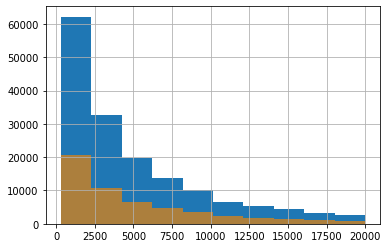

In [61]:
target_train.hist()
target_valid.hist(alpha = 0.7)
target_test.hist(alpha = 0.1)

### LGBMRegressor

In [66]:
LGBM_features = ['vehicle_type', 'gearbox', 'model', 'kilometer', 'registration_month', 'fuel_type', 
             'brand', 'not_repaired','postal_code1','postal_code2']

In [67]:
for f in LGBM_features:
    features[f] = features[f].astype('category')

In [68]:
features_train_lgbm, features_subset_lgbm, target_train_lgbm, target_subset_lgbm = train_test_split(
    features, target, test_size=0.40, random_state=rnd)

features_valid_lgbm, features_test_lgbm, target_valid_lgbm, target_test_lgbm = train_test_split(
    features_subset_lgbm, target_subset_lgbm, test_size=0.5, random_state=rnd)

In [69]:
%%time

model = LGBMRegressor(categorical_feature = LGBM_features)
model.fit(features_train_lgbm, target_train_lgbm)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 4min 18s, sys: 3.75 s, total: 4min 21s
Wall time: 4min 24s


LGBMRegressor(categorical_feature=['vehicle_type', 'gearbox', 'model',
                                   'kilometer', 'registration_month',
                                   'fuel_type', 'brand', 'not_repaired',
                                   'postal_code1', 'postal_code2'])

In [70]:
%%time
probabilities_valid_lgbm = model.predict(features_valid_lgbm)
MSE = mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

2520348.176434742
RMSE модели LGBMRegressor на валидационной выборке 1587.5604481199266
CPU times: user 647 ms, sys: 0 ns, total: 647 ms
Wall time: 570 ms


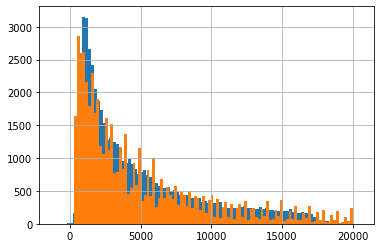

In [71]:
probabilities_valid_hist = pd.Series(data = probabilities_valid_lgbm)
probabilities_valid_hist.hist(bins = 100)
target_valid_lgbm.hist(bins = 100)
None

In [73]:
%%time
model_v2 = LGBMRegressor(learning_rate=0.05, n_estimators=50)
model_v2.fit(features_train_lgbm, target_train_lgbm)

CPU times: user 9.86 s, sys: 89.4 ms, total: 9.95 s
Wall time: 10.4 s


LGBMRegressor(learning_rate=0.05, n_estimators=50)

In [74]:
%%time
model_v3 = LGBMRegressor(learning_rate=0.2, n_jobs = 3, max_depth = 5)
model_v3.fit(features_train_lgbm, target_train_lgbm)

CPU times: user 2.15 s, sys: 14 ms, total: 2.16 s
Wall time: 2.2 s


LGBMRegressor(learning_rate=0.2, max_depth=5, n_jobs=3)

In [75]:
%%time
probabilities_valid_lgbm = model_v2.predict(features_valid_lgbm)
MSE = mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

3248744.984593557
RMSE модели LGBMRegressor на валидационной выборке 1802.4275254760057
CPU times: user 261 ms, sys: 3.8 ms, total: 265 ms
Wall time: 218 ms


In [76]:
%%time
probabilities_valid_lgbm = model_v3.predict(features_valid_lgbm)
MSE = mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

2504673.684437109
RMSE модели LGBMRegressor на валидационной выборке 1582.616088771092
CPU times: user 455 ms, sys: 0 ns, total: 455 ms
Wall time: 392 ms


In [77]:
%%time
MSE_score = make_scorer(mean_squared_error, greater_is_better = False)

parametrs = {'n_estimators': range (60, 161, 50),
              'max_depth': range (1 ,10, 2),
              'n_jobs': range (1,5,1)}

grid = GridSearchCV(LGBMRegressor(), parametrs, cv=3, verbose = 1, scoring = MSE_score)

grid.fit(features_train_lgbm, target_train_lgbm)

grid.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits
CPU times: user 4min 55s, sys: 1.37 s, total: 4min 56s
Wall time: 4min 57s


{'max_depth': 9, 'n_estimators': 160, 'n_jobs': 1}

In [78]:
%%time
model_v4 = LGBMRegressor(n_estimators = 160, n_jobs = 1, max_depth = 9)
model_v4.fit(features_train_lgbm, target_train_lgbm)

CPU times: user 2.09 s, sys: 8.05 ms, total: 2.09 s
Wall time: 2.09 s


LGBMRegressor(max_depth=9, n_estimators=160, n_jobs=1)

In [79]:
%%time
probabilities_valid_lgbm = model_v4.predict(features_valid_lgbm)
MSE = mean_squared_error(target_valid_lgbm, probabilities_valid_lgbm)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

2453382.266588225
RMSE модели LGBMRegressor на валидационной выборке 1566.327637050507
CPU times: user 722 ms, sys: 4.02 ms, total: 726 ms
Wall time: 725 ms


|  Модель   | RMSE на валидационной выборке
|-----------|---------|
| model     | 1587 
| model_v2  | 1802  
| model_v3  | 1582  
| model_v4  | 1566 

 - Лучше всего работает модель с подобранными GridSearch гиперпараметрами.

### CatBoostRegressor

In [80]:
features_train_cb, features_subset_cb, target_train_cb, target_subset_cb = train_test_split(
    features, target, test_size=0.40, random_state=rnd)

features_valid_cb, features_test_cb, target_valid_cb, target_test_cb = train_test_split(
    features_subset_cb, target_subset_cb, test_size=0.5, random_state=rnd)

In [81]:
%%time

model2 = CatBoostRegressor(loss_function="RMSE")
model2.fit(features_train_cb, target_train_cb, cat_features=LGBM_features)

Learning rate set to 0.091358
0:	learn: 4299.3046589	total: 473ms	remaining: 7m 52s
1:	learn: 4055.9293374	total: 816ms	remaining: 6m 46s
2:	learn: 3835.4837319	total: 1.17s	remaining: 6m 28s
3:	learn: 3628.7586649	total: 1.43s	remaining: 5m 55s
4:	learn: 3444.3545349	total: 1.74s	remaining: 5m 46s
5:	learn: 3279.0452877	total: 2.01s	remaining: 5m 33s
6:	learn: 3137.1621797	total: 2.27s	remaining: 5m 21s
7:	learn: 3003.3392374	total: 2.56s	remaining: 5m 16s
8:	learn: 2887.6866534	total: 2.82s	remaining: 5m 10s
9:	learn: 2786.8929020	total: 3.14s	remaining: 5m 10s
10:	learn: 2693.3299574	total: 3.42s	remaining: 5m 7s
11:	learn: 2606.5922884	total: 3.7s	remaining: 5m 4s
12:	learn: 2533.3919388	total: 4.02s	remaining: 5m 5s
13:	learn: 2457.8099333	total: 4.28s	remaining: 5m 1s
14:	learn: 2394.7700818	total: 4.56s	remaining: 4m 59s
15:	learn: 2336.2828848	total: 4.91s	remaining: 5m 1s
16:	learn: 2286.1496544	total: 5.2s	remaining: 5m
17:	learn: 2242.4651637	total: 5.48s	remaining: 4m 59s
1

150:	learn: 1638.4838904	total: 42.8s	remaining: 4m
151:	learn: 1637.4098289	total: 43.1s	remaining: 4m
152:	learn: 1636.7306702	total: 43.4s	remaining: 4m
153:	learn: 1636.3454898	total: 43.7s	remaining: 4m
154:	learn: 1635.3260288	total: 44s	remaining: 4m
155:	learn: 1634.4769613	total: 44.3s	remaining: 3m 59s
156:	learn: 1633.7823425	total: 44.6s	remaining: 3m 59s
157:	learn: 1633.2362459	total: 45s	remaining: 3m 59s
158:	learn: 1632.6833704	total: 45.3s	remaining: 3m 59s
159:	learn: 1631.7149631	total: 45.6s	remaining: 3m 59s
160:	learn: 1630.7692374	total: 45.9s	remaining: 3m 58s
161:	learn: 1629.5920824	total: 46.3s	remaining: 3m 59s
162:	learn: 1629.1816744	total: 46.5s	remaining: 3m 58s
163:	learn: 1628.6753067	total: 46.7s	remaining: 3m 58s
164:	learn: 1628.0833437	total: 47s	remaining: 3m 57s
165:	learn: 1627.3906825	total: 47.3s	remaining: 3m 57s
166:	learn: 1626.6205126	total: 47.8s	remaining: 3m 58s
167:	learn: 1625.5997484	total: 48.3s	remaining: 3m 59s
168:	learn: 1624.7

297:	learn: 1575.2104360	total: 1m 25s	remaining: 3m 21s
298:	learn: 1574.8973926	total: 1m 25s	remaining: 3m 21s
299:	learn: 1574.5908203	total: 1m 26s	remaining: 3m 20s
300:	learn: 1574.5888981	total: 1m 26s	remaining: 3m 20s
301:	learn: 1574.2038552	total: 1m 26s	remaining: 3m 20s
302:	learn: 1574.2018637	total: 1m 26s	remaining: 3m 19s
303:	learn: 1573.8093856	total: 1m 27s	remaining: 3m 19s
304:	learn: 1573.6175758	total: 1m 27s	remaining: 3m 18s
305:	learn: 1573.2973510	total: 1m 27s	remaining: 3m 18s
306:	learn: 1573.0943055	total: 1m 27s	remaining: 3m 18s
307:	learn: 1573.0927389	total: 1m 28s	remaining: 3m 17s
308:	learn: 1572.7204882	total: 1m 28s	remaining: 3m 17s
309:	learn: 1572.5949607	total: 1m 28s	remaining: 3m 17s
310:	learn: 1572.2171851	total: 1m 29s	remaining: 3m 17s
311:	learn: 1571.8015872	total: 1m 29s	remaining: 3m 16s
312:	learn: 1571.6108421	total: 1m 29s	remaining: 3m 16s
313:	learn: 1571.5948956	total: 1m 29s	remaining: 3m 16s
314:	learn: 1571.4317794	total:

443:	learn: 1542.9733415	total: 2m 6s	remaining: 2m 38s
444:	learn: 1542.7538680	total: 2m 7s	remaining: 2m 38s
445:	learn: 1542.5413354	total: 2m 7s	remaining: 2m 38s
446:	learn: 1542.2741220	total: 2m 7s	remaining: 2m 38s
447:	learn: 1542.0977728	total: 2m 8s	remaining: 2m 37s
448:	learn: 1542.0112811	total: 2m 8s	remaining: 2m 37s
449:	learn: 1541.7350530	total: 2m 8s	remaining: 2m 37s
450:	learn: 1541.3956617	total: 2m 8s	remaining: 2m 36s
451:	learn: 1541.1038969	total: 2m 9s	remaining: 2m 36s
452:	learn: 1541.0020400	total: 2m 9s	remaining: 2m 36s
453:	learn: 1540.9662055	total: 2m 9s	remaining: 2m 36s
454:	learn: 1540.4733190	total: 2m 10s	remaining: 2m 35s
455:	learn: 1539.9611248	total: 2m 10s	remaining: 2m 35s
456:	learn: 1539.9574786	total: 2m 10s	remaining: 2m 35s
457:	learn: 1539.7677801	total: 2m 10s	remaining: 2m 35s
458:	learn: 1539.6013634	total: 2m 11s	remaining: 2m 34s
459:	learn: 1539.5740305	total: 2m 11s	remaining: 2m 34s
460:	learn: 1539.2965762	total: 2m 11s	rem

588:	learn: 1521.1975058	total: 2m 47s	remaining: 1m 57s
589:	learn: 1520.9507954	total: 2m 48s	remaining: 1m 56s
590:	learn: 1520.7712900	total: 2m 48s	remaining: 1m 56s
591:	learn: 1520.7426233	total: 2m 48s	remaining: 1m 56s
592:	learn: 1520.7406145	total: 2m 49s	remaining: 1m 56s
593:	learn: 1520.6371173	total: 2m 49s	remaining: 1m 55s
594:	learn: 1520.2234420	total: 2m 49s	remaining: 1m 55s
595:	learn: 1520.2031034	total: 2m 49s	remaining: 1m 55s
596:	learn: 1520.0080714	total: 2m 50s	remaining: 1m 54s
597:	learn: 1519.7870695	total: 2m 50s	remaining: 1m 54s
598:	learn: 1519.6170383	total: 2m 50s	remaining: 1m 54s
599:	learn: 1519.6080180	total: 2m 51s	remaining: 1m 54s
600:	learn: 1519.5728451	total: 2m 51s	remaining: 1m 53s
601:	learn: 1519.4939973	total: 2m 51s	remaining: 1m 53s
602:	learn: 1519.4057392	total: 2m 51s	remaining: 1m 53s
603:	learn: 1519.2894157	total: 2m 52s	remaining: 1m 52s
604:	learn: 1519.2272473	total: 2m 52s	remaining: 1m 52s
605:	learn: 1519.0732460	total:

733:	learn: 1502.7986270	total: 3m 30s	remaining: 1m 16s
734:	learn: 1502.7525420	total: 3m 30s	remaining: 1m 16s
735:	learn: 1502.6582495	total: 3m 31s	remaining: 1m 15s
736:	learn: 1502.4901345	total: 3m 31s	remaining: 1m 15s
737:	learn: 1502.3653310	total: 3m 31s	remaining: 1m 15s
738:	learn: 1502.3184161	total: 3m 32s	remaining: 1m 14s
739:	learn: 1502.0780841	total: 3m 32s	remaining: 1m 14s
740:	learn: 1502.0679212	total: 3m 32s	remaining: 1m 14s
741:	learn: 1501.8949440	total: 3m 32s	remaining: 1m 14s
742:	learn: 1501.6645180	total: 3m 33s	remaining: 1m 13s
743:	learn: 1501.5909856	total: 3m 33s	remaining: 1m 13s
744:	learn: 1501.4796311	total: 3m 33s	remaining: 1m 13s
745:	learn: 1501.4434033	total: 3m 34s	remaining: 1m 12s
746:	learn: 1501.2814767	total: 3m 34s	remaining: 1m 12s
747:	learn: 1501.0656429	total: 3m 34s	remaining: 1m 12s
748:	learn: 1500.9810360	total: 3m 35s	remaining: 1m 12s
749:	learn: 1500.8664971	total: 3m 35s	remaining: 1m 11s
750:	learn: 1500.7483901	total:

881:	learn: 1485.8191098	total: 4m 14s	remaining: 34.1s
882:	learn: 1485.7908464	total: 4m 15s	remaining: 33.8s
883:	learn: 1485.7180483	total: 4m 15s	remaining: 33.5s
884:	learn: 1485.6215513	total: 4m 15s	remaining: 33.2s
885:	learn: 1485.5680439	total: 4m 16s	remaining: 33s
886:	learn: 1485.5427874	total: 4m 16s	remaining: 32.7s
887:	learn: 1485.4209665	total: 4m 16s	remaining: 32.4s
888:	learn: 1485.2810836	total: 4m 17s	remaining: 32.1s
889:	learn: 1485.2007942	total: 4m 17s	remaining: 31.8s
890:	learn: 1485.0504674	total: 4m 17s	remaining: 31.5s
891:	learn: 1484.9136782	total: 4m 18s	remaining: 31.3s
892:	learn: 1484.7472639	total: 4m 18s	remaining: 31s
893:	learn: 1484.6179986	total: 4m 18s	remaining: 30.7s
894:	learn: 1484.4062057	total: 4m 19s	remaining: 30.4s
895:	learn: 1484.3883753	total: 4m 19s	remaining: 30.1s
896:	learn: 1484.3018823	total: 4m 19s	remaining: 29.8s
897:	learn: 1484.1997418	total: 4m 19s	remaining: 29.5s
898:	learn: 1484.1696090	total: 4m 20s	remaining: 29

In [83]:
%%time
probabilities_valid_cb = model2.predict(features_valid_cb)
MSE = mean_squared_error(target_valid_cb, probabilities_valid_cb)
print(MSE)
print('RMSE модели CatBoostRegressor на валидационной выборке', MSE**0.5)

2426692.3903279826
RMSE модели CatBoostRegressor на валидационной выборке 1557.7844492509169
CPU times: user 709 ms, sys: 27 µs, total: 709 ms
Wall time: 713 ms


In [84]:
%%time

MSE_score = make_scorer(mean_squared_error, greater_is_better = False)

parametrs = {'n_estimators': range (60, 161, 50),
              'max_depth': range (1 ,10, 2),
              'l2_leaf_reg': range (1 , 4, 1)}

grid = GridSearchCV(CatBoostRegressor(), parametrs, cv=3, verbose = 1, scoring = MSE_score)

grid.fit(features_train_cb, target_train_cb, cat_features=LGBM_features)

grid.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits
0:	learn: 4521.9672943	total: 35ms	remaining: 2.07s
1:	learn: 4472.8246535	total: 53.5ms	remaining: 1.55s
2:	learn: 4427.4583535	total: 87ms	remaining: 1.65s
3:	learn: 4382.6294802	total: 105ms	remaining: 1.48s
4:	learn: 4340.2739452	total: 124ms	remaining: 1.36s
5:	learn: 4300.0406432	total: 143ms	remaining: 1.28s
6:	learn: 4261.8382873	total: 163ms	remaining: 1.23s
7:	learn: 4224.4274439	total: 195ms	remaining: 1.26s
8:	learn: 4189.0389538	total: 213ms	remaining: 1.21s
9:	learn: 4155.6589259	total: 231ms	remaining: 1.16s
10:	learn: 4123.1664567	total: 250ms	remaining: 1.11s
11:	learn: 4092.9308599	total: 269ms	remaining: 1.08s
12:	learn: 4063.1619731	total: 289ms	remaining: 1.04s
13:	learn: 4035.5258380	total: 307ms	remaining: 1.01s
14:	learn: 4008.2313352	total: 329ms	remaining: 988ms
15:	learn: 3982.0462182	total: 368ms	remaining: 1.01s
16:	learn: 3956.1966004	total: 393ms	remaining: 994ms
17:	learn: 3931.4089615	total: 

40:	learn: 3499.9419548	total: 871ms	remaining: 404ms
41:	learn: 3485.8041140	total: 889ms	remaining: 381ms
42:	learn: 3471.4018643	total: 909ms	remaining: 360ms
43:	learn: 3457.5720441	total: 928ms	remaining: 338ms
44:	learn: 3443.7445680	total: 950ms	remaining: 317ms
45:	learn: 3430.6750180	total: 972ms	remaining: 296ms
46:	learn: 3417.5303272	total: 990ms	remaining: 274ms
47:	learn: 3405.0485806	total: 1.01s	remaining: 252ms
48:	learn: 3392.6141113	total: 1.03s	remaining: 231ms
49:	learn: 3380.0981539	total: 1.05s	remaining: 211ms
50:	learn: 3367.9399314	total: 1.08s	remaining: 190ms
51:	learn: 3356.1039412	total: 1.1s	remaining: 169ms
52:	learn: 3344.5400714	total: 1.12s	remaining: 148ms
53:	learn: 3333.5443661	total: 1.15s	remaining: 127ms
54:	learn: 3322.5111394	total: 1.16s	remaining: 106ms
55:	learn: 3311.9140109	total: 1.18s	remaining: 84.5ms
56:	learn: 3301.2918367	total: 1.2s	remaining: 63.3ms
57:	learn: 3291.2230092	total: 1.22s	remaining: 42.1ms
58:	learn: 3281.1013527	tot

31:	learn: 3645.2716717	total: 649ms	remaining: 1.58s
32:	learn: 3627.6768776	total: 683ms	remaining: 1.59s
33:	learn: 3610.4117884	total: 705ms	remaining: 1.57s
34:	learn: 3593.7984375	total: 725ms	remaining: 1.55s
35:	learn: 3577.7992319	total: 751ms	remaining: 1.54s
36:	learn: 3561.7246026	total: 774ms	remaining: 1.53s
37:	learn: 3545.8282194	total: 792ms	remaining: 1.5s
38:	learn: 3530.5371344	total: 810ms	remaining: 1.47s
39:	learn: 3515.9496224	total: 828ms	remaining: 1.45s
40:	learn: 3500.7949926	total: 847ms	remaining: 1.43s
41:	learn: 3486.7281665	total: 866ms	remaining: 1.4s
42:	learn: 3472.3783993	total: 884ms	remaining: 1.38s
43:	learn: 3458.4430046	total: 902ms	remaining: 1.35s
44:	learn: 3444.6061279	total: 922ms	remaining: 1.33s
45:	learn: 3431.6626189	total: 940ms	remaining: 1.31s
46:	learn: 3418.6332068	total: 959ms	remaining: 1.28s
47:	learn: 3405.9553936	total: 978ms	remaining: 1.26s
48:	learn: 3393.4166690	total: 996ms	remaining: 1.24s
49:	learn: 3381.3439128	total:

82:	learn: 3079.8987469	total: 1.68s	remaining: 546ms
83:	learn: 3073.1964252	total: 1.7s	remaining: 527ms
84:	learn: 3066.8474362	total: 1.72s	remaining: 507ms
85:	learn: 3059.9922615	total: 1.74s	remaining: 486ms
86:	learn: 3053.3590214	total: 1.76s	remaining: 465ms
87:	learn: 3046.7651011	total: 1.78s	remaining: 445ms
88:	learn: 3040.2552979	total: 1.8s	remaining: 424ms
89:	learn: 3033.9959686	total: 1.81s	remaining: 403ms
90:	learn: 3027.5989372	total: 1.83s	remaining: 383ms
91:	learn: 3021.7580919	total: 1.85s	remaining: 362ms
92:	learn: 3015.6784831	total: 1.87s	remaining: 342ms
93:	learn: 3009.6884140	total: 1.89s	remaining: 322ms
94:	learn: 3003.7859259	total: 1.91s	remaining: 302ms
95:	learn: 2997.9533863	total: 1.93s	remaining: 282ms
96:	learn: 2991.9416751	total: 1.95s	remaining: 262ms
97:	learn: 2986.4534361	total: 1.98s	remaining: 242ms
98:	learn: 2981.0046069	total: 2s	remaining: 222ms
99:	learn: 2975.5603679	total: 2.03s	remaining: 203ms
100:	learn: 2971.2879859	total: 2

128:	learn: 2827.1502726	total: 2.52s	remaining: 606ms
129:	learn: 2822.6667066	total: 2.54s	remaining: 586ms
130:	learn: 2818.3452010	total: 2.56s	remaining: 566ms
131:	learn: 2813.8397665	total: 2.58s	remaining: 547ms
132:	learn: 2809.8503811	total: 2.6s	remaining: 527ms
133:	learn: 2805.7760764	total: 2.62s	remaining: 508ms
134:	learn: 2801.4863974	total: 2.63s	remaining: 488ms
135:	learn: 2797.2031189	total: 2.65s	remaining: 468ms
136:	learn: 2792.8767964	total: 2.67s	remaining: 449ms
137:	learn: 2788.7748771	total: 2.69s	remaining: 429ms
138:	learn: 2784.6224226	total: 2.71s	remaining: 410ms
139:	learn: 2780.6241729	total: 2.73s	remaining: 391ms
140:	learn: 2776.5302884	total: 2.75s	remaining: 371ms
141:	learn: 2772.3317082	total: 2.77s	remaining: 351ms
142:	learn: 2769.8062006	total: 2.79s	remaining: 332ms
143:	learn: 2765.9319402	total: 2.81s	remaining: 313ms
144:	learn: 2762.2820223	total: 2.83s	remaining: 293ms
145:	learn: 2758.5808982	total: 2.85s	remaining: 273ms
146:	learn:

126:	learn: 2842.3536607	total: 2.48s	remaining: 645ms
127:	learn: 2837.9441542	total: 2.5s	remaining: 626ms
128:	learn: 2830.1556908	total: 2.52s	remaining: 607ms
129:	learn: 2822.8600786	total: 2.54s	remaining: 587ms
130:	learn: 2815.9180337	total: 2.56s	remaining: 567ms
131:	learn: 2809.4201995	total: 2.58s	remaining: 548ms
132:	learn: 2803.2926114	total: 2.6s	remaining: 529ms
133:	learn: 2797.0789130	total: 2.62s	remaining: 509ms
134:	learn: 2791.5075775	total: 2.64s	remaining: 489ms
135:	learn: 2785.9817754	total: 2.66s	remaining: 469ms
136:	learn: 2780.8219346	total: 2.68s	remaining: 450ms
137:	learn: 2775.9929723	total: 2.7s	remaining: 430ms
138:	learn: 2770.8673395	total: 2.72s	remaining: 410ms
139:	learn: 2766.4292630	total: 2.73s	remaining: 391ms
140:	learn: 2761.7822638	total: 2.75s	remaining: 371ms
141:	learn: 2757.3598709	total: 2.77s	remaining: 351ms
142:	learn: 2753.0464065	total: 2.79s	remaining: 332ms
143:	learn: 2749.1419166	total: 2.81s	remaining: 312ms
144:	learn: 2

128:	learn: 2833.6027199	total: 2.47s	remaining: 594ms
129:	learn: 2828.9675479	total: 2.49s	remaining: 575ms
130:	learn: 2824.5800930	total: 2.51s	remaining: 556ms
131:	learn: 2820.3378042	total: 2.53s	remaining: 537ms
132:	learn: 2815.8337114	total: 2.55s	remaining: 518ms
133:	learn: 2811.4460118	total: 2.57s	remaining: 499ms
134:	learn: 2807.1468885	total: 2.59s	remaining: 479ms
135:	learn: 2802.9961894	total: 2.61s	remaining: 460ms
136:	learn: 2798.9132621	total: 2.63s	remaining: 441ms
137:	learn: 2794.4962316	total: 2.65s	remaining: 422ms
138:	learn: 2790.1719699	total: 2.66s	remaining: 402ms
139:	learn: 2786.0515227	total: 2.68s	remaining: 383ms
140:	learn: 2781.7836964	total: 2.7s	remaining: 364ms
141:	learn: 2777.7830105	total: 2.72s	remaining: 345ms
142:	learn: 2774.6460571	total: 2.74s	remaining: 326ms
143:	learn: 2770.7266894	total: 2.76s	remaining: 306ms
144:	learn: 2766.7918382	total: 2.77s	remaining: 287ms
145:	learn: 2762.7933692	total: 2.79s	remaining: 268ms
146:	learn:

0:	learn: 4501.6335200	total: 45.8ms	remaining: 2.7s
1:	learn: 4428.6028676	total: 93.2ms	remaining: 2.7s
2:	learn: 4358.8600431	total: 144ms	remaining: 2.73s
3:	learn: 4289.4854981	total: 188ms	remaining: 2.63s
4:	learn: 4223.3008826	total: 232ms	remaining: 2.55s
5:	learn: 4160.8281403	total: 266ms	remaining: 2.39s
6:	learn: 4097.9364253	total: 303ms	remaining: 2.29s
7:	learn: 4038.9398772	total: 346ms	remaining: 2.25s
8:	learn: 3981.9940708	total: 380ms	remaining: 2.15s
9:	learn: 3925.9341976	total: 417ms	remaining: 2.08s
10:	learn: 3872.0911208	total: 454ms	remaining: 2.02s
11:	learn: 3820.4411308	total: 488ms	remaining: 1.95s
12:	learn: 3770.9641366	total: 527ms	remaining: 1.91s
13:	learn: 3723.6034840	total: 562ms	remaining: 1.85s
14:	learn: 3676.3406540	total: 596ms	remaining: 1.79s
15:	learn: 3631.2202669	total: 631ms	remaining: 1.73s
16:	learn: 3588.7959453	total: 665ms	remaining: 1.68s
17:	learn: 3545.9844032	total: 699ms	remaining: 1.63s
18:	learn: 3505.0056545	total: 734ms	r

96:	learn: 2241.9989632	total: 3.38s	remaining: 452ms
97:	learn: 2235.5810070	total: 3.41s	remaining: 418ms
98:	learn: 2230.6258658	total: 3.44s	remaining: 383ms
99:	learn: 2224.4015203	total: 3.48s	remaining: 348ms
100:	learn: 2218.5970914	total: 3.51s	remaining: 313ms
101:	learn: 2212.9031829	total: 3.54s	remaining: 278ms
102:	learn: 2207.8331550	total: 3.58s	remaining: 243ms
103:	learn: 2202.1149927	total: 3.61s	remaining: 208ms
104:	learn: 2197.0829462	total: 3.64s	remaining: 174ms
105:	learn: 2192.2539687	total: 3.68s	remaining: 139ms
106:	learn: 2187.2139824	total: 3.71s	remaining: 104ms
107:	learn: 2183.6968612	total: 3.74s	remaining: 69.3ms
108:	learn: 2179.2134738	total: 3.78s	remaining: 34.7ms
109:	learn: 2175.2579192	total: 3.81s	remaining: 0us
0:	learn: 4502.4852009	total: 45.4ms	remaining: 4.95s
1:	learn: 4429.2241050	total: 92ms	remaining: 4.96s
2:	learn: 4357.7710349	total: 139ms	remaining: 4.96s
3:	learn: 4288.3455342	total: 173ms	remaining: 4.59s
4:	learn: 4221.8655831

29:	learn: 3134.7548495	total: 1.07s	remaining: 2.86s
30:	learn: 3106.9996299	total: 1.1s	remaining: 2.81s
31:	learn: 3081.4214449	total: 1.14s	remaining: 2.77s
32:	learn: 3056.0794269	total: 1.17s	remaining: 2.72s
33:	learn: 3031.8918705	total: 1.2s	remaining: 2.68s
34:	learn: 3006.0808078	total: 1.23s	remaining: 2.65s
35:	learn: 2982.6154294	total: 1.27s	remaining: 2.6s
36:	learn: 2961.1212808	total: 1.3s	remaining: 2.56s
37:	learn: 2937.7808457	total: 1.33s	remaining: 2.52s
38:	learn: 2915.7117829	total: 1.36s	remaining: 2.48s
39:	learn: 2895.9568660	total: 1.4s	remaining: 2.45s
40:	learn: 2874.7517641	total: 1.43s	remaining: 2.41s
41:	learn: 2855.4173268	total: 1.46s	remaining: 2.37s
42:	learn: 2837.8702557	total: 1.5s	remaining: 2.33s
43:	learn: 2820.2365822	total: 1.53s	remaining: 2.3s
44:	learn: 2800.8699008	total: 1.56s	remaining: 2.26s
45:	learn: 2782.5175461	total: 1.6s	remaining: 2.23s
46:	learn: 2765.0931960	total: 1.63s	remaining: 2.19s
47:	learn: 2748.5976927	total: 1.67s

72:	learn: 2422.7432480	total: 2.57s	remaining: 3.06s
73:	learn: 2413.8877758	total: 2.61s	remaining: 3.03s
74:	learn: 2405.1728212	total: 2.64s	remaining: 2.99s
75:	learn: 2395.5719340	total: 2.67s	remaining: 2.95s
76:	learn: 2386.6214475	total: 2.71s	remaining: 2.92s
77:	learn: 2378.7806180	total: 2.74s	remaining: 2.88s
78:	learn: 2371.1728910	total: 2.78s	remaining: 2.85s
79:	learn: 2363.3078363	total: 2.81s	remaining: 2.81s
80:	learn: 2354.9422776	total: 2.84s	remaining: 2.77s
81:	learn: 2347.9193357	total: 2.88s	remaining: 2.74s
82:	learn: 2339.2452648	total: 2.91s	remaining: 2.7s
83:	learn: 2331.3645630	total: 2.95s	remaining: 2.67s
84:	learn: 2322.3120423	total: 2.98s	remaining: 2.63s
85:	learn: 2314.9353691	total: 3.02s	remaining: 2.59s
86:	learn: 2307.6396352	total: 3.05s	remaining: 2.56s
87:	learn: 2300.5788339	total: 3.08s	remaining: 2.52s
88:	learn: 2292.2551723	total: 3.12s	remaining: 2.49s
89:	learn: 2284.3242708	total: 3.15s	remaining: 2.45s
90:	learn: 2277.1964949	total

66:	learn: 2487.5969389	total: 2.37s	remaining: 3.29s
67:	learn: 2475.8877237	total: 2.4s	remaining: 3.25s
68:	learn: 2466.3932363	total: 2.44s	remaining: 3.21s
69:	learn: 2456.0797614	total: 2.47s	remaining: 3.18s
70:	learn: 2446.8031225	total: 2.5s	remaining: 3.14s
71:	learn: 2437.4812092	total: 2.54s	remaining: 3.1s
72:	learn: 2427.8369245	total: 2.57s	remaining: 3.07s
73:	learn: 2417.9069552	total: 2.61s	remaining: 3.03s
74:	learn: 2408.8272092	total: 2.65s	remaining: 3.01s
75:	learn: 2400.0239399	total: 2.69s	remaining: 2.98s
76:	learn: 2391.1975869	total: 2.73s	remaining: 2.94s
77:	learn: 2381.4804500	total: 2.76s	remaining: 2.9s
78:	learn: 2371.8994719	total: 2.8s	remaining: 2.87s
79:	learn: 2364.2600036	total: 2.83s	remaining: 2.83s
80:	learn: 2355.7207229	total: 2.87s	remaining: 2.8s
81:	learn: 2348.4281714	total: 2.9s	remaining: 2.76s
82:	learn: 2340.1940922	total: 2.94s	remaining: 2.73s
83:	learn: 2332.8054163	total: 2.98s	remaining: 2.69s
84:	learn: 2325.3160477	total: 3.01

59:	learn: 2567.6502741	total: 2.09s	remaining: 3.49s
60:	learn: 2554.1886356	total: 2.13s	remaining: 3.46s
61:	learn: 2543.6106541	total: 2.16s	remaining: 3.42s
62:	learn: 2530.5500488	total: 2.2s	remaining: 3.39s
63:	learn: 2519.2171640	total: 2.23s	remaining: 3.35s
64:	learn: 2506.9097899	total: 2.27s	remaining: 3.31s
65:	learn: 2496.1385225	total: 2.3s	remaining: 3.27s
66:	learn: 2485.1363237	total: 2.33s	remaining: 3.24s
67:	learn: 2474.0775354	total: 2.37s	remaining: 3.2s
68:	learn: 2463.5372272	total: 2.4s	remaining: 3.17s
69:	learn: 2453.7127084	total: 2.43s	remaining: 3.13s
70:	learn: 2443.4941640	total: 2.47s	remaining: 3.09s
71:	learn: 2434.1377710	total: 2.5s	remaining: 3.06s
72:	learn: 2424.3332787	total: 2.54s	remaining: 3.03s
73:	learn: 2414.2052144	total: 2.58s	remaining: 2.99s
74:	learn: 2405.4303082	total: 2.62s	remaining: 2.97s
75:	learn: 2396.6030951	total: 2.65s	remaining: 2.93s
76:	learn: 2388.1234554	total: 2.69s	remaining: 2.9s
77:	learn: 2379.9373208	total: 2.7

54:	learn: 2366.9653377	total: 2.84s	remaining: 258ms
55:	learn: 2353.3841280	total: 2.89s	remaining: 207ms
56:	learn: 2340.0278340	total: 2.94s	remaining: 155ms
57:	learn: 2326.8057828	total: 2.99s	remaining: 103ms
58:	learn: 2314.5941262	total: 3.04s	remaining: 51.6ms
59:	learn: 2302.7520473	total: 3.1s	remaining: 0us
0:	learn: 4492.0233065	total: 61.7ms	remaining: 3.64s
1:	learn: 4407.3859142	total: 110ms	remaining: 3.2s
2:	learn: 4325.1620567	total: 173ms	remaining: 3.29s
3:	learn: 4246.5793129	total: 237ms	remaining: 3.32s
4:	learn: 4169.9507208	total: 288ms	remaining: 3.16s
5:	learn: 4097.6190787	total: 339ms	remaining: 3.05s
6:	learn: 4028.6916060	total: 399ms	remaining: 3.02s
7:	learn: 3958.5111616	total: 449ms	remaining: 2.92s
8:	learn: 3891.2324805	total: 502ms	remaining: 2.85s
9:	learn: 3826.2058271	total: 563ms	remaining: 2.81s
10:	learn: 3764.1809330	total: 612ms	remaining: 2.73s
11:	learn: 3705.4605069	total: 661ms	remaining: 2.65s
12:	learn: 3647.7644093	total: 712ms	rem

31:	learn: 2846.6329194	total: 1.66s	remaining: 4.04s
32:	learn: 2818.9770349	total: 1.71s	remaining: 3.98s
33:	learn: 2792.4283424	total: 1.75s	remaining: 3.92s
34:	learn: 2765.8325897	total: 1.8s	remaining: 3.87s
35:	learn: 2739.8000860	total: 1.85s	remaining: 3.81s
36:	learn: 2715.9614319	total: 1.9s	remaining: 3.75s
37:	learn: 2692.4752843	total: 1.95s	remaining: 3.7s
38:	learn: 2665.6534273	total: 2s	remaining: 3.64s
39:	learn: 2641.0546875	total: 2.05s	remaining: 3.58s
40:	learn: 2617.7058616	total: 2.09s	remaining: 3.52s
41:	learn: 2594.6924854	total: 2.14s	remaining: 3.47s
42:	learn: 2574.7868613	total: 2.19s	remaining: 3.42s
43:	learn: 2555.0846018	total: 2.24s	remaining: 3.36s
44:	learn: 2534.1026273	total: 2.29s	remaining: 3.31s
45:	learn: 2515.4196120	total: 2.34s	remaining: 3.25s
46:	learn: 2495.9740455	total: 2.39s	remaining: 3.2s
47:	learn: 2478.9339616	total: 2.44s	remaining: 3.15s
48:	learn: 2461.1766468	total: 2.49s	remaining: 3.1s
49:	learn: 2443.8844475	total: 2.54s

74:	learn: 2157.9772185	total: 3.88s	remaining: 1.81s
75:	learn: 2149.8645805	total: 3.93s	remaining: 1.76s
76:	learn: 2141.7230236	total: 3.98s	remaining: 1.71s
77:	learn: 2133.3968283	total: 4.04s	remaining: 1.66s
78:	learn: 2125.9436437	total: 4.09s	remaining: 1.6s
79:	learn: 2119.1320879	total: 4.14s	remaining: 1.55s
80:	learn: 2111.9096748	total: 4.19s	remaining: 1.5s
81:	learn: 2105.3341817	total: 4.24s	remaining: 1.45s
82:	learn: 2098.8029446	total: 4.29s	remaining: 1.4s
83:	learn: 2092.3141598	total: 4.35s	remaining: 1.35s
84:	learn: 2086.5924248	total: 4.41s	remaining: 1.3s
85:	learn: 2080.5465948	total: 4.47s	remaining: 1.25s
86:	learn: 2075.0914965	total: 4.52s	remaining: 1.19s
87:	learn: 2069.7366395	total: 4.58s	remaining: 1.14s
88:	learn: 2064.5020468	total: 4.63s	remaining: 1.09s
89:	learn: 2058.5029290	total: 4.68s	remaining: 1.04s
90:	learn: 2053.3791211	total: 4.73s	remaining: 987ms
91:	learn: 2049.1008424	total: 4.78s	remaining: 935ms
92:	learn: 2044.1139602	total: 4

8:	learn: 3877.7684655	total: 488ms	remaining: 8.19s
9:	learn: 3811.8609319	total: 536ms	remaining: 8.05s
10:	learn: 3750.7135293	total: 586ms	remaining: 7.93s
11:	learn: 3689.3813334	total: 635ms	remaining: 7.83s
12:	learn: 3632.8887267	total: 684ms	remaining: 7.73s
13:	learn: 3576.7881432	total: 739ms	remaining: 7.71s
14:	learn: 3523.8247502	total: 807ms	remaining: 7.8s
15:	learn: 3472.2064833	total: 856ms	remaining: 7.71s
16:	learn: 3421.9687472	total: 907ms	remaining: 7.63s
17:	learn: 3374.2770571	total: 963ms	remaining: 7.6s
18:	learn: 3327.8024933	total: 1.01s	remaining: 7.51s
19:	learn: 3284.0489977	total: 1.06s	remaining: 7.44s
20:	learn: 3241.3101231	total: 1.11s	remaining: 7.36s
21:	learn: 3196.8572945	total: 1.16s	remaining: 7.3s
22:	learn: 3156.4733338	total: 1.21s	remaining: 7.23s
23:	learn: 3118.1504319	total: 1.26s	remaining: 7.17s
24:	learn: 3077.9597250	total: 1.31s	remaining: 7.1s
25:	learn: 3040.4467404	total: 1.36s	remaining: 7.03s
26:	learn: 3003.6949582	total: 1.4

0:	learn: 4492.0233065	total: 65.2ms	remaining: 10.4s
1:	learn: 4407.3859142	total: 124ms	remaining: 9.77s
2:	learn: 4325.1620567	total: 228ms	remaining: 11.9s
3:	learn: 4246.5793129	total: 319ms	remaining: 12.4s
4:	learn: 4169.9507208	total: 367ms	remaining: 11.4s
5:	learn: 4097.6190787	total: 416ms	remaining: 10.7s
6:	learn: 4028.6916060	total: 465ms	remaining: 10.2s
7:	learn: 3958.5111616	total: 513ms	remaining: 9.75s
8:	learn: 3891.2324805	total: 564ms	remaining: 9.46s
9:	learn: 3826.2058271	total: 614ms	remaining: 9.21s
10:	learn: 3764.1809330	total: 662ms	remaining: 8.97s
11:	learn: 3705.4605069	total: 710ms	remaining: 8.76s
12:	learn: 3647.7644093	total: 760ms	remaining: 8.6s
13:	learn: 3592.0246691	total: 810ms	remaining: 8.44s
14:	learn: 3537.2938737	total: 858ms	remaining: 8.29s
15:	learn: 3482.5198472	total: 906ms	remaining: 8.15s
16:	learn: 3431.4852819	total: 954ms	remaining: 8.03s
17:	learn: 3381.4327654	total: 1s	remaining: 7.91s
18:	learn: 3335.3262180	total: 1.05s	rema

153:	learn: 1879.2900905	total: 7.97s	remaining: 310ms
154:	learn: 1878.0693374	total: 8.02s	remaining: 259ms
155:	learn: 1876.7819463	total: 8.07s	remaining: 207ms
156:	learn: 1875.2706658	total: 8.12s	remaining: 155ms
157:	learn: 1874.0769878	total: 8.17s	remaining: 103ms
158:	learn: 1872.4240108	total: 8.23s	remaining: 51.7ms
159:	learn: 1871.3677269	total: 8.28s	remaining: 0us
0:	learn: 4489.1786540	total: 62.8ms	remaining: 9.98s
1:	learn: 4407.7995625	total: 112ms	remaining: 8.84s
2:	learn: 4324.9405920	total: 174ms	remaining: 9.13s
3:	learn: 4245.3069503	total: 237ms	remaining: 9.23s
4:	learn: 4168.9576853	total: 287ms	remaining: 8.89s
5:	learn: 4097.5333954	total: 336ms	remaining: 8.63s
6:	learn: 4026.3265551	total: 385ms	remaining: 8.41s
7:	learn: 3957.0206008	total: 433ms	remaining: 8.23s
8:	learn: 3891.0147289	total: 483ms	remaining: 8.1s
9:	learn: 3827.9764527	total: 534ms	remaining: 8s
10:	learn: 3766.1796752	total: 583ms	remaining: 7.89s
11:	learn: 3704.2320710	total: 634m

147:	learn: 1874.5401850	total: 7.53s	remaining: 611ms
148:	learn: 1872.6834522	total: 7.59s	remaining: 560ms
149:	learn: 1871.1086646	total: 7.64s	remaining: 509ms
150:	learn: 1869.7159310	total: 7.68s	remaining: 458ms
151:	learn: 1868.2679470	total: 7.74s	remaining: 407ms
152:	learn: 1866.6238893	total: 7.79s	remaining: 356ms
153:	learn: 1865.2212899	total: 7.84s	remaining: 305ms
154:	learn: 1864.1511388	total: 7.89s	remaining: 254ms
155:	learn: 1862.8091573	total: 7.94s	remaining: 204ms
156:	learn: 1861.6939201	total: 7.99s	remaining: 153ms
157:	learn: 1860.3511531	total: 8.06s	remaining: 102ms
158:	learn: 1859.3126635	total: 8.11s	remaining: 51ms
159:	learn: 1857.6750878	total: 8.16s	remaining: 0us
0:	learn: 4479.9416798	total: 79.7ms	remaining: 4.7s
1:	learn: 4387.4264576	total: 149ms	remaining: 4.31s
2:	learn: 4298.3049326	total: 237ms	remaining: 4.51s
3:	learn: 4212.7623979	total: 310ms	remaining: 4.34s
4:	learn: 4129.6467149	total: 390ms	remaining: 4.29s
5:	learn: 4050.4685389	

20:	learn: 3143.0354789	total: 1.49s	remaining: 2.77s
21:	learn: 3097.5686403	total: 1.55s	remaining: 2.69s
22:	learn: 3055.0481974	total: 1.62s	remaining: 2.6s
23:	learn: 3014.0040351	total: 1.68s	remaining: 2.53s
24:	learn: 2975.1227537	total: 1.75s	remaining: 2.45s
25:	learn: 2935.0927708	total: 1.81s	remaining: 2.37s
26:	learn: 2898.4203163	total: 1.88s	remaining: 2.3s
27:	learn: 2862.8262150	total: 1.95s	remaining: 2.22s
28:	learn: 2828.5162680	total: 2.01s	remaining: 2.15s
29:	learn: 2796.5488636	total: 2.08s	remaining: 2.08s
30:	learn: 2764.9183186	total: 2.14s	remaining: 2s
31:	learn: 2735.0583662	total: 2.21s	remaining: 1.93s
32:	learn: 2703.7341996	total: 2.27s	remaining: 1.86s
33:	learn: 2676.0773421	total: 2.34s	remaining: 1.79s
34:	learn: 2648.0808693	total: 2.4s	remaining: 1.72s
35:	learn: 2622.0596710	total: 2.47s	remaining: 1.65s
36:	learn: 2597.0913064	total: 2.53s	remaining: 1.57s
37:	learn: 2569.3473508	total: 2.6s	remaining: 1.51s
38:	learn: 2543.0074547	total: 2.68

3:	learn: 4220.0043159	total: 306ms	remaining: 8.12s
4:	learn: 4138.1045848	total: 373ms	remaining: 7.83s
5:	learn: 4059.0676465	total: 440ms	remaining: 7.63s
6:	learn: 3981.4300830	total: 510ms	remaining: 7.5s
7:	learn: 3906.1251087	total: 577ms	remaining: 7.36s
8:	learn: 3834.1002160	total: 655ms	remaining: 7.35s
9:	learn: 3765.2796357	total: 723ms	remaining: 7.23s
10:	learn: 3697.5225102	total: 788ms	remaining: 7.09s
11:	learn: 3633.7371122	total: 854ms	remaining: 6.97s
12:	learn: 3571.0905125	total: 920ms	remaining: 6.87s
13:	learn: 3511.0994767	total: 988ms	remaining: 6.77s
14:	learn: 3453.3677024	total: 1.06s	remaining: 6.69s
15:	learn: 3398.3052924	total: 1.12s	remaining: 6.61s
16:	learn: 3343.9083046	total: 1.19s	remaining: 6.52s
17:	learn: 3292.1659408	total: 1.26s	remaining: 6.44s
18:	learn: 3242.2152423	total: 1.34s	remaining: 6.41s
19:	learn: 3193.4021135	total: 1.41s	remaining: 6.35s
20:	learn: 3147.0365178	total: 1.48s	remaining: 6.27s
21:	learn: 3102.8851732	total: 1.55s

47:	learn: 2347.0659128	total: 3.29s	remaining: 4.25s
48:	learn: 2328.2873392	total: 3.36s	remaining: 4.18s
49:	learn: 2310.9574587	total: 3.42s	remaining: 4.11s
50:	learn: 2294.5847975	total: 3.49s	remaining: 4.04s
51:	learn: 2278.3101573	total: 3.56s	remaining: 3.97s
52:	learn: 2262.4729668	total: 3.62s	remaining: 3.9s
53:	learn: 2247.1857460	total: 3.69s	remaining: 3.83s
54:	learn: 2231.9946913	total: 3.75s	remaining: 3.75s
55:	learn: 2218.7046533	total: 3.83s	remaining: 3.69s
56:	learn: 2206.1076681	total: 3.92s	remaining: 3.64s
57:	learn: 2193.7994003	total: 3.98s	remaining: 3.57s
58:	learn: 2180.8234788	total: 4.05s	remaining: 3.5s
59:	learn: 2168.0350442	total: 4.11s	remaining: 3.43s
60:	learn: 2156.5330931	total: 4.18s	remaining: 3.35s
61:	learn: 2145.7972471	total: 4.24s	remaining: 3.28s
62:	learn: 2135.7889352	total: 4.31s	remaining: 3.21s
63:	learn: 2125.0022230	total: 4.4s	remaining: 3.16s
64:	learn: 2113.5317932	total: 4.47s	remaining: 3.1s
65:	learn: 2102.9137513	total: 4

91:	learn: 1912.2116517	total: 6.3s	remaining: 4.66s
92:	learn: 1907.9322366	total: 6.37s	remaining: 4.59s
93:	learn: 1903.8501105	total: 6.43s	remaining: 4.51s
94:	learn: 1899.4850711	total: 6.49s	remaining: 4.44s
95:	learn: 1895.3226710	total: 6.56s	remaining: 4.37s
96:	learn: 1891.4369978	total: 6.62s	remaining: 4.3s
97:	learn: 1887.7593187	total: 6.69s	remaining: 4.23s
98:	learn: 1884.2616099	total: 6.75s	remaining: 4.16s
99:	learn: 1880.8479850	total: 6.82s	remaining: 4.09s
100:	learn: 1877.3097872	total: 6.88s	remaining: 4.02s
101:	learn: 1874.0042094	total: 6.95s	remaining: 3.95s
102:	learn: 1870.8403257	total: 7.01s	remaining: 3.88s
103:	learn: 1867.6761306	total: 7.09s	remaining: 3.82s
104:	learn: 1864.8612941	total: 7.16s	remaining: 3.75s
105:	learn: 1861.6184654	total: 7.23s	remaining: 3.68s
106:	learn: 1858.9155658	total: 7.3s	remaining: 3.62s
107:	learn: 1855.2847589	total: 7.37s	remaining: 3.55s
108:	learn: 1852.3874772	total: 7.43s	remaining: 3.48s
109:	learn: 1849.95641

83:	learn: 1963.0336694	total: 5.81s	remaining: 5.25s
84:	learn: 1957.3252174	total: 5.88s	remaining: 5.18s
85:	learn: 1951.5025356	total: 5.94s	remaining: 5.11s
86:	learn: 1946.1214039	total: 6.02s	remaining: 5.05s
87:	learn: 1940.9059409	total: 6.1s	remaining: 4.99s
88:	learn: 1936.2756337	total: 6.18s	remaining: 4.93s
89:	learn: 1931.6847819	total: 6.25s	remaining: 4.86s
90:	learn: 1927.0557286	total: 6.32s	remaining: 4.79s
91:	learn: 1922.2272838	total: 6.39s	remaining: 4.72s
92:	learn: 1917.7311478	total: 6.46s	remaining: 4.65s
93:	learn: 1913.5723919	total: 6.53s	remaining: 4.58s
94:	learn: 1909.3192118	total: 6.6s	remaining: 4.51s
95:	learn: 1905.2046751	total: 6.66s	remaining: 4.44s
96:	learn: 1900.9314705	total: 6.73s	remaining: 4.37s
97:	learn: 1897.2531935	total: 6.8s	remaining: 4.3s
98:	learn: 1893.3236513	total: 6.86s	remaining: 4.23s
99:	learn: 1890.0228687	total: 6.93s	remaining: 4.16s
100:	learn: 1886.1811889	total: 6.99s	remaining: 4.08s
101:	learn: 1882.9746895	total:

76:	learn: 2007.9066700	total: 5.3s	remaining: 5.71s
77:	learn: 1999.3278680	total: 5.38s	remaining: 5.65s
78:	learn: 1991.7028958	total: 5.47s	remaining: 5.61s
79:	learn: 1984.2928388	total: 5.54s	remaining: 5.54s
80:	learn: 1977.6749677	total: 5.61s	remaining: 5.47s
81:	learn: 1970.9313661	total: 5.68s	remaining: 5.4s
82:	learn: 1964.6973556	total: 5.75s	remaining: 5.33s
83:	learn: 1958.7165312	total: 5.82s	remaining: 5.26s
84:	learn: 1952.2374729	total: 5.88s	remaining: 5.19s
85:	learn: 1946.5883873	total: 5.96s	remaining: 5.13s
86:	learn: 1941.1521838	total: 6.03s	remaining: 5.06s
87:	learn: 1935.5666599	total: 6.09s	remaining: 4.98s
88:	learn: 1930.6668143	total: 6.16s	remaining: 4.91s
89:	learn: 1926.0829602	total: 6.22s	remaining: 4.84s
90:	learn: 1921.0415376	total: 6.29s	remaining: 4.77s
91:	learn: 1916.3580359	total: 6.35s	remaining: 4.7s
92:	learn: 1911.7358570	total: 6.42s	remaining: 4.63s
93:	learn: 1906.8461289	total: 6.49s	remaining: 4.55s
94:	learn: 1902.6845228	total: 

10:	learn: 3668.8811522	total: 1.1s	remaining: 4.9s
11:	learn: 3601.0458521	total: 1.2s	remaining: 4.8s
12:	learn: 3536.0398334	total: 1.29s	remaining: 4.68s
13:	learn: 3473.2660349	total: 1.4s	remaining: 4.59s
14:	learn: 3412.1548067	total: 1.5s	remaining: 4.5s
15:	learn: 3353.9346860	total: 1.59s	remaining: 4.38s
16:	learn: 3297.3502426	total: 1.69s	remaining: 4.28s
17:	learn: 3243.6327158	total: 1.78s	remaining: 4.16s
18:	learn: 3191.4818024	total: 1.88s	remaining: 4.05s
19:	learn: 3140.4122602	total: 1.97s	remaining: 3.95s
20:	learn: 3093.0633877	total: 2.07s	remaining: 3.85s
21:	learn: 3046.5567673	total: 2.18s	remaining: 3.77s
22:	learn: 3002.4445978	total: 2.28s	remaining: 3.66s
23:	learn: 2959.7643103	total: 2.37s	remaining: 3.56s
24:	learn: 2917.7870225	total: 2.47s	remaining: 3.46s
25:	learn: 2878.5433384	total: 2.57s	remaining: 3.36s
26:	learn: 2838.9380326	total: 2.67s	remaining: 3.26s
27:	learn: 2801.7545022	total: 2.77s	remaining: 3.16s
28:	learn: 2766.4110071	total: 2.86

44:	learn: 2313.0152340	total: 4.68s	remaining: 6.77s
45:	learn: 2292.5456051	total: 4.78s	remaining: 6.65s
46:	learn: 2272.5410440	total: 4.87s	remaining: 6.53s
47:	learn: 2253.5712420	total: 4.97s	remaining: 6.41s
48:	learn: 2235.2313753	total: 5.06s	remaining: 6.3s
49:	learn: 2218.0539916	total: 5.16s	remaining: 6.19s
50:	learn: 2201.3763700	total: 5.25s	remaining: 6.08s
51:	learn: 2185.4737204	total: 5.36s	remaining: 5.98s
52:	learn: 2170.2047151	total: 5.46s	remaining: 5.87s
53:	learn: 2155.2149579	total: 5.55s	remaining: 5.76s
54:	learn: 2140.8314234	total: 5.65s	remaining: 5.65s
55:	learn: 2127.2473181	total: 5.74s	remaining: 5.54s
56:	learn: 2114.0894116	total: 5.83s	remaining: 5.42s
57:	learn: 2099.2665642	total: 5.93s	remaining: 5.31s
58:	learn: 2085.1986711	total: 6.02s	remaining: 5.21s
59:	learn: 2071.1644354	total: 6.12s	remaining: 5.1s
60:	learn: 2058.8390960	total: 6.21s	remaining: 4.99s
61:	learn: 2046.7806860	total: 6.31s	remaining: 4.88s
62:	learn: 2034.8587865	total:

87:	learn: 1858.4460731	total: 8.46s	remaining: 2.11s
88:	learn: 1853.2720023	total: 8.56s	remaining: 2.02s
89:	learn: 1848.1713168	total: 8.66s	remaining: 1.92s
90:	learn: 1843.4636663	total: 8.75s	remaining: 1.83s
91:	learn: 1838.4372367	total: 8.85s	remaining: 1.73s
92:	learn: 1834.2141396	total: 8.94s	remaining: 1.63s
93:	learn: 1830.0061320	total: 9.04s	remaining: 1.54s
94:	learn: 1825.9552415	total: 9.13s	remaining: 1.44s
95:	learn: 1821.3609271	total: 9.23s	remaining: 1.34s
96:	learn: 1817.3930809	total: 9.32s	remaining: 1.25s
97:	learn: 1814.0071234	total: 9.42s	remaining: 1.15s
98:	learn: 1810.4161787	total: 9.51s	remaining: 1.06s
99:	learn: 1806.9246666	total: 9.61s	remaining: 961ms
100:	learn: 1803.6166361	total: 9.7s	remaining: 865ms
101:	learn: 1800.4429777	total: 9.8s	remaining: 768ms
102:	learn: 1797.5495209	total: 9.89s	remaining: 672ms
103:	learn: 1794.6033473	total: 9.98s	remaining: 576ms
104:	learn: 1791.5961291	total: 10.1s	remaining: 480ms
105:	learn: 1788.8435091	

20:	learn: 3092.8087894	total: 2.04s	remaining: 13.5s
21:	learn: 3045.1010442	total: 2.13s	remaining: 13.4s
22:	learn: 2998.8741979	total: 2.23s	remaining: 13.3s
23:	learn: 2956.0370237	total: 2.33s	remaining: 13.2s
24:	learn: 2913.2552189	total: 2.42s	remaining: 13.1s
25:	learn: 2872.2452813	total: 2.52s	remaining: 13s
26:	learn: 2833.3144619	total: 2.61s	remaining: 12.9s
27:	learn: 2795.6753573	total: 2.71s	remaining: 12.8s
28:	learn: 2759.9561794	total: 2.8s	remaining: 12.7s
29:	learn: 2726.2143558	total: 2.89s	remaining: 12.5s
30:	learn: 2692.4743428	total: 2.99s	remaining: 12.4s
31:	learn: 2659.9524190	total: 3.08s	remaining: 12.3s
32:	learn: 2629.2776756	total: 3.17s	remaining: 12.2s
33:	learn: 2600.2542400	total: 3.27s	remaining: 12.1s
34:	learn: 2572.2013536	total: 3.36s	remaining: 12s
35:	learn: 2541.7497665	total: 3.46s	remaining: 11.9s
36:	learn: 2510.8500766	total: 3.59s	remaining: 11.9s
37:	learn: 2482.8156005	total: 3.68s	remaining: 11.8s
38:	learn: 2455.7962556	total: 3.

12:	learn: 3536.0398334	total: 1.3s	remaining: 14.7s
13:	learn: 3473.2660349	total: 1.39s	remaining: 14.5s
14:	learn: 3412.1548067	total: 1.48s	remaining: 14.4s
15:	learn: 3353.9346860	total: 1.58s	remaining: 14.2s
16:	learn: 3297.3502426	total: 1.67s	remaining: 14.1s
17:	learn: 3243.6327158	total: 1.78s	remaining: 14s
18:	learn: 3191.4818024	total: 1.88s	remaining: 13.9s
19:	learn: 3140.4122602	total: 1.97s	remaining: 13.8s
20:	learn: 3093.0633877	total: 2.06s	remaining: 13.7s
21:	learn: 3046.5567673	total: 2.16s	remaining: 13.6s
22:	learn: 3002.4445978	total: 2.25s	remaining: 13.4s
23:	learn: 2959.7643103	total: 2.36s	remaining: 13.4s
24:	learn: 2917.7870225	total: 2.46s	remaining: 13.3s
25:	learn: 2878.5433384	total: 2.56s	remaining: 13.2s
26:	learn: 2838.9380326	total: 2.65s	remaining: 13.1s
27:	learn: 2801.7545022	total: 2.75s	remaining: 12.9s
28:	learn: 2766.4110071	total: 2.84s	remaining: 12.8s
29:	learn: 2732.2741440	total: 2.93s	remaining: 12.7s
30:	learn: 2699.4701005	total: 

5:	learn: 4039.9939988	total: 632ms	remaining: 16.2s
6:	learn: 3959.9520184	total: 731ms	remaining: 16s
7:	learn: 3883.5423760	total: 841ms	remaining: 16s
8:	learn: 3808.6243064	total: 938ms	remaining: 15.7s
9:	learn: 3737.1014858	total: 1.03s	remaining: 15.5s
10:	learn: 3668.4206278	total: 1.13s	remaining: 15.3s
11:	learn: 3601.0242425	total: 1.23s	remaining: 15.2s
12:	learn: 3536.1964135	total: 1.32s	remaining: 15s
13:	learn: 3474.7778935	total: 1.42s	remaining: 14.8s
14:	learn: 3416.5500560	total: 1.51s	remaining: 14.6s
15:	learn: 3357.3052529	total: 1.61s	remaining: 14.5s
16:	learn: 3300.5427539	total: 1.7s	remaining: 14.3s
17:	learn: 3245.9131672	total: 1.8s	remaining: 14.2s
18:	learn: 3193.5068116	total: 1.91s	remaining: 14.1s
19:	learn: 3143.4834397	total: 2s	remaining: 14s
20:	learn: 3096.0831513	total: 2.1s	remaining: 13.9s
21:	learn: 3049.6882140	total: 2.19s	remaining: 13.8s
22:	learn: 3005.4864277	total: 2.29s	remaining: 13.6s
23:	learn: 2963.2067195	total: 2.38s	remaining:

157:	learn: 1686.4554910	total: 15.3s	remaining: 194ms
158:	learn: 1684.9459350	total: 15.4s	remaining: 97ms
159:	learn: 1684.1649120	total: 15.5s	remaining: 0us
0:	learn: 4521.9684264	total: 31.6ms	remaining: 1.86s
1:	learn: 4472.8268074	total: 50.3ms	remaining: 1.46s
2:	learn: 4427.4616162	total: 82.1ms	remaining: 1.56s
3:	learn: 4382.6335717	total: 100ms	remaining: 1.41s
4:	learn: 4340.2786949	total: 119ms	remaining: 1.31s
5:	learn: 4300.0459754	total: 137ms	remaining: 1.23s
6:	learn: 4261.8441316	total: 156ms	remaining: 1.18s
7:	learn: 4224.4338325	total: 186ms	remaining: 1.21s
8:	learn: 4189.0460035	total: 204ms	remaining: 1.16s
9:	learn: 4155.6663149	total: 222ms	remaining: 1.11s
10:	learn: 4123.1742054	total: 240ms	remaining: 1.07s
11:	learn: 4092.9388490	total: 259ms	remaining: 1.03s
12:	learn: 4063.1703940	total: 279ms	remaining: 1.01s
13:	learn: 4035.5344418	total: 298ms	remaining: 980ms
14:	learn: 4008.2402733	total: 317ms	remaining: 952ms
15:	learn: 3982.0557421	total: 336m

31:	learn: 3644.4901815	total: 647ms	remaining: 566ms
32:	learn: 3627.2100950	total: 666ms	remaining: 545ms
33:	learn: 3609.7571334	total: 685ms	remaining: 524ms
34:	learn: 3593.0899727	total: 706ms	remaining: 504ms
35:	learn: 3576.6418484	total: 725ms	remaining: 483ms
36:	learn: 3560.7186650	total: 743ms	remaining: 462ms
37:	learn: 3544.7884700	total: 762ms	remaining: 441ms
38:	learn: 3529.8476221	total: 780ms	remaining: 420ms
39:	learn: 3515.0558964	total: 798ms	remaining: 399ms
40:	learn: 3499.9572892	total: 817ms	remaining: 379ms
41:	learn: 3485.8195487	total: 835ms	remaining: 358ms
42:	learn: 3471.4171267	total: 854ms	remaining: 338ms
43:	learn: 3457.5873226	total: 873ms	remaining: 317ms
44:	learn: 3443.7601063	total: 891ms	remaining: 297ms
45:	learn: 3430.6904204	total: 910ms	remaining: 277ms
46:	learn: 3417.5458166	total: 938ms	remaining: 259ms
47:	learn: 3405.0642463	total: 957ms	remaining: 239ms
48:	learn: 3392.6298441	total: 975ms	remaining: 219ms
49:	learn: 3380.1140787	tota

21:	learn: 3844.6129840	total: 450ms	remaining: 1.8s
22:	learn: 3822.9904943	total: 469ms	remaining: 1.77s
23:	learn: 3800.9784990	total: 488ms	remaining: 1.75s
24:	learn: 3779.9517915	total: 506ms	remaining: 1.72s
25:	learn: 3759.4771434	total: 525ms	remaining: 1.7s
26:	learn: 3739.4208118	total: 543ms	remaining: 1.67s
27:	learn: 3719.9039378	total: 562ms	remaining: 1.64s
28:	learn: 3700.7114033	total: 580ms	remaining: 1.62s
29:	learn: 3681.6713952	total: 598ms	remaining: 1.59s
30:	learn: 3663.8924011	total: 616ms	remaining: 1.57s
31:	learn: 3645.2856375	total: 635ms	remaining: 1.55s
32:	learn: 3627.6913105	total: 654ms	remaining: 1.52s
33:	learn: 3610.4263719	total: 672ms	remaining: 1.5s
34:	learn: 3593.8131596	total: 690ms	remaining: 1.48s
35:	learn: 3577.8138904	total: 709ms	remaining: 1.46s
36:	learn: 3561.7396378	total: 727ms	remaining: 1.43s
37:	learn: 3545.8431137	total: 747ms	remaining: 1.42s
38:	learn: 3530.5521232	total: 765ms	remaining: 1.39s
39:	learn: 3515.9646788	total: 

70:	learn: 3171.5223175	total: 1.4s	remaining: 769ms
71:	learn: 3163.2291204	total: 1.42s	remaining: 749ms
72:	learn: 3155.2288016	total: 1.44s	remaining: 729ms
73:	learn: 3147.2839057	total: 1.46s	remaining: 709ms
74:	learn: 3139.1535889	total: 1.48s	remaining: 688ms
75:	learn: 3131.1949999	total: 1.49s	remaining: 669ms
76:	learn: 3123.6881928	total: 1.51s	remaining: 649ms
77:	learn: 3116.2316165	total: 1.53s	remaining: 629ms
78:	learn: 3108.6559193	total: 1.55s	remaining: 609ms
79:	learn: 3101.2417290	total: 1.57s	remaining: 589ms
80:	learn: 3094.0246367	total: 1.59s	remaining: 569ms
81:	learn: 3086.9152946	total: 1.61s	remaining: 549ms
82:	learn: 3079.9175739	total: 1.63s	remaining: 530ms
83:	learn: 3073.2150076	total: 1.65s	remaining: 510ms
84:	learn: 3066.8660020	total: 1.66s	remaining: 490ms
85:	learn: 3060.0106604	total: 1.68s	remaining: 470ms
86:	learn: 3053.3778768	total: 1.7s	remaining: 450ms
87:	learn: 3046.7838544	total: 1.72s	remaining: 430ms
88:	learn: 3040.2741214	total:

118:	learn: 2871.0957214	total: 2.3s	remaining: 793ms
119:	learn: 2866.2549133	total: 2.32s	remaining: 774ms
120:	learn: 2861.7083568	total: 2.34s	remaining: 754ms
121:	learn: 2857.1531164	total: 2.36s	remaining: 735ms
122:	learn: 2852.4301388	total: 2.38s	remaining: 715ms
123:	learn: 2847.6741955	total: 2.4s	remaining: 695ms
124:	learn: 2843.1268798	total: 2.41s	remaining: 676ms
125:	learn: 2838.5562282	total: 2.43s	remaining: 657ms
126:	learn: 2834.1954903	total: 2.45s	remaining: 637ms
127:	learn: 2831.3714047	total: 2.47s	remaining: 618ms
128:	learn: 2827.1796694	total: 2.49s	remaining: 598ms
129:	learn: 2822.6962954	total: 2.51s	remaining: 580ms
130:	learn: 2818.3747013	total: 2.53s	remaining: 561ms
131:	learn: 2813.8708668	total: 2.55s	remaining: 541ms
132:	learn: 2809.8814938	total: 2.57s	remaining: 521ms
133:	learn: 2805.8072279	total: 2.59s	remaining: 502ms
134:	learn: 2801.5176962	total: 2.6s	remaining: 482ms
135:	learn: 2797.2344160	total: 2.62s	remaining: 463ms
136:	learn: 2

117:	learn: 2884.3830186	total: 2.28s	remaining: 812ms
118:	learn: 2879.8726972	total: 2.3s	remaining: 793ms
119:	learn: 2875.2616976	total: 2.32s	remaining: 773ms
120:	learn: 2870.4847309	total: 2.34s	remaining: 754ms
121:	learn: 2865.7163530	total: 2.36s	remaining: 734ms
122:	learn: 2860.9012199	total: 2.38s	remaining: 715ms
123:	learn: 2856.1357934	total: 2.39s	remaining: 695ms
124:	learn: 2851.6493832	total: 2.41s	remaining: 676ms
125:	learn: 2847.0001983	total: 2.43s	remaining: 656ms
126:	learn: 2842.3822343	total: 2.45s	remaining: 636ms
127:	learn: 2837.9726593	total: 2.47s	remaining: 617ms
128:	learn: 2830.1844267	total: 2.49s	remaining: 598ms
129:	learn: 2822.8890248	total: 2.51s	remaining: 579ms
130:	learn: 2815.9471359	total: 2.53s	remaining: 560ms
131:	learn: 2809.4494420	total: 2.55s	remaining: 540ms
132:	learn: 2803.3219633	total: 2.56s	remaining: 521ms
133:	learn: 2797.1081434	total: 2.58s	remaining: 501ms
134:	learn: 2791.5368805	total: 2.6s	remaining: 482ms
135:	learn: 

119:	learn: 2875.4539924	total: 2.3s	remaining: 767ms
120:	learn: 2870.6944663	total: 2.32s	remaining: 748ms
121:	learn: 2866.0874493	total: 2.34s	remaining: 728ms
122:	learn: 2861.6137939	total: 2.36s	remaining: 709ms
123:	learn: 2856.8829681	total: 2.38s	remaining: 690ms
124:	learn: 2852.3955927	total: 2.4s	remaining: 671ms
125:	learn: 2847.4202527	total: 2.42s	remaining: 652ms
126:	learn: 2842.7309694	total: 2.44s	remaining: 634ms
127:	learn: 2838.0471304	total: 2.46s	remaining: 614ms
128:	learn: 2833.6328023	total: 2.48s	remaining: 596ms
129:	learn: 2828.9978010	total: 2.5s	remaining: 576ms
130:	learn: 2824.6101981	total: 2.52s	remaining: 557ms
131:	learn: 2820.3679224	total: 2.54s	remaining: 538ms
132:	learn: 2815.8641313	total: 2.56s	remaining: 519ms
133:	learn: 2811.4764126	total: 2.57s	remaining: 499ms
134:	learn: 2807.1786858	total: 2.59s	remaining: 480ms
135:	learn: 2803.0279630	total: 2.61s	remaining: 461ms
136:	learn: 2798.9450424	total: 2.63s	remaining: 442ms
137:	learn: 2

53:	learn: 2655.3662477	total: 1.93s	remaining: 214ms
54:	learn: 2641.6220226	total: 1.96s	remaining: 178ms
55:	learn: 2625.5606752	total: 2s	remaining: 143ms
56:	learn: 2612.6828939	total: 2.03s	remaining: 107ms
57:	learn: 2597.5622026	total: 2.07s	remaining: 71.3ms
58:	learn: 2583.3425146	total: 2.1s	remaining: 35.6ms
59:	learn: 2571.1566423	total: 2.13s	remaining: 0us
0:	learn: 4501.6387937	total: 47.4ms	remaining: 2.79s
1:	learn: 4428.6164958	total: 93.2ms	remaining: 2.7s
2:	learn: 4358.8812147	total: 140ms	remaining: 2.66s
3:	learn: 4289.5108303	total: 173ms	remaining: 2.42s
4:	learn: 4223.3315658	total: 207ms	remaining: 2.28s
5:	learn: 4160.8625646	total: 241ms	remaining: 2.17s
6:	learn: 4097.9759487	total: 276ms	remaining: 2.09s
7:	learn: 4038.9856555	total: 309ms	remaining: 2.01s
8:	learn: 3982.0450439	total: 344ms	remaining: 1.95s
9:	learn: 3925.9890175	total: 377ms	remaining: 1.88s
10:	learn: 3872.1487762	total: 410ms	remaining: 1.83s
11:	learn: 3820.5025364	total: 443ms	rema

88:	learn: 2292.3594792	total: 3.55s	remaining: 838ms
89:	learn: 2284.4297732	total: 3.58s	remaining: 797ms
90:	learn: 2277.3020314	total: 3.62s	remaining: 756ms
91:	learn: 2271.1310768	total: 3.65s	remaining: 715ms
92:	learn: 2265.1733827	total: 3.69s	remaining: 674ms
93:	learn: 2259.5296839	total: 3.72s	remaining: 633ms
94:	learn: 2252.5383872	total: 3.75s	remaining: 593ms
95:	learn: 2247.1636629	total: 3.79s	remaining: 553ms
96:	learn: 2242.1058004	total: 3.82s	remaining: 512ms
97:	learn: 2235.6884642	total: 3.86s	remaining: 472ms
98:	learn: 2230.7335874	total: 3.89s	remaining: 432ms
99:	learn: 2224.5089594	total: 3.92s	remaining: 392ms
100:	learn: 2218.7049279	total: 3.96s	remaining: 353ms
101:	learn: 2213.0107114	total: 3.99s	remaining: 313ms
102:	learn: 2207.9401232	total: 4.03s	remaining: 274ms
103:	learn: 2202.2219068	total: 4.07s	remaining: 235ms
104:	learn: 2197.1914113	total: 4.1s	remaining: 195ms
105:	learn: 2192.3619261	total: 4.13s	remaining: 156ms
106:	learn: 2187.322211

23:	learn: 3323.6903696	total: 892ms	remaining: 3.19s
24:	learn: 3290.6396577	total: 929ms	remaining: 3.16s
25:	learn: 3258.8428341	total: 966ms	remaining: 3.12s
26:	learn: 3225.9713360	total: 1s	remaining: 3.08s
27:	learn: 3195.4655545	total: 1.03s	remaining: 3.03s
28:	learn: 3163.5050480	total: 1.07s	remaining: 2.98s
29:	learn: 3134.8429878	total: 1.1s	remaining: 2.94s
30:	learn: 3107.0889779	total: 1.14s	remaining: 2.9s
31:	learn: 3081.5111186	total: 1.17s	remaining: 2.86s
32:	learn: 3056.1695083	total: 1.21s	remaining: 2.82s
33:	learn: 3031.9821624	total: 1.24s	remaining: 2.77s
34:	learn: 3006.1722343	total: 1.28s	remaining: 2.74s
35:	learn: 2982.7060397	total: 1.31s	remaining: 2.7s
36:	learn: 2961.2108663	total: 1.34s	remaining: 2.65s
37:	learn: 2937.8716907	total: 1.38s	remaining: 2.61s
38:	learn: 2915.8033869	total: 1.41s	remaining: 2.57s
39:	learn: 2896.0472764	total: 1.46s	remaining: 2.55s
40:	learn: 2874.8431375	total: 1.5s	remaining: 2.52s
41:	learn: 2855.5081770	total: 1.53

71:	learn: 2432.5048225	total: 2.56s	remaining: 3.13s
72:	learn: 2422.8481651	total: 2.59s	remaining: 3.09s
73:	learn: 2413.9920632	total: 2.63s	remaining: 3.05s
74:	learn: 2405.2773547	total: 2.66s	remaining: 3.02s
75:	learn: 2395.6752290	total: 2.69s	remaining: 2.98s
76:	learn: 2386.7247196	total: 2.73s	remaining: 2.94s
77:	learn: 2378.8833243	total: 2.76s	remaining: 2.91s
78:	learn: 2371.2761717	total: 2.8s	remaining: 2.87s
79:	learn: 2363.4107262	total: 2.83s	remaining: 2.83s
80:	learn: 2355.0437141	total: 2.87s	remaining: 2.8s
81:	learn: 2348.0212230	total: 2.9s	remaining: 2.76s
82:	learn: 2339.3472992	total: 2.94s	remaining: 2.73s
83:	learn: 2331.4677397	total: 2.97s	remaining: 2.69s
84:	learn: 2322.4169530	total: 3s	remaining: 2.65s
85:	learn: 2315.0403090	total: 3.04s	remaining: 2.62s
86:	learn: 2307.7441463	total: 3.07s	remaining: 2.58s
87:	learn: 2300.6836122	total: 3.11s	remaining: 2.54s
88:	learn: 2292.3594792	total: 3.14s	remaining: 2.5s
89:	learn: 2284.4297732	total: 3.17

66:	learn: 2487.6984157	total: 2.37s	remaining: 3.29s
67:	learn: 2475.9878821	total: 2.4s	remaining: 3.25s
68:	learn: 2466.4932602	total: 2.44s	remaining: 3.22s
69:	learn: 2456.1796943	total: 2.47s	remaining: 3.18s
70:	learn: 2446.9024722	total: 2.51s	remaining: 3.14s
71:	learn: 2437.5803206	total: 2.54s	remaining: 3.11s
72:	learn: 2427.9365813	total: 2.58s	remaining: 3.07s
73:	learn: 2418.0075304	total: 2.61s	remaining: 3.04s
74:	learn: 2408.9303036	total: 2.65s	remaining: 3s
75:	learn: 2400.1269421	total: 2.68s	remaining: 2.96s
76:	learn: 2391.3010956	total: 2.72s	remaining: 2.93s
77:	learn: 2381.5846753	total: 2.75s	remaining: 2.89s
78:	learn: 2372.0040537	total: 2.79s	remaining: 2.85s
79:	learn: 2364.3650287	total: 2.82s	remaining: 2.82s
80:	learn: 2355.8261047	total: 2.85s	remaining: 2.78s
81:	learn: 2348.5335875	total: 2.89s	remaining: 2.75s
82:	learn: 2340.2994870	total: 2.92s	remaining: 2.71s
83:	learn: 2332.9093600	total: 2.96s	remaining: 2.67s
84:	learn: 2325.4198491	total: 2

59:	learn: 2567.7481395	total: 2.15s	remaining: 3.58s
60:	learn: 2554.2874428	total: 2.19s	remaining: 3.55s
61:	learn: 2543.7088951	total: 2.22s	remaining: 3.51s
62:	learn: 2530.6486560	total: 2.26s	remaining: 3.48s
63:	learn: 2519.3156493	total: 2.29s	remaining: 3.44s
64:	learn: 2507.0087274	total: 2.33s	remaining: 3.4s
65:	learn: 2496.2375518	total: 2.36s	remaining: 3.36s
66:	learn: 2485.2350198	total: 2.39s	remaining: 3.32s
67:	learn: 2474.1768477	total: 2.43s	remaining: 3.29s
68:	learn: 2463.6362993	total: 2.46s	remaining: 3.25s
69:	learn: 2453.8117783	total: 2.5s	remaining: 3.21s
70:	learn: 2443.5934089	total: 2.53s	remaining: 3.18s
71:	learn: 2434.2368542	total: 2.57s	remaining: 3.14s
72:	learn: 2424.4329028	total: 2.61s	remaining: 3.11s
73:	learn: 2414.3051009	total: 2.64s	remaining: 3.07s
74:	learn: 2405.5300705	total: 2.68s	remaining: 3.04s
75:	learn: 2396.7045347	total: 2.71s	remaining: 3s
76:	learn: 2388.2251820	total: 2.75s	remaining: 2.96s
77:	learn: 2380.0382963	total: 2.

52:	learn: 2396.7559393	total: 2.75s	remaining: 363ms
53:	learn: 2381.7681929	total: 2.8s	remaining: 311ms
54:	learn: 2367.2613095	total: 2.85s	remaining: 259ms
55:	learn: 2353.6782668	total: 2.89s	remaining: 207ms
56:	learn: 2340.3191998	total: 2.94s	remaining: 155ms
57:	learn: 2327.0959581	total: 2.99s	remaining: 103ms
58:	learn: 2314.8927014	total: 3.04s	remaining: 51.5ms
59:	learn: 2303.0496737	total: 3.08s	remaining: 0us
0:	learn: 4492.0381659	total: 61.7ms	remaining: 3.64s
1:	learn: 4407.4187869	total: 110ms	remaining: 3.2s
2:	learn: 4325.2141097	total: 174ms	remaining: 3.31s
3:	learn: 4246.6445046	total: 238ms	remaining: 3.33s
4:	learn: 4170.0248580	total: 288ms	remaining: 3.17s
5:	learn: 4097.6995977	total: 338ms	remaining: 3.04s
6:	learn: 4028.7765489	total: 390ms	remaining: 2.95s
7:	learn: 3958.6056146	total: 440ms	remaining: 2.86s
8:	learn: 3891.3410871	total: 493ms	remaining: 2.79s
9:	learn: 3826.3298083	total: 543ms	remaining: 2.71s
10:	learn: 3764.3144993	total: 594ms	rem

26:	learn: 3003.9586821	total: 1.41s	remaining: 4.32s
27:	learn: 2971.6481925	total: 1.45s	remaining: 4.26s
28:	learn: 2938.2053163	total: 1.5s	remaining: 4.2s
29:	learn: 2906.2349065	total: 1.55s	remaining: 4.14s
30:	learn: 2875.8827130	total: 1.6s	remaining: 4.08s
31:	learn: 2846.9099621	total: 1.65s	remaining: 4.03s
32:	learn: 2819.2551084	total: 1.7s	remaining: 3.97s
33:	learn: 2792.7103641	total: 1.75s	remaining: 3.92s
34:	learn: 2766.1117392	total: 1.8s	remaining: 3.87s
35:	learn: 2740.0816132	total: 1.86s	remaining: 3.83s
36:	learn: 2716.2435985	total: 1.91s	remaining: 3.77s
37:	learn: 2692.7519712	total: 1.96s	remaining: 3.72s
38:	learn: 2665.9315874	total: 2.01s	remaining: 3.67s
39:	learn: 2641.3344397	total: 2.06s	remaining: 3.61s
40:	learn: 2617.9830520	total: 2.11s	remaining: 3.56s
41:	learn: 2594.9738058	total: 2.16s	remaining: 3.5s
42:	learn: 2575.0785295	total: 2.21s	remaining: 3.45s
43:	learn: 2555.3732181	total: 2.26s	remaining: 3.4s
44:	learn: 2534.3948022	total: 2.31

71:	learn: 2186.7482696	total: 3.66s	remaining: 1.93s
72:	learn: 2177.7667702	total: 3.71s	remaining: 1.88s
73:	learn: 2168.5665467	total: 3.77s	remaining: 1.83s
74:	learn: 2159.5435779	total: 3.82s	remaining: 1.78s
75:	learn: 2150.4542862	total: 3.88s	remaining: 1.74s
76:	learn: 2141.8999503	total: 3.94s	remaining: 1.69s
77:	learn: 2133.6993262	total: 3.99s	remaining: 1.64s
78:	learn: 2125.4621187	total: 4.04s	remaining: 1.58s
79:	learn: 2117.7813897	total: 4.09s	remaining: 1.53s
80:	learn: 2109.9990479	total: 4.14s	remaining: 1.48s
81:	learn: 2102.4483592	total: 4.19s	remaining: 1.43s
82:	learn: 2095.6324311	total: 4.24s	remaining: 1.38s
83:	learn: 2089.2994667	total: 4.29s	remaining: 1.33s
84:	learn: 2082.9888974	total: 4.34s	remaining: 1.28s
85:	learn: 2076.8019109	total: 4.39s	remaining: 1.23s
86:	learn: 2070.4414897	total: 4.44s	remaining: 1.17s
87:	learn: 2064.4854997	total: 4.49s	remaining: 1.12s
88:	learn: 2058.7792628	total: 4.54s	remaining: 1.07s
89:	learn: 2053.1723939	tota

4:	learn: 4158.8070641	total: 270ms	remaining: 8.37s
5:	learn: 4084.1602195	total: 335ms	remaining: 8.6s
6:	learn: 4013.0374277	total: 386ms	remaining: 8.44s
7:	learn: 3944.5198002	total: 447ms	remaining: 8.5s
8:	learn: 3877.9015353	total: 517ms	remaining: 8.68s
9:	learn: 3812.0077892	total: 575ms	remaining: 8.63s
10:	learn: 3750.8827578	total: 626ms	remaining: 8.47s
11:	learn: 3689.5611419	total: 674ms	remaining: 8.31s
12:	learn: 3633.0742322	total: 722ms	remaining: 8.16s
13:	learn: 3576.9825439	total: 772ms	remaining: 8.05s
14:	learn: 3524.0217650	total: 822ms	remaining: 7.95s
15:	learn: 3472.4103518	total: 871ms	remaining: 7.84s
16:	learn: 3422.1741896	total: 920ms	remaining: 7.74s
17:	learn: 3374.4889041	total: 971ms	remaining: 7.66s
18:	learn: 3328.0155002	total: 1.02s	remaining: 7.57s
19:	learn: 3284.2653594	total: 1.07s	remaining: 7.5s
20:	learn: 3241.5367678	total: 1.12s	remaining: 7.41s
21:	learn: 3197.0893672	total: 1.17s	remaining: 7.34s
22:	learn: 3156.7133169	total: 1.22s	

159:	learn: 1867.8608236	total: 8.35s	remaining: 0us
0:	learn: 4492.0381659	total: 60.9ms	remaining: 9.68s
1:	learn: 4407.4187869	total: 110ms	remaining: 8.68s
2:	learn: 4325.2141097	total: 171ms	remaining: 8.96s
3:	learn: 4246.6445046	total: 233ms	remaining: 9.09s
4:	learn: 4170.0248580	total: 284ms	remaining: 8.81s
5:	learn: 4097.6995977	total: 333ms	remaining: 8.55s
6:	learn: 4028.7765489	total: 382ms	remaining: 8.35s
7:	learn: 3958.6056146	total: 430ms	remaining: 8.17s
8:	learn: 3891.3410871	total: 507ms	remaining: 8.5s
9:	learn: 3826.3298083	total: 555ms	remaining: 8.33s
10:	learn: 3764.3144993	total: 605ms	remaining: 8.2s
11:	learn: 3705.5995941	total: 654ms	remaining: 8.06s
12:	learn: 3648.0336122	total: 702ms	remaining: 7.94s
13:	learn: 3594.1142529	total: 752ms	remaining: 7.84s
14:	learn: 3538.5256150	total: 804ms	remaining: 7.77s
15:	learn: 3484.6455897	total: 851ms	remaining: 7.66s
16:	learn: 3432.7141989	total: 899ms	remaining: 7.57s
17:	learn: 3382.1463660	total: 952ms	rem

153:	learn: 1877.1451328	total: 7.88s	remaining: 307ms
154:	learn: 1875.6561328	total: 7.94s	remaining: 256ms
155:	learn: 1874.6422337	total: 7.99s	remaining: 205ms
156:	learn: 1873.5199989	total: 8.04s	remaining: 154ms
157:	learn: 1872.5061140	total: 8.09s	remaining: 102ms
158:	learn: 1871.3126606	total: 8.14s	remaining: 51.2ms
159:	learn: 1869.8422227	total: 8.19s	remaining: 0us
0:	learn: 4489.1916431	total: 61.7ms	remaining: 9.81s
1:	learn: 4407.8281839	total: 112ms	remaining: 8.82s
2:	learn: 4324.9890464	total: 177ms	remaining: 9.26s
3:	learn: 4245.3653895	total: 239ms	remaining: 9.32s
4:	learn: 4169.0251876	total: 287ms	remaining: 8.89s
5:	learn: 4097.6123826	total: 347ms	remaining: 8.91s
6:	learn: 4026.4153580	total: 412ms	remaining: 9.02s
7:	learn: 3957.1172154	total: 483ms	remaining: 9.17s
8:	learn: 3891.1159356	total: 532ms	remaining: 8.92s
9:	learn: 3828.0885998	total: 582ms	remaining: 8.73s
10:	learn: 3766.2964596	total: 642ms	remaining: 8.7s
11:	learn: 3704.3683614	total: 6

145:	learn: 1878.3277085	total: 7.63s	remaining: 731ms
146:	learn: 1876.2575344	total: 7.68s	remaining: 679ms
147:	learn: 1874.6124627	total: 7.73s	remaining: 627ms
148:	learn: 1872.9017397	total: 7.78s	remaining: 574ms
149:	learn: 1871.1111570	total: 7.83s	remaining: 522ms
150:	learn: 1869.8282602	total: 7.88s	remaining: 470ms
151:	learn: 1868.1169408	total: 7.93s	remaining: 418ms
152:	learn: 1866.6506663	total: 7.98s	remaining: 365ms
153:	learn: 1865.3092809	total: 8.04s	remaining: 313ms
154:	learn: 1864.0304599	total: 8.1s	remaining: 261ms
155:	learn: 1862.4031612	total: 8.15s	remaining: 209ms
156:	learn: 1861.1995281	total: 8.2s	remaining: 157ms
157:	learn: 1860.0485368	total: 8.25s	remaining: 104ms
158:	learn: 1858.6095865	total: 8.3s	remaining: 52.2ms
159:	learn: 1857.2357296	total: 8.35s	remaining: 0us
0:	learn: 4479.9724395	total: 93.4ms	remaining: 5.51s
1:	learn: 4387.4839318	total: 167ms	remaining: 4.83s
2:	learn: 4298.3884445	total: 232ms	remaining: 4.42s
3:	learn: 4212.8832

20:	learn: 3143.7392116	total: 1.47s	remaining: 2.74s
21:	learn: 3098.2827793	total: 1.54s	remaining: 2.66s
22:	learn: 3055.7778636	total: 1.6s	remaining: 2.58s
23:	learn: 3014.7624067	total: 1.67s	remaining: 2.5s
24:	learn: 2975.3532723	total: 1.74s	remaining: 2.43s
25:	learn: 2935.2968349	total: 1.8s	remaining: 2.36s
26:	learn: 2898.5037864	total: 1.87s	remaining: 2.28s
27:	learn: 2862.5416883	total: 1.94s	remaining: 2.22s
28:	learn: 2828.8611769	total: 2.01s	remaining: 2.15s
29:	learn: 2795.8336178	total: 2.07s	remaining: 2.07s
30:	learn: 2762.3521505	total: 2.13s	remaining: 2s
31:	learn: 2732.2064830	total: 2.2s	remaining: 1.93s
32:	learn: 2702.8863676	total: 2.27s	remaining: 1.85s
33:	learn: 2671.6902036	total: 2.33s	remaining: 1.78s
34:	learn: 2641.5442471	total: 2.39s	remaining: 1.71s
35:	learn: 2611.9007715	total: 2.46s	remaining: 1.64s
36:	learn: 2583.5779454	total: 2.53s	remaining: 1.57s
37:	learn: 2555.9651905	total: 2.6s	remaining: 1.5s
38:	learn: 2529.8463127	total: 2.66s	

3:	learn: 4220.1066775	total: 306ms	remaining: 8.12s
4:	learn: 4138.2498454	total: 374ms	remaining: 7.85s
5:	learn: 4059.2443266	total: 442ms	remaining: 7.66s
6:	learn: 3981.6665110	total: 510ms	remaining: 7.5s
7:	learn: 3906.4118653	total: 577ms	remaining: 7.36s
8:	learn: 3834.4228880	total: 644ms	remaining: 7.23s
9:	learn: 3765.6492273	total: 711ms	remaining: 7.11s
10:	learn: 3697.9319698	total: 793ms	remaining: 7.14s
11:	learn: 3634.1732682	total: 860ms	remaining: 7.02s
12:	learn: 3571.5863073	total: 933ms	remaining: 6.96s
13:	learn: 3511.6399528	total: 1s	remaining: 6.87s
14:	learn: 3453.9348606	total: 1.07s	remaining: 6.77s
15:	learn: 3398.9205302	total: 1.14s	remaining: 6.71s
16:	learn: 3344.5413043	total: 1.24s	remaining: 6.79s
17:	learn: 3292.8321823	total: 1.31s	remaining: 6.68s
18:	learn: 3242.9002112	total: 1.37s	remaining: 6.57s
19:	learn: 3194.1029612	total: 1.44s	remaining: 6.48s
20:	learn: 3147.7452025	total: 1.5s	remaining: 6.38s
21:	learn: 3103.6153124	total: 1.57s	rem

46:	learn: 2352.7069418	total: 3.24s	remaining: 4.34s
47:	learn: 2335.0914798	total: 3.31s	remaining: 4.27s
48:	learn: 2317.3401395	total: 3.37s	remaining: 4.2s
49:	learn: 2300.7800208	total: 3.44s	remaining: 4.13s
50:	learn: 2283.6172455	total: 3.5s	remaining: 4.05s
51:	learn: 2268.4265455	total: 3.58s	remaining: 3.99s
52:	learn: 2253.3635436	total: 3.65s	remaining: 3.92s
53:	learn: 2238.3434047	total: 3.71s	remaining: 3.85s
54:	learn: 2224.9440595	total: 3.78s	remaining: 3.78s
55:	learn: 2211.9037117	total: 3.85s	remaining: 3.71s
56:	learn: 2199.0244332	total: 3.91s	remaining: 3.64s
57:	learn: 2187.5625662	total: 3.98s	remaining: 3.57s
58:	learn: 2175.6255680	total: 4.05s	remaining: 3.5s
59:	learn: 2164.2988292	total: 4.11s	remaining: 3.43s
60:	learn: 2153.4541501	total: 4.18s	remaining: 3.35s
61:	learn: 2142.7133381	total: 4.24s	remaining: 3.28s
62:	learn: 2131.7486339	total: 4.3s	remaining: 3.21s
63:	learn: 2121.9381020	total: 4.37s	remaining: 3.14s
64:	learn: 2111.0000029	total: 4

89:	learn: 1925.0002630	total: 6.14s	remaining: 4.78s
90:	learn: 1920.6136517	total: 6.21s	remaining: 4.71s
91:	learn: 1916.4112812	total: 6.28s	remaining: 4.64s
92:	learn: 1911.7678450	total: 6.34s	remaining: 4.57s
93:	learn: 1907.3543439	total: 6.41s	remaining: 4.5s
94:	learn: 1902.9345288	total: 6.48s	remaining: 4.43s
95:	learn: 1899.0822438	total: 6.56s	remaining: 4.37s
96:	learn: 1895.3378312	total: 6.63s	remaining: 4.3s
97:	learn: 1891.6715367	total: 6.7s	remaining: 4.24s
98:	learn: 1887.8675223	total: 6.76s	remaining: 4.17s
99:	learn: 1884.2258119	total: 6.83s	remaining: 4.1s
100:	learn: 1880.4058987	total: 6.89s	remaining: 4.03s
101:	learn: 1877.3037383	total: 6.98s	remaining: 3.97s
102:	learn: 1874.0576780	total: 7.04s	remaining: 3.9s
103:	learn: 1870.2520107	total: 7.11s	remaining: 3.83s
104:	learn: 1867.0370461	total: 7.18s	remaining: 3.76s
105:	learn: 1863.9293345	total: 7.25s	remaining: 3.69s
106:	learn: 1860.7867505	total: 7.32s	remaining: 3.63s
107:	learn: 1857.6255008	t

81:	learn: 1980.4740939	total: 5.57s	remaining: 5.29s
82:	learn: 1974.2178440	total: 5.63s	remaining: 5.23s
83:	learn: 1968.4166453	total: 5.7s	remaining: 5.16s
84:	learn: 1962.3292765	total: 5.77s	remaining: 5.09s
85:	learn: 1956.4282086	total: 5.83s	remaining: 5.02s
86:	learn: 1950.8608975	total: 5.9s	remaining: 4.95s
87:	learn: 1945.5474970	total: 5.97s	remaining: 4.88s
88:	learn: 1940.1375922	total: 6.03s	remaining: 4.81s
89:	learn: 1935.2005938	total: 6.1s	remaining: 4.74s
90:	learn: 1929.7013997	total: 6.16s	remaining: 4.67s
91:	learn: 1925.0917566	total: 6.23s	remaining: 4.61s
92:	learn: 1920.5634574	total: 6.3s	remaining: 4.54s
93:	learn: 1916.1051226	total: 6.36s	remaining: 4.47s
94:	learn: 1912.0701941	total: 6.43s	remaining: 4.4s
95:	learn: 1908.2299069	total: 6.51s	remaining: 4.34s
96:	learn: 1903.9617990	total: 6.58s	remaining: 4.27s
97:	learn: 1900.1083476	total: 6.64s	remaining: 4.2s
98:	learn: 1896.5546624	total: 6.71s	remaining: 4.13s
99:	learn: 1893.0967234	total: 6.7

75:	learn: 2010.7032667	total: 5.17s	remaining: 5.72s
76:	learn: 2003.9777580	total: 5.24s	remaining: 5.65s
77:	learn: 1997.3898873	total: 5.31s	remaining: 5.58s
78:	learn: 1990.2309033	total: 5.38s	remaining: 5.51s
79:	learn: 1982.7476258	total: 5.45s	remaining: 5.45s
80:	learn: 1975.7152312	total: 5.54s	remaining: 5.4s
81:	learn: 1968.8465770	total: 5.61s	remaining: 5.33s
82:	learn: 1962.2857056	total: 5.69s	remaining: 5.28s
83:	learn: 1956.5736873	total: 5.77s	remaining: 5.22s
84:	learn: 1950.5926526	total: 5.86s	remaining: 5.17s
85:	learn: 1944.6491947	total: 5.93s	remaining: 5.1s
86:	learn: 1939.2853977	total: 5.99s	remaining: 5.03s
87:	learn: 1933.8856695	total: 6.07s	remaining: 4.97s
88:	learn: 1928.3364772	total: 6.14s	remaining: 4.9s
89:	learn: 1923.2984545	total: 6.21s	remaining: 4.83s
90:	learn: 1918.4291300	total: 6.28s	remaining: 4.76s
91:	learn: 1913.2607262	total: 6.35s	remaining: 4.7s
92:	learn: 1909.0313482	total: 6.42s	remaining: 4.63s
93:	learn: 1904.5476481	total: 6

9:	learn: 3739.8719540	total: 1.07s	remaining: 5.35s
10:	learn: 3669.5053179	total: 1.17s	remaining: 5.21s
11:	learn: 3601.7800674	total: 1.26s	remaining: 5.06s
12:	learn: 3536.8709908	total: 1.38s	remaining: 5s
13:	learn: 3474.1766142	total: 1.49s	remaining: 4.9s
14:	learn: 3413.1500323	total: 1.6s	remaining: 4.8s
15:	learn: 3354.9815209	total: 1.74s	remaining: 4.79s
16:	learn: 3298.4478306	total: 1.85s	remaining: 4.68s
17:	learn: 3244.7646497	total: 1.94s	remaining: 4.54s
18:	learn: 3192.6490002	total: 2.04s	remaining: 4.4s
19:	learn: 3141.6316388	total: 2.13s	remaining: 4.26s
20:	learn: 3094.3397317	total: 2.23s	remaining: 4.13s
21:	learn: 3047.8593716	total: 2.32s	remaining: 4.01s
22:	learn: 3003.7467873	total: 2.42s	remaining: 3.89s
23:	learn: 2961.1301992	total: 2.51s	remaining: 3.77s
24:	learn: 2919.2396013	total: 2.61s	remaining: 3.65s
25:	learn: 2880.0915573	total: 2.7s	remaining: 3.53s
26:	learn: 2840.5306500	total: 2.8s	remaining: 3.42s
27:	learn: 2803.3039868	total: 2.9s	re

43:	learn: 2332.3153192	total: 4.26s	remaining: 6.39s
44:	learn: 2311.0428133	total: 4.35s	remaining: 6.29s
45:	learn: 2290.3328469	total: 4.45s	remaining: 6.19s
46:	learn: 2270.7787655	total: 4.54s	remaining: 6.09s
47:	learn: 2252.5473550	total: 4.64s	remaining: 5.99s
48:	learn: 2234.9380278	total: 4.73s	remaining: 5.89s
49:	learn: 2218.1861202	total: 4.82s	remaining: 5.79s
50:	learn: 2201.3018147	total: 4.92s	remaining: 5.69s
51:	learn: 2185.5200549	total: 5.01s	remaining: 5.59s
52:	learn: 2170.5279381	total: 5.1s	remaining: 5.49s
53:	learn: 2156.6327597	total: 5.2s	remaining: 5.39s
54:	learn: 2142.0851605	total: 5.3s	remaining: 5.3s
55:	learn: 2128.6634995	total: 5.4s	remaining: 5.21s
56:	learn: 2115.8831148	total: 5.5s	remaining: 5.11s
57:	learn: 2103.2995016	total: 5.59s	remaining: 5.01s
58:	learn: 2088.9174679	total: 5.69s	remaining: 4.92s
59:	learn: 2075.1326816	total: 5.78s	remaining: 4.82s
60:	learn: 2061.8191529	total: 5.88s	remaining: 4.72s
61:	learn: 2049.1786806	total: 5.9

87:	learn: 1861.2289789	total: 8.55s	remaining: 2.14s
88:	learn: 1856.3788768	total: 8.65s	remaining: 2.04s
89:	learn: 1851.8011670	total: 8.75s	remaining: 1.94s
90:	learn: 1847.0608730	total: 8.84s	remaining: 1.85s
91:	learn: 1842.5613114	total: 8.94s	remaining: 1.75s
92:	learn: 1838.3714719	total: 9.03s	remaining: 1.65s
93:	learn: 1834.2641140	total: 9.14s	remaining: 1.56s
94:	learn: 1830.2856606	total: 9.24s	remaining: 1.46s
95:	learn: 1826.1594860	total: 9.34s	remaining: 1.36s
96:	learn: 1822.5603350	total: 9.43s	remaining: 1.26s
97:	learn: 1818.6074357	total: 9.53s	remaining: 1.17s
98:	learn: 1814.8474516	total: 9.62s	remaining: 1.07s
99:	learn: 1811.2853777	total: 9.72s	remaining: 972ms
100:	learn: 1808.0900185	total: 9.82s	remaining: 875ms
101:	learn: 1804.9418317	total: 9.92s	remaining: 778ms
102:	learn: 1802.0762790	total: 10s	remaining: 681ms
103:	learn: 1799.0772461	total: 10.1s	remaining: 583ms
104:	learn: 1795.7135227	total: 10.2s	remaining: 486ms
105:	learn: 1792.2421855	

20:	learn: 3084.7219047	total: 2.1s	remaining: 13.9s
21:	learn: 3037.6565367	total: 2.21s	remaining: 13.9s
22:	learn: 2992.5787112	total: 2.3s	remaining: 13.7s
23:	learn: 2948.8496890	total: 2.4s	remaining: 13.6s
24:	learn: 2907.1881386	total: 2.5s	remaining: 13.5s
25:	learn: 2866.7757591	total: 2.59s	remaining: 13.4s
26:	learn: 2828.2857232	total: 2.68s	remaining: 13.2s
27:	learn: 2790.9606687	total: 2.79s	remaining: 13.2s
28:	learn: 2754.9996448	total: 2.89s	remaining: 13.1s
29:	learn: 2721.2720427	total: 2.99s	remaining: 13s
30:	learn: 2688.6451430	total: 3.09s	remaining: 12.8s
31:	learn: 2657.0522347	total: 3.18s	remaining: 12.7s
32:	learn: 2627.3309611	total: 3.28s	remaining: 12.6s
33:	learn: 2598.6693658	total: 3.37s	remaining: 12.5s
34:	learn: 2570.5116508	total: 3.47s	remaining: 12.4s
35:	learn: 2539.7622190	total: 3.57s	remaining: 12.3s
36:	learn: 2509.6304644	total: 3.67s	remaining: 12.2s
37:	learn: 2481.0404540	total: 3.76s	remaining: 12.1s
38:	learn: 2453.7382610	total: 3.8

12:	learn: 3536.8709908	total: 1.29s	remaining: 14.6s
13:	learn: 3474.1766142	total: 1.38s	remaining: 14.4s
14:	learn: 3413.1500323	total: 1.48s	remaining: 14.3s
15:	learn: 3354.9815209	total: 1.57s	remaining: 14.1s
16:	learn: 3298.4478306	total: 1.67s	remaining: 14s
17:	learn: 3244.7646497	total: 1.76s	remaining: 13.9s
18:	learn: 3192.6490002	total: 1.86s	remaining: 13.8s
19:	learn: 3141.6316388	total: 1.95s	remaining: 13.7s
20:	learn: 3094.3397317	total: 2.05s	remaining: 13.6s
21:	learn: 3047.8593716	total: 2.15s	remaining: 13.5s
22:	learn: 3003.7467873	total: 2.24s	remaining: 13.4s
23:	learn: 2961.1301992	total: 2.34s	remaining: 13.3s
24:	learn: 2919.2396013	total: 2.47s	remaining: 13.3s
25:	learn: 2880.0915573	total: 2.6s	remaining: 13.4s
26:	learn: 2840.5306500	total: 2.71s	remaining: 13.3s
27:	learn: 2803.3039868	total: 2.83s	remaining: 13.4s
28:	learn: 2767.5594248	total: 2.96s	remaining: 13.4s
29:	learn: 2733.0659434	total: 3.07s	remaining: 13.3s
30:	learn: 2701.1129141	total: 

5:	learn: 4040.3662949	total: 639ms	remaining: 16.4s
6:	learn: 3960.4053832	total: 741ms	remaining: 16.2s
7:	learn: 3884.0524290	total: 847ms	remaining: 16.1s
8:	learn: 3809.2828326	total: 942ms	remaining: 15.8s
9:	learn: 3737.8733932	total: 1.06s	remaining: 15.9s
10:	learn: 3669.2871077	total: 1.16s	remaining: 15.7s
11:	learn: 3601.9648170	total: 1.28s	remaining: 15.8s
12:	learn: 3537.2279524	total: 1.38s	remaining: 15.7s
13:	learn: 3475.8586363	total: 1.49s	remaining: 15.5s
14:	learn: 3417.7013561	total: 1.59s	remaining: 15.4s
15:	learn: 3358.5210058	total: 1.69s	remaining: 15.2s
16:	learn: 3301.8306223	total: 1.78s	remaining: 15s
17:	learn: 3247.2392412	total: 1.88s	remaining: 14.8s
18:	learn: 3194.9000466	total: 1.97s	remaining: 14.6s
19:	learn: 3144.9065101	total: 2.07s	remaining: 14.5s
20:	learn: 3097.5176258	total: 2.16s	remaining: 14.3s
21:	learn: 3051.1688220	total: 2.26s	remaining: 14.2s
22:	learn: 3007.0098198	total: 2.35s	remaining: 14s
23:	learn: 2964.6561732	total: 2.45s	

157:	learn: 1692.0830408	total: 15.3s	remaining: 194ms
158:	learn: 1691.1808076	total: 15.4s	remaining: 97.1ms
159:	learn: 1690.1237132	total: 15.5s	remaining: 0us
0:	learn: 4521.9695585	total: 34.5ms	remaining: 2.03s
1:	learn: 4472.8289612	total: 52.7ms	remaining: 1.53s
2:	learn: 4427.4648787	total: 84.7ms	remaining: 1.61s
3:	learn: 4382.6376630	total: 103ms	remaining: 1.44s
4:	learn: 4340.2834444	total: 121ms	remaining: 1.33s
5:	learn: 4300.0513075	total: 139ms	remaining: 1.25s
6:	learn: 4261.8499756	total: 157ms	remaining: 1.19s
7:	learn: 4224.4402209	total: 186ms	remaining: 1.21s
8:	learn: 4189.0530529	total: 204ms	remaining: 1.16s
9:	learn: 4155.6737036	total: 222ms	remaining: 1.11s
10:	learn: 4123.1819539	total: 243ms	remaining: 1.08s
11:	learn: 4092.9468377	total: 263ms	remaining: 1.05s
12:	learn: 4063.1788146	total: 281ms	remaining: 1.01s
13:	learn: 4035.5430453	total: 298ms	remaining: 979ms
14:	learn: 4008.2492111	total: 316ms	remaining: 948ms
15:	learn: 3982.0652658	total: 33

30:	learn: 3662.8133941	total: 656ms	remaining: 614ms
31:	learn: 3644.5044054	total: 675ms	remaining: 591ms
32:	learn: 3627.2242126	total: 694ms	remaining: 568ms
33:	learn: 3609.7716983	total: 713ms	remaining: 545ms
34:	learn: 3593.1046754	total: 732ms	remaining: 523ms
35:	learn: 3576.6565011	total: 753ms	remaining: 502ms
36:	learn: 3560.7334426	total: 775ms	remaining: 482ms
37:	learn: 3544.8033431	total: 798ms	remaining: 462ms
38:	learn: 3529.8625891	total: 817ms	remaining: 440ms
39:	learn: 3515.0711707	total: 836ms	remaining: 418ms
40:	learn: 3499.9726232	total: 855ms	remaining: 396ms
41:	learn: 3485.8349831	total: 874ms	remaining: 375ms
42:	learn: 3471.4323888	total: 893ms	remaining: 353ms
43:	learn: 3457.6026007	total: 911ms	remaining: 331ms
44:	learn: 3443.7756441	total: 930ms	remaining: 310ms
45:	learn: 3430.7058223	total: 949ms	remaining: 289ms
46:	learn: 3417.5613056	total: 967ms	remaining: 268ms
47:	learn: 3405.0799117	total: 986ms	remaining: 247ms
48:	learn: 3392.6455765	tota

21:	learn: 3844.6244386	total: 441ms	remaining: 1.76s
22:	learn: 3823.0020754	total: 459ms	remaining: 1.74s
23:	learn: 3800.9904520	total: 477ms	remaining: 1.71s
24:	learn: 3779.9644136	total: 495ms	remaining: 1.68s
25:	learn: 3759.4898512	total: 513ms	remaining: 1.66s
26:	learn: 3739.4338034	total: 532ms	remaining: 1.64s
27:	learn: 3719.9168811	total: 554ms	remaining: 1.62s
28:	learn: 3700.7246127	total: 572ms	remaining: 1.6s
29:	learn: 3681.6848307	total: 590ms	remaining: 1.57s
30:	learn: 3663.9058321	total: 608ms	remaining: 1.55s
31:	learn: 3645.2996028	total: 626ms	remaining: 1.52s
32:	learn: 3627.7057430	total: 644ms	remaining: 1.5s
33:	learn: 3610.4409550	total: 663ms	remaining: 1.48s
34:	learn: 3593.8278813	total: 681ms	remaining: 1.46s
35:	learn: 3577.8285485	total: 700ms	remaining: 1.44s
36:	learn: 3561.7546726	total: 719ms	remaining: 1.42s
37:	learn: 3545.8580076	total: 736ms	remaining: 1.4s
38:	learn: 3530.5671115	total: 754ms	remaining: 1.37s
39:	learn: 3515.9797347	total: 

64:	learn: 3223.6620730	total: 1.26s	remaining: 875ms
65:	learn: 3214.4889610	total: 1.28s	remaining: 855ms
66:	learn: 3205.6209091	total: 1.3s	remaining: 835ms
67:	learn: 3197.1412195	total: 1.32s	remaining: 815ms
68:	learn: 3188.4079192	total: 1.34s	remaining: 796ms
69:	learn: 3179.7688772	total: 1.36s	remaining: 776ms
70:	learn: 3171.5403646	total: 1.38s	remaining: 759ms
71:	learn: 3163.2469978	total: 1.4s	remaining: 740ms
72:	learn: 3155.2471921	total: 1.42s	remaining: 720ms
73:	learn: 3147.3022207	total: 1.44s	remaining: 700ms
74:	learn: 3139.1720262	total: 1.46s	remaining: 681ms
75:	learn: 3131.2136033	total: 1.48s	remaining: 661ms
76:	learn: 3123.7069255	total: 1.5s	remaining: 641ms
77:	learn: 3116.2501071	total: 1.51s	remaining: 621ms
78:	learn: 3108.6748532	total: 1.53s	remaining: 602ms
79:	learn: 3101.2605742	total: 1.55s	remaining: 582ms
80:	learn: 3094.0433570	total: 1.57s	remaining: 562ms
81:	learn: 3086.9340568	total: 1.59s	remaining: 543ms
82:	learn: 3079.9364001	total: 

107:	learn: 2926.1279988	total: 2.06s	remaining: 993ms
108:	learn: 2920.4285902	total: 2.08s	remaining: 974ms
109:	learn: 2915.1114025	total: 2.1s	remaining: 954ms
110:	learn: 2910.0746974	total: 2.12s	remaining: 935ms
111:	learn: 2905.0950167	total: 2.13s	remaining: 915ms
112:	learn: 2900.4093858	total: 2.15s	remaining: 897ms
113:	learn: 2895.3249758	total: 2.17s	remaining: 878ms
114:	learn: 2890.5312854	total: 2.19s	remaining: 858ms
115:	learn: 2885.7785602	total: 2.21s	remaining: 839ms
116:	learn: 2880.9415531	total: 2.23s	remaining: 820ms
117:	learn: 2876.1174791	total: 2.25s	remaining: 800ms
118:	learn: 2871.1225854	total: 2.27s	remaining: 781ms
119:	learn: 2866.2820317	total: 2.29s	remaining: 762ms
120:	learn: 2861.7354672	total: 2.31s	remaining: 743ms
121:	learn: 2857.1802796	total: 2.33s	remaining: 725ms
122:	learn: 2852.4574072	total: 2.35s	remaining: 706ms
123:	learn: 2847.7032752	total: 2.37s	remaining: 689ms
124:	learn: 2843.1562650	total: 2.4s	remaining: 671ms
125:	learn: 

107:	learn: 2934.4566387	total: 2.06s	remaining: 995ms
108:	learn: 2929.3874503	total: 2.08s	remaining: 975ms
109:	learn: 2923.7547531	total: 2.1s	remaining: 956ms
110:	learn: 2918.4450007	total: 2.12s	remaining: 936ms
111:	learn: 2913.3362473	total: 2.14s	remaining: 917ms
112:	learn: 2908.3277098	total: 2.16s	remaining: 898ms
113:	learn: 2903.2756223	total: 2.18s	remaining: 879ms
114:	learn: 2898.5541280	total: 2.2s	remaining: 859ms
115:	learn: 2893.7740115	total: 2.21s	remaining: 840ms
116:	learn: 2889.0826828	total: 2.23s	remaining: 820ms
117:	learn: 2884.4072025	total: 2.25s	remaining: 801ms
118:	learn: 2879.8968748	total: 2.27s	remaining: 782ms
119:	learn: 2875.2861957	total: 2.29s	remaining: 762ms
120:	learn: 2870.5094062	total: 2.31s	remaining: 743ms
121:	learn: 2865.7409493	total: 2.32s	remaining: 724ms
122:	learn: 2860.9277538	total: 2.34s	remaining: 705ms
123:	learn: 2856.1624315	total: 2.36s	remaining: 686ms
124:	learn: 2851.6760615	total: 2.38s	remaining: 667ms
125:	learn: 

108:	learn: 2928.1008166	total: 2.08s	remaining: 975ms
109:	learn: 2924.1011081	total: 2.1s	remaining: 956ms
110:	learn: 2919.0854632	total: 2.12s	remaining: 936ms
111:	learn: 2913.8834043	total: 2.14s	remaining: 917ms
112:	learn: 2908.9309702	total: 2.15s	remaining: 897ms
113:	learn: 2903.8876898	total: 2.17s	remaining: 877ms
114:	learn: 2898.8137205	total: 2.19s	remaining: 858ms
115:	learn: 2895.0504880	total: 2.21s	remaining: 838ms
116:	learn: 2890.3579356	total: 2.23s	remaining: 819ms
117:	learn: 2885.2837825	total: 2.25s	remaining: 800ms
118:	learn: 2880.5062992	total: 2.27s	remaining: 780ms
119:	learn: 2875.4786155	total: 2.28s	remaining: 761ms
120:	learn: 2870.7191743	total: 2.3s	remaining: 742ms
121:	learn: 2866.1120007	total: 2.32s	remaining: 723ms
122:	learn: 2861.6382718	total: 2.34s	remaining: 703ms
123:	learn: 2856.9093252	total: 2.35s	remaining: 684ms
124:	learn: 2852.4221551	total: 2.37s	remaining: 665ms
125:	learn: 2847.4469368	total: 2.39s	remaining: 646ms
126:	learn: 

41:	learn: 2860.2235569	total: 1.5s	remaining: 643ms
42:	learn: 2842.0648479	total: 1.53s	remaining: 607ms
43:	learn: 2824.9770350	total: 1.57s	remaining: 570ms
44:	learn: 2806.1760887	total: 1.6s	remaining: 534ms
45:	learn: 2788.2932593	total: 1.64s	remaining: 498ms
46:	learn: 2770.3940498	total: 1.67s	remaining: 461ms
47:	learn: 2753.3493091	total: 1.7s	remaining: 425ms
48:	learn: 2736.1319248	total: 1.73s	remaining: 389ms
49:	learn: 2720.2797561	total: 1.77s	remaining: 353ms
50:	learn: 2704.0571724	total: 1.8s	remaining: 318ms
51:	learn: 2687.3842804	total: 1.84s	remaining: 283ms
52:	learn: 2672.5308003	total: 1.87s	remaining: 247ms
53:	learn: 2655.4645242	total: 1.91s	remaining: 212ms
54:	learn: 2641.7202537	total: 1.94s	remaining: 176ms
55:	learn: 2625.6599319	total: 1.99s	remaining: 142ms
56:	learn: 2612.7820384	total: 2.02s	remaining: 106ms
57:	learn: 2597.6619356	total: 2.06s	remaining: 70.9ms
58:	learn: 2583.4428446	total: 2.09s	remaining: 35.4ms
59:	learn: 2571.2568575	total:

79:	learn: 2363.5135109	total: 2.79s	remaining: 1.04s
80:	learn: 2355.1450478	total: 2.82s	remaining: 1.01s
81:	learn: 2348.1230024	total: 2.86s	remaining: 975ms
82:	learn: 2339.4492260	total: 2.89s	remaining: 941ms
83:	learn: 2331.5707908	total: 2.93s	remaining: 906ms
84:	learn: 2322.5217340	total: 2.96s	remaining: 871ms
85:	learn: 2315.1451191	total: 2.99s	remaining: 836ms
86:	learn: 2307.8485291	total: 3.03s	remaining: 800ms
87:	learn: 2300.7882642	total: 3.06s	remaining: 766ms
88:	learn: 2292.4636623	total: 3.1s	remaining: 731ms
89:	learn: 2284.5351489	total: 3.13s	remaining: 696ms
90:	learn: 2277.4074417	total: 3.19s	remaining: 665ms
91:	learn: 2271.2361374	total: 3.22s	remaining: 631ms
92:	learn: 2265.2779926	total: 3.26s	remaining: 596ms
93:	learn: 2259.6336641	total: 3.29s	remaining: 561ms
94:	learn: 2252.6432345	total: 3.33s	remaining: 525ms
95:	learn: 2247.2706535	total: 3.37s	remaining: 491ms
96:	learn: 2242.2125054	total: 3.4s	remaining: 456ms
97:	learn: 2235.7957879	total:

17:	learn: 3546.1240931	total: 665ms	remaining: 3.4s
18:	learn: 3505.1503907	total: 699ms	remaining: 3.35s
19:	learn: 3466.4744163	total: 732ms	remaining: 3.29s
20:	learn: 3430.2205771	total: 768ms	remaining: 3.25s
21:	learn: 3392.7055100	total: 801ms	remaining: 3.21s
22:	learn: 3358.1285068	total: 835ms	remaining: 3.16s
23:	learn: 3323.7693254	total: 869ms	remaining: 3.11s
24:	learn: 3290.7205231	total: 905ms	remaining: 3.08s
25:	learn: 3258.9247124	total: 938ms	remaining: 3.03s
26:	learn: 3226.0554614	total: 974ms	remaining: 2.99s
27:	learn: 3195.5509771	total: 1.01s	remaining: 2.97s
28:	learn: 3163.5934570	total: 1.05s	remaining: 2.93s
29:	learn: 3134.9310911	total: 1.08s	remaining: 2.88s
30:	learn: 3107.1782877	total: 1.12s	remaining: 2.85s
31:	learn: 3081.6007553	total: 1.15s	remaining: 2.81s
32:	learn: 3056.2595549	total: 1.19s	remaining: 2.77s
33:	learn: 3032.0724216	total: 1.23s	remaining: 2.75s
34:	learn: 3006.2636267	total: 1.27s	remaining: 2.73s
35:	learn: 2982.7966175	total

65:	learn: 2497.3991975	total: 2.3s	remaining: 3.28s
66:	learn: 2484.9441841	total: 2.34s	remaining: 3.24s
67:	learn: 2473.8793736	total: 2.37s	remaining: 3.21s
68:	learn: 2463.2359181	total: 2.4s	remaining: 3.17s
69:	learn: 2452.4840665	total: 2.44s	remaining: 3.14s
70:	learn: 2442.3039901	total: 2.48s	remaining: 3.1s
71:	learn: 2432.6081760	total: 2.51s	remaining: 3.07s
72:	learn: 2422.9529785	total: 2.54s	remaining: 3.03s
73:	learn: 2414.0962494	total: 2.59s	remaining: 3.01s
74:	learn: 2405.3817870	total: 2.63s	remaining: 2.98s
75:	learn: 2395.7784247	total: 2.66s	remaining: 2.94s
76:	learn: 2386.8278932	total: 2.7s	remaining: 2.91s
77:	learn: 2378.9859323	total: 2.73s	remaining: 2.87s
78:	learn: 2371.3793468	total: 2.77s	remaining: 2.84s
79:	learn: 2363.5135109	total: 2.8s	remaining: 2.8s
80:	learn: 2355.1450478	total: 2.83s	remaining: 2.76s
81:	learn: 2348.1230024	total: 2.87s	remaining: 2.73s
82:	learn: 2339.4492260	total: 2.9s	remaining: 2.69s
83:	learn: 2331.5707908	total: 2.94

58:	learn: 2583.4428446	total: 2.45s	remaining: 4.19s
59:	learn: 2571.2568575	total: 2.48s	remaining: 4.14s
60:	learn: 2557.7972787	total: 2.52s	remaining: 4.09s
61:	learn: 2546.4162620	total: 2.56s	remaining: 4.04s
62:	learn: 2533.9508423	total: 2.59s	remaining: 3.99s
63:	learn: 2521.6972013	total: 2.63s	remaining: 3.94s
64:	learn: 2509.9883774	total: 2.66s	remaining: 3.89s
65:	learn: 2498.8173816	total: 2.7s	remaining: 3.84s
66:	learn: 2487.7997913	total: 2.75s	remaining: 3.82s
67:	learn: 2476.0879407	total: 2.79s	remaining: 3.77s
68:	learn: 2466.5931838	total: 2.83s	remaining: 3.74s
69:	learn: 2456.2795246	total: 2.88s	remaining: 3.7s
70:	learn: 2447.0017192	total: 2.92s	remaining: 3.66s
71:	learn: 2437.6793302	total: 2.96s	remaining: 3.62s
72:	learn: 2428.0361323	total: 3s	remaining: 3.58s
73:	learn: 2418.1079975	total: 3.04s	remaining: 3.53s
74:	learn: 2409.0332787	total: 3.07s	remaining: 3.48s
75:	learn: 2400.2298259	total: 3.13s	remaining: 3.46s
76:	learn: 2391.4044846	total: 3.

51:	learn: 2680.6391032	total: 1.95s	remaining: 4.05s
52:	learn: 2665.3555434	total: 1.98s	remaining: 4s
53:	learn: 2650.6198262	total: 2.02s	remaining: 3.96s
54:	learn: 2636.2111150	total: 2.05s	remaining: 3.92s
55:	learn: 2620.3635354	total: 2.1s	remaining: 3.9s
56:	learn: 2608.4996517	total: 2.14s	remaining: 3.87s
57:	learn: 2593.5776704	total: 2.18s	remaining: 3.83s
58:	learn: 2580.4361697	total: 2.21s	remaining: 3.78s
59:	learn: 2567.8459223	total: 2.25s	remaining: 3.76s
60:	learn: 2554.3861674	total: 2.29s	remaining: 3.72s
61:	learn: 2543.8070530	total: 2.32s	remaining: 3.67s
62:	learn: 2530.7471769	total: 2.36s	remaining: 3.63s
63:	learn: 2519.4140476	total: 2.39s	remaining: 3.58s
64:	learn: 2507.1075751	total: 2.42s	remaining: 3.54s
65:	learn: 2496.3364905	total: 2.46s	remaining: 3.5s
66:	learn: 2485.3336266	total: 2.49s	remaining: 3.46s
67:	learn: 2474.2760708	total: 2.53s	remaining: 3.42s
68:	learn: 2463.7352820	total: 2.56s	remaining: 3.38s
69:	learn: 2453.9107580	total: 2.6

45:	learn: 2516.0071584	total: 2.46s	remaining: 748ms
46:	learn: 2496.5591919	total: 2.52s	remaining: 698ms
47:	learn: 2479.5212905	total: 2.58s	remaining: 644ms
48:	learn: 2461.7660849	total: 2.62s	remaining: 589ms
49:	learn: 2444.4783133	total: 2.68s	remaining: 536ms
50:	learn: 2428.5743838	total: 2.76s	remaining: 487ms
51:	learn: 2412.1375027	total: 2.83s	remaining: 436ms
52:	learn: 2397.0589729	total: 2.89s	remaining: 382ms
53:	learn: 2382.0678431	total: 2.95s	remaining: 328ms
54:	learn: 2367.5553256	total: 3.03s	remaining: 275ms
55:	learn: 2353.9702867	total: 3.09s	remaining: 221ms
56:	learn: 2340.6084900	total: 3.17s	remaining: 167ms
57:	learn: 2327.3840760	total: 3.22s	remaining: 111ms
58:	learn: 2315.1884101	total: 3.28s	remaining: 55.6ms
59:	learn: 2303.3444525	total: 3.36s	remaining: 0us
0:	learn: 4492.0530127	total: 88.8ms	remaining: 5.24s
1:	learn: 4407.4516199	total: 145ms	remaining: 4.2s
2:	learn: 4325.2660802	total: 207ms	remaining: 3.94s
3:	learn: 4246.7096052	total: 27

18:	learn: 3328.2282491	total: 1.18s	remaining: 5.66s
19:	learn: 3284.4814621	total: 1.25s	remaining: 5.62s
20:	learn: 3241.7630576	total: 1.3s	remaining: 5.5s
21:	learn: 3197.3210702	total: 1.35s	remaining: 5.4s
22:	learn: 3156.9528440	total: 1.4s	remaining: 5.29s
23:	learn: 3118.6512070	total: 1.45s	remaining: 5.19s
24:	learn: 3078.4750551	total: 1.5s	remaining: 5.09s
25:	learn: 3040.9699114	total: 1.56s	remaining: 5.03s
26:	learn: 3004.2218495	total: 1.61s	remaining: 4.97s
27:	learn: 2971.9147942	total: 1.68s	remaining: 4.92s
28:	learn: 2938.4730963	total: 1.75s	remaining: 4.87s
29:	learn: 2906.5025999	total: 1.81s	remaining: 4.83s
30:	learn: 2876.1603278	total: 1.88s	remaining: 4.78s
31:	learn: 2847.1863799	total: 1.95s	remaining: 4.76s
32:	learn: 2819.5325544	total: 2s	remaining: 4.67s
33:	learn: 2792.9917176	total: 2.05s	remaining: 4.59s
34:	learn: 2766.3902458	total: 2.11s	remaining: 4.53s
35:	learn: 2740.3625125	total: 2.17s	remaining: 4.45s
36:	learn: 2716.5251325	total: 2.21s

64:	learn: 2250.8484565	total: 3.52s	remaining: 2.44s
65:	learn: 2241.7985820	total: 3.57s	remaining: 2.38s
66:	learn: 2233.0015120	total: 3.64s	remaining: 2.34s
67:	learn: 2222.6112794	total: 3.69s	remaining: 2.28s
68:	learn: 2212.7030974	total: 3.74s	remaining: 2.22s
69:	learn: 2203.4119178	total: 3.78s	remaining: 2.16s
70:	learn: 2193.7170023	total: 3.83s	remaining: 2.11s
71:	learn: 2183.6380399	total: 3.88s	remaining: 2.05s
72:	learn: 2174.7280125	total: 3.93s	remaining: 1.99s
73:	learn: 2165.8554047	total: 3.98s	remaining: 1.94s
74:	learn: 2157.2142410	total: 4.04s	remaining: 1.88s
75:	learn: 2148.6217445	total: 4.08s	remaining: 1.83s
76:	learn: 2140.3827707	total: 4.14s	remaining: 1.77s
77:	learn: 2132.2132125	total: 4.19s	remaining: 1.72s
78:	learn: 2124.4491978	total: 4.24s	remaining: 1.66s
79:	learn: 2116.8102885	total: 4.29s	remaining: 1.61s
80:	learn: 2109.1338272	total: 4.34s	remaining: 1.55s
81:	learn: 2101.7251752	total: 4.38s	remaining: 1.5s
82:	learn: 2095.0816486	total

0:	learn: 4485.0418534	total: 63.8ms	remaining: 10.1s
1:	learn: 4400.4060819	total: 128ms	remaining: 10.1s
2:	learn: 4316.7921631	total: 207ms	remaining: 10.8s
3:	learn: 4238.3749289	total: 269ms	remaining: 10.5s
4:	learn: 4158.8768722	total: 344ms	remaining: 10.7s
5:	learn: 4084.2432701	total: 414ms	remaining: 10.6s
6:	learn: 4013.1406974	total: 466ms	remaining: 10.2s
7:	learn: 3944.6379553	total: 515ms	remaining: 9.79s
8:	learn: 3878.0344216	total: 566ms	remaining: 9.5s
9:	learn: 3812.1544596	total: 615ms	remaining: 9.22s
10:	learn: 3751.0517284	total: 675ms	remaining: 9.14s
11:	learn: 3689.7406900	total: 736ms	remaining: 9.08s
12:	learn: 3633.2594825	total: 804ms	remaining: 9.09s
13:	learn: 3577.1766936	total: 855ms	remaining: 8.92s
14:	learn: 3524.2185364	total: 905ms	remaining: 8.75s
15:	learn: 3472.6139826	total: 954ms	remaining: 8.59s
16:	learn: 3422.3793948	total: 1s	remaining: 8.45s
17:	learn: 3374.7004903	total: 1.07s	remaining: 8.46s
18:	learn: 3328.2282491	total: 1.12s	rema

152:	learn: 1875.3110947	total: 8.39s	remaining: 384ms
153:	learn: 1874.2368363	total: 8.44s	remaining: 329ms
154:	learn: 1872.8483062	total: 8.49s	remaining: 274ms
155:	learn: 1871.2076385	total: 8.54s	remaining: 219ms
156:	learn: 1869.6556372	total: 8.59s	remaining: 164ms
157:	learn: 1868.2806878	total: 8.65s	remaining: 109ms
158:	learn: 1867.2532117	total: 8.7s	remaining: 54.7ms
159:	learn: 1865.9954037	total: 8.78s	remaining: 0us
0:	learn: 4492.0530127	total: 64.3ms	remaining: 10.2s
1:	learn: 4407.4516199	total: 117ms	remaining: 9.21s
2:	learn: 4325.2660802	total: 180ms	remaining: 9.4s
3:	learn: 4246.7096052	total: 243ms	remaining: 9.46s
4:	learn: 4170.0989027	total: 291ms	remaining: 9.02s
5:	learn: 4097.7800241	total: 354ms	remaining: 9.08s
6:	learn: 4028.8613987	total: 404ms	remaining: 8.83s
7:	learn: 3958.6999715	total: 466ms	remaining: 8.85s
8:	learn: 3891.4495564	total: 529ms	remaining: 8.88s
9:	learn: 3826.4536034	total: 579ms	remaining: 8.68s
10:	learn: 3764.4478679	total: 6

146:	learn: 1887.1328535	total: 7.81s	remaining: 690ms
147:	learn: 1885.3258840	total: 7.86s	remaining: 637ms
148:	learn: 1884.1430751	total: 7.92s	remaining: 585ms
149:	learn: 1882.3392226	total: 7.99s	remaining: 533ms
150:	learn: 1881.2295135	total: 8.04s	remaining: 479ms
151:	learn: 1879.6861678	total: 8.1s	remaining: 426ms
152:	learn: 1878.1963871	total: 8.17s	remaining: 374ms
153:	learn: 1876.7107663	total: 8.22s	remaining: 320ms
154:	learn: 1875.6681821	total: 8.29s	remaining: 268ms
155:	learn: 1873.5214339	total: 8.34s	remaining: 214ms
156:	learn: 1871.8433839	total: 8.39s	remaining: 160ms
157:	learn: 1870.7257701	total: 8.44s	remaining: 107ms
158:	learn: 1868.8971011	total: 8.5s	remaining: 53.4ms
159:	learn: 1867.8641118	total: 8.55s	remaining: 0us
0:	learn: 4489.2046260	total: 59.8ms	remaining: 9.5s
1:	learn: 4407.8567843	total: 109ms	remaining: 8.57s
2:	learn: 4325.0374381	total: 170ms	remaining: 8.91s
3:	learn: 4245.4237628	total: 233ms	remaining: 9.1s
4:	learn: 4169.0926215

140:	learn: 1888.2107266	total: 7.53s	remaining: 1.01s
141:	learn: 1886.7399399	total: 7.58s	remaining: 961ms
142:	learn: 1885.3508586	total: 7.64s	remaining: 908ms
143:	learn: 1883.8182349	total: 7.69s	remaining: 854ms
144:	learn: 1882.3810368	total: 7.74s	remaining: 801ms
145:	learn: 1881.0699620	total: 7.79s	remaining: 747ms
146:	learn: 1879.3344418	total: 7.84s	remaining: 694ms
147:	learn: 1877.7263160	total: 7.89s	remaining: 640ms
148:	learn: 1876.1984632	total: 7.95s	remaining: 587ms
149:	learn: 1874.3736074	total: 8.01s	remaining: 534ms
150:	learn: 1872.9896129	total: 8.06s	remaining: 480ms
151:	learn: 1871.3856103	total: 8.11s	remaining: 427ms
152:	learn: 1870.1805474	total: 8.16s	remaining: 373ms
153:	learn: 1868.5853979	total: 8.22s	remaining: 320ms
154:	learn: 1867.1728858	total: 8.27s	remaining: 267ms
155:	learn: 1865.3603343	total: 8.31s	remaining: 213ms
156:	learn: 1863.6379269	total: 8.37s	remaining: 160ms
157:	learn: 1861.7971726	total: 8.42s	remaining: 107ms
158:	learn

14:	learn: 3451.1808459	total: 1.25s	remaining: 3.74s
15:	learn: 3395.8288428	total: 1.34s	remaining: 3.69s
16:	learn: 3341.4004808	total: 1.42s	remaining: 3.58s
17:	learn: 3288.6080693	total: 1.5s	remaining: 3.5s
18:	learn: 3238.1062325	total: 1.57s	remaining: 3.4s
19:	learn: 3190.5370622	total: 1.64s	remaining: 3.29s
20:	learn: 3144.4343836	total: 1.72s	remaining: 3.19s
21:	learn: 3098.9878961	total: 1.8s	remaining: 3.11s
22:	learn: 3056.4983777	total: 1.88s	remaining: 3.02s
23:	learn: 3015.5109894	total: 1.95s	remaining: 2.92s
24:	learn: 2976.1028374	total: 2.02s	remaining: 2.83s
25:	learn: 2936.0605132	total: 2.09s	remaining: 2.74s
26:	learn: 2899.2752045	total: 2.18s	remaining: 2.66s
27:	learn: 2863.3128997	total: 2.25s	remaining: 2.57s
28:	learn: 2829.6213592	total: 2.31s	remaining: 2.48s
29:	learn: 2796.5953115	total: 2.4s	remaining: 2.4s
30:	learn: 2763.1183621	total: 2.49s	remaining: 2.33s
31:	learn: 2732.9869684	total: 2.56s	remaining: 2.24s
32:	learn: 2703.6696112	total: 2.6

0:	learn: 4484.0294845	total: 77.7ms	remaining: 8.47s
1:	learn: 4393.0649420	total: 143ms	remaining: 7.73s
2:	learn: 4303.9530672	total: 222ms	remaining: 7.93s
3:	learn: 4220.2088213	total: 308ms	remaining: 8.17s
4:	learn: 4138.3947718	total: 377ms	remaining: 7.92s
5:	learn: 4059.4206255	total: 445ms	remaining: 7.71s
6:	learn: 3981.9022712	total: 513ms	remaining: 7.55s
7:	learn: 3906.6968141	total: 579ms	remaining: 7.38s
8:	learn: 3834.7434883	total: 644ms	remaining: 7.22s
9:	learn: 3766.0165423	total: 719ms	remaining: 7.19s
10:	learn: 3698.3384128	total: 804ms	remaining: 7.24s
11:	learn: 3634.6064222	total: 870ms	remaining: 7.1s
12:	learn: 3572.0773157	total: 952ms	remaining: 7.1s
13:	learn: 3512.1750410	total: 1.02s	remaining: 7s
14:	learn: 3454.4959740	total: 1.09s	remaining: 6.88s
15:	learn: 3399.5267232	total: 1.15s	remaining: 6.77s
16:	learn: 3345.1650474	total: 1.22s	remaining: 6.68s
17:	learn: 3293.4888087	total: 1.29s	remaining: 6.58s
18:	learn: 3243.5745100	total: 1.35s	remai

45:	learn: 2376.4293639	total: 3.25s	remaining: 4.52s
46:	learn: 2358.7709046	total: 3.32s	remaining: 4.45s
47:	learn: 2340.8151070	total: 3.38s	remaining: 4.37s
48:	learn: 2323.1511142	total: 3.45s	remaining: 4.29s
49:	learn: 2305.6789812	total: 3.52s	remaining: 4.22s
50:	learn: 2288.8447287	total: 3.6s	remaining: 4.17s
51:	learn: 2272.8907452	total: 3.67s	remaining: 4.09s
52:	learn: 2257.8601364	total: 3.73s	remaining: 4.01s
53:	learn: 2243.9457322	total: 3.79s	remaining: 3.94s
54:	learn: 2230.1620994	total: 3.86s	remaining: 3.86s
55:	learn: 2216.9020168	total: 3.93s	remaining: 3.79s
56:	learn: 2204.0296423	total: 3.99s	remaining: 3.71s
57:	learn: 2191.1025179	total: 4.06s	remaining: 3.64s
58:	learn: 2178.2741575	total: 4.13s	remaining: 3.57s
59:	learn: 2167.3189717	total: 4.21s	remaining: 3.51s
60:	learn: 2155.8454114	total: 4.28s	remaining: 3.44s
61:	learn: 2145.0593289	total: 4.35s	remaining: 3.37s
62:	learn: 2132.5973679	total: 4.41s	remaining: 3.29s
63:	learn: 2120.7144615	total

88:	learn: 1932.6666329	total: 6.37s	remaining: 5.08s
89:	learn: 1927.9125218	total: 6.43s	remaining: 5s
90:	learn: 1922.6055246	total: 6.5s	remaining: 4.92s
91:	learn: 1918.0891748	total: 6.56s	remaining: 4.85s
92:	learn: 1913.5416766	total: 6.63s	remaining: 4.78s
93:	learn: 1909.2359600	total: 6.7s	remaining: 4.7s
94:	learn: 1905.0905447	total: 6.77s	remaining: 4.63s
95:	learn: 1900.7289462	total: 6.84s	remaining: 4.56s
96:	learn: 1897.0176206	total: 6.91s	remaining: 4.49s
97:	learn: 1893.4366228	total: 6.97s	remaining: 4.41s
98:	learn: 1889.7324613	total: 7.04s	remaining: 4.34s
99:	learn: 1885.7384569	total: 7.11s	remaining: 4.26s
100:	learn: 1881.6356401	total: 7.17s	remaining: 4.19s
101:	learn: 1878.2661555	total: 7.24s	remaining: 4.12s
102:	learn: 1874.6900718	total: 7.31s	remaining: 4.04s
103:	learn: 1871.6053399	total: 7.38s	remaining: 3.97s
104:	learn: 1868.3025033	total: 7.45s	remaining: 3.9s
105:	learn: 1865.1288318	total: 7.51s	remaining: 3.83s
106:	learn: 1862.2528573	tota

82:	learn: 1971.7980117	total: 5.67s	remaining: 5.26s
83:	learn: 1965.5744217	total: 5.73s	remaining: 5.18s
84:	learn: 1959.6458427	total: 5.8s	remaining: 5.12s
85:	learn: 1954.1341194	total: 5.87s	remaining: 5.05s
86:	learn: 1948.1313443	total: 5.94s	remaining: 4.98s
87:	learn: 1943.1343772	total: 6s	remaining: 4.91s
88:	learn: 1938.1439433	total: 6.07s	remaining: 4.84s
89:	learn: 1932.8791436	total: 6.13s	remaining: 4.77s
90:	learn: 1928.0337635	total: 6.2s	remaining: 4.7s
91:	learn: 1923.1107234	total: 6.26s	remaining: 4.63s
92:	learn: 1918.5522454	total: 6.33s	remaining: 4.56s
93:	learn: 1914.2742574	total: 6.39s	remaining: 4.49s
94:	learn: 1909.9762441	total: 6.46s	remaining: 4.42s
95:	learn: 1905.9295008	total: 6.53s	remaining: 4.35s
96:	learn: 1902.1282661	total: 6.59s	remaining: 4.28s
97:	learn: 1898.5807234	total: 6.66s	remaining: 4.21s
98:	learn: 1894.5754814	total: 6.73s	remaining: 4.15s
99:	learn: 1890.9397842	total: 6.79s	remaining: 4.08s
100:	learn: 1887.1250013	total: 6.

76:	learn: 2005.8669813	total: 5.55s	remaining: 5.99s
77:	learn: 1999.0025391	total: 5.62s	remaining: 5.91s
78:	learn: 1992.8014947	total: 5.68s	remaining: 5.83s
79:	learn: 1986.1236208	total: 5.75s	remaining: 5.75s
80:	learn: 1979.7398976	total: 5.83s	remaining: 5.69s
81:	learn: 1973.0152314	total: 5.9s	remaining: 5.61s
82:	learn: 1965.9982338	total: 5.98s	remaining: 5.54s
83:	learn: 1959.7365634	total: 6.05s	remaining: 5.47s
84:	learn: 1953.9893022	total: 6.12s	remaining: 5.4s
85:	learn: 1948.1063879	total: 6.18s	remaining: 5.32s
86:	learn: 1942.1057904	total: 6.25s	remaining: 5.25s
87:	learn: 1936.8148839	total: 6.32s	remaining: 5.17s
88:	learn: 1931.5572778	total: 6.39s	remaining: 5.09s
89:	learn: 1926.0850310	total: 6.45s	remaining: 5.02s
90:	learn: 1921.4256992	total: 6.52s	remaining: 4.94s
91:	learn: 1916.8736515	total: 6.58s	remaining: 4.87s
92:	learn: 1912.5009350	total: 6.66s	remaining: 4.79s
93:	learn: 1907.6776922	total: 6.72s	remaining: 4.72s
94:	learn: 1903.3213509	total:

10:	learn: 3670.1190456	total: 1.1s	remaining: 4.89s
11:	learn: 3602.4994007	total: 1.19s	remaining: 4.77s
12:	learn: 3537.6843501	total: 1.29s	remaining: 4.66s
13:	learn: 3475.0631823	total: 1.38s	remaining: 4.55s
14:	learn: 3414.1154774	total: 1.5s	remaining: 4.49s
15:	learn: 3355.9981088	total: 1.61s	remaining: 4.44s
16:	learn: 3299.5152151	total: 1.72s	remaining: 4.36s
17:	learn: 3245.8651803	total: 1.81s	remaining: 4.23s
18:	learn: 3193.7845123	total: 1.91s	remaining: 4.13s
19:	learn: 3143.2403958	total: 2.05s	remaining: 4.11s
20:	learn: 3094.5616924	total: 2.17s	remaining: 4.04s
21:	learn: 3048.0111785	total: 2.27s	remaining: 3.92s
22:	learn: 3003.0496617	total: 2.37s	remaining: 3.82s
23:	learn: 2960.6335454	total: 2.5s	remaining: 3.74s
24:	learn: 2920.0650223	total: 2.61s	remaining: 3.66s
25:	learn: 2881.3339725	total: 2.74s	remaining: 3.58s
26:	learn: 2843.0388633	total: 2.86s	remaining: 3.49s
27:	learn: 2807.0250292	total: 2.98s	remaining: 3.4s
28:	learn: 2771.1519912	total: 3

43:	learn: 2336.7123041	total: 4.46s	remaining: 6.69s
44:	learn: 2315.3358085	total: 4.57s	remaining: 6.61s
45:	learn: 2294.7461154	total: 4.67s	remaining: 6.5s
46:	learn: 2275.3805494	total: 4.77s	remaining: 6.39s
47:	learn: 2256.8414860	total: 4.86s	remaining: 6.28s
48:	learn: 2238.8263333	total: 4.96s	remaining: 6.17s
49:	learn: 2221.6237252	total: 5.05s	remaining: 6.07s
50:	learn: 2204.9443061	total: 5.17s	remaining: 5.97s
51:	learn: 2189.4710615	total: 5.29s	remaining: 5.89s
52:	learn: 2173.9818960	total: 5.39s	remaining: 5.79s
53:	learn: 2159.4370273	total: 5.49s	remaining: 5.69s
54:	learn: 2145.2425983	total: 5.58s	remaining: 5.58s
55:	learn: 2131.7311435	total: 5.69s	remaining: 5.48s
56:	learn: 2118.7346944	total: 5.79s	remaining: 5.38s
57:	learn: 2106.8665579	total: 5.88s	remaining: 5.27s
58:	learn: 2094.5709960	total: 5.97s	remaining: 5.16s
59:	learn: 2082.4243054	total: 6.07s	remaining: 5.06s
60:	learn: 2069.3000988	total: 6.16s	remaining: 4.95s
61:	learn: 2056.1709327	total

86:	learn: 1869.8685690	total: 8.36s	remaining: 2.21s
87:	learn: 1864.5461410	total: 8.46s	remaining: 2.12s
88:	learn: 1859.9057979	total: 8.56s	remaining: 2.02s
89:	learn: 1854.6279919	total: 8.65s	remaining: 1.92s
90:	learn: 1850.5251582	total: 8.75s	remaining: 1.83s
91:	learn: 1845.7509245	total: 8.84s	remaining: 1.73s
92:	learn: 1841.6130893	total: 8.93s	remaining: 1.63s
93:	learn: 1836.9527465	total: 9.03s	remaining: 1.54s
94:	learn: 1833.0201849	total: 9.12s	remaining: 1.44s
95:	learn: 1828.9523380	total: 9.21s	remaining: 1.34s
96:	learn: 1825.3760116	total: 9.31s	remaining: 1.25s
97:	learn: 1821.6327562	total: 9.4s	remaining: 1.15s
98:	learn: 1818.2195733	total: 9.49s	remaining: 1.05s
99:	learn: 1814.9460680	total: 9.6s	remaining: 960ms
100:	learn: 1811.8443390	total: 9.7s	remaining: 864ms
101:	learn: 1808.2866370	total: 9.8s	remaining: 769ms
102:	learn: 1805.2423246	total: 9.9s	remaining: 673ms
103:	learn: 1801.7838963	total: 9.99s	remaining: 577ms
104:	learn: 1799.4097420	tota

20:	learn: 3086.2876712	total: 2.12s	remaining: 14s
21:	learn: 3039.2471104	total: 2.22s	remaining: 13.9s
22:	learn: 2993.8592262	total: 2.33s	remaining: 13.9s
23:	learn: 2950.6934574	total: 2.44s	remaining: 13.9s
24:	learn: 2909.0192767	total: 2.56s	remaining: 13.8s
25:	learn: 2868.6509497	total: 2.65s	remaining: 13.7s
26:	learn: 2830.5405717	total: 2.75s	remaining: 13.5s
27:	learn: 2793.3657127	total: 2.85s	remaining: 13.4s
28:	learn: 2757.8431925	total: 2.94s	remaining: 13.3s
29:	learn: 2723.3489367	total: 3.04s	remaining: 13.2s
30:	learn: 2690.2857505	total: 3.14s	remaining: 13.1s
31:	learn: 2658.1175419	total: 3.24s	remaining: 13s
32:	learn: 2628.1938216	total: 3.33s	remaining: 12.8s
33:	learn: 2599.0582288	total: 3.43s	remaining: 12.7s
34:	learn: 2571.3826599	total: 3.56s	remaining: 12.7s
35:	learn: 2541.4213971	total: 3.65s	remaining: 12.6s
36:	learn: 2512.5253421	total: 3.75s	remaining: 12.5s
37:	learn: 2483.9263598	total: 3.84s	remaining: 12.3s
38:	learn: 2456.2793791	total: 3

12:	learn: 3537.6843501	total: 1.31s	remaining: 14.8s
13:	learn: 3475.0631823	total: 1.41s	remaining: 14.7s
14:	learn: 3414.1154774	total: 1.52s	remaining: 14.7s
15:	learn: 3355.9981088	total: 1.62s	remaining: 14.6s
16:	learn: 3299.5152151	total: 1.73s	remaining: 14.5s
17:	learn: 3245.8651803	total: 1.83s	remaining: 14.4s
18:	learn: 3193.7845123	total: 1.94s	remaining: 14.4s
19:	learn: 3143.2403958	total: 2.03s	remaining: 14.2s
20:	learn: 3094.5616924	total: 2.13s	remaining: 14.1s
21:	learn: 3048.0111785	total: 2.23s	remaining: 14s
22:	learn: 3003.0496617	total: 2.33s	remaining: 13.9s
23:	learn: 2960.6335454	total: 2.43s	remaining: 13.8s
24:	learn: 2920.0650223	total: 2.55s	remaining: 13.8s
25:	learn: 2881.3339725	total: 2.66s	remaining: 13.7s
26:	learn: 2843.0388633	total: 2.78s	remaining: 13.7s
27:	learn: 2807.0250292	total: 2.87s	remaining: 13.5s
28:	learn: 2771.1519912	total: 2.96s	remaining: 13.4s
29:	learn: 2737.6051153	total: 3.06s	remaining: 13.3s
30:	learn: 2705.2097667	total:

5:	learn: 4040.7337297	total: 610ms	remaining: 15.6s
6:	learn: 3960.8527525	total: 711ms	remaining: 15.5s
7:	learn: 3884.5560155	total: 813ms	remaining: 15.5s
8:	learn: 3809.9281050	total: 913ms	remaining: 15.3s
9:	learn: 3738.6272648	total: 1.01s	remaining: 15.1s
10:	learn: 3670.1303059	total: 1.1s	remaining: 14.9s
11:	learn: 3602.8808331	total: 1.2s	remaining: 14.8s
12:	learn: 3538.2316485	total: 1.29s	remaining: 14.6s
13:	learn: 3476.9104072	total: 1.39s	remaining: 14.5s
14:	learn: 3418.8224764	total: 1.48s	remaining: 14.3s
15:	learn: 3359.7053010	total: 1.57s	remaining: 14.2s
16:	learn: 3303.0824857	total: 1.67s	remaining: 14s
17:	learn: 3248.5282313	total: 1.76s	remaining: 13.9s
18:	learn: 3196.2549924	total: 1.87s	remaining: 13.9s
19:	learn: 3146.2884151	total: 1.99s	remaining: 13.9s
20:	learn: 3099.0642449	total: 2.1s	remaining: 13.9s
21:	learn: 3052.6233554	total: 2.19s	remaining: 13.7s
22:	learn: 3008.7664519	total: 2.28s	remaining: 13.6s
23:	learn: 2966.9862554	total: 2.37s	r

158:	learn: 1693.2327207	total: 15.7s	remaining: 98.9ms
159:	learn: 1691.9715568	total: 15.8s	remaining: 0us
0:	learn: 4479.2023373	total: 154ms	remaining: 24.5s
1:	learn: 4384.4502377	total: 306ms	remaining: 24.2s
2:	learn: 4292.7167660	total: 438ms	remaining: 22.9s
3:	learn: 4205.0865700	total: 570ms	remaining: 22.2s
4:	learn: 4119.9782721	total: 711ms	remaining: 22s
5:	learn: 4037.9145355	total: 853ms	remaining: 21.9s
6:	learn: 3958.4971249	total: 981ms	remaining: 21.5s
7:	learn: 3882.4357336	total: 1.13s	remaining: 21.4s
8:	learn: 3809.0208587	total: 1.28s	remaining: 21.4s
9:	learn: 3737.4757219	total: 1.41s	remaining: 21.2s
10:	learn: 3669.4775832	total: 1.54s	remaining: 20.9s
11:	learn: 3603.2854508	total: 1.68s	remaining: 20.7s
12:	learn: 3538.3342435	total: 1.82s	remaining: 20.6s
13:	learn: 3474.8924337	total: 1.95s	remaining: 20.4s
14:	learn: 3415.2285752	total: 2.08s	remaining: 20.1s
15:	learn: 3356.0662322	total: 2.21s	remaining: 19.9s
16:	learn: 3300.1381234	total: 2.34s	re

150:	learn: 1695.7698657	total: 20.8s	remaining: 1.24s
151:	learn: 1694.6361304	total: 20.9s	remaining: 1.1s
152:	learn: 1693.7957552	total: 21s	remaining: 963ms
153:	learn: 1692.7953088	total: 21.2s	remaining: 826ms
154:	learn: 1691.9912113	total: 21.3s	remaining: 688ms
155:	learn: 1690.7414337	total: 21.5s	remaining: 551ms
156:	learn: 1689.8303979	total: 21.6s	remaining: 413ms
157:	learn: 1688.9554460	total: 21.8s	remaining: 275ms
158:	learn: 1688.2269050	total: 21.9s	remaining: 138ms
159:	learn: 1687.3927881	total: 22s	remaining: 0us
CPU times: user 14min 12s, sys: 26.7 s, total: 14min 39s
Wall time: 16min 27s


{'l2_leaf_reg': 1, 'max_depth': 9, 'n_estimators': 160}

In [85]:
%%time

model2_v2 = CatBoostRegressor(loss_function="RMSE",l2_leaf_reg = 1, max_depth = 9, n_estimators = 160)
model2_v2.fit(features_train_cb, target_train_cb, cat_features=LGBM_features)

0:	learn: 4479.2023373	total: 186ms	remaining: 29.5s
1:	learn: 4384.4502377	total: 345ms	remaining: 27.3s
2:	learn: 4292.7167660	total: 479ms	remaining: 25.1s
3:	learn: 4205.0865700	total: 619ms	remaining: 24.1s
4:	learn: 4119.9782721	total: 753ms	remaining: 23.3s
5:	learn: 4037.9145355	total: 884ms	remaining: 22.7s
6:	learn: 3958.4971249	total: 1.01s	remaining: 22.1s
7:	learn: 3882.4357336	total: 1.15s	remaining: 21.9s
8:	learn: 3809.0208587	total: 1.3s	remaining: 21.9s
9:	learn: 3737.4757219	total: 1.46s	remaining: 21.9s
10:	learn: 3669.4775832	total: 1.6s	remaining: 21.7s
11:	learn: 3603.2854508	total: 1.74s	remaining: 21.5s
12:	learn: 3538.3342435	total: 1.94s	remaining: 21.9s
13:	learn: 3474.8924337	total: 2.07s	remaining: 21.6s
14:	learn: 3415.2285752	total: 2.2s	remaining: 21.3s
15:	learn: 3356.0662322	total: 2.35s	remaining: 21.1s
16:	learn: 3300.1381234	total: 2.5s	remaining: 21.1s
17:	learn: 3245.9844582	total: 2.65s	remaining: 20.9s
18:	learn: 3193.2181072	total: 2.79s	remai

152:	learn: 1693.7957552	total: 22.2s	remaining: 1.01s
153:	learn: 1692.7953088	total: 22.3s	remaining: 869ms
154:	learn: 1691.9912113	total: 22.5s	remaining: 725ms
155:	learn: 1690.7414337	total: 22.6s	remaining: 581ms
156:	learn: 1689.8303979	total: 22.8s	remaining: 436ms
157:	learn: 1688.9554460	total: 23s	remaining: 291ms
158:	learn: 1688.2269050	total: 23.1s	remaining: 145ms
159:	learn: 1687.3927881	total: 23.2s	remaining: 0us
CPU times: user 22.3 s, sys: 1.19 s, total: 23.5 s
Wall time: 24.3 s


In [86]:
probabilities_valid_cb = model2_v2.predict(features_valid_cb)
MSE = mean_squared_error(target_valid_cb, probabilities_valid_cb)
print(MSE)
print('RMSE модели CatBoostRegressor на валидационной выборке', MSE**0.5)

3000294.0105712386
RMSE модели CatBoostRegressor на валидационной выборке 1732.1356790307273


In [87]:
%%time
model2_v3 = CatBoostRegressor(loss_function="RMSE", learning_rate = 0.5)
model2_v3.fit(features_train_cb, target_train_cb, cat_features=LGBM_features)

0:	learn: 3217.3383674	total: 411ms	remaining: 6m 50s
1:	learn: 2528.9544162	total: 767ms	remaining: 6m 22s
2:	learn: 2222.2271965	total: 1.16s	remaining: 6m 26s
3:	learn: 2054.2340882	total: 1.5s	remaining: 6m 14s
4:	learn: 1977.2473537	total: 1.76s	remaining: 5m 49s
5:	learn: 1913.5931618	total: 2.02s	remaining: 5m 33s
6:	learn: 1881.1484771	total: 2.32s	remaining: 5m 29s
7:	learn: 1856.4351280	total: 2.65s	remaining: 5m 28s
8:	learn: 1837.6204326	total: 2.98s	remaining: 5m 27s
9:	learn: 1812.2487571	total: 3.23s	remaining: 5m 19s
10:	learn: 1793.8207613	total: 3.54s	remaining: 5m 18s
11:	learn: 1782.1081809	total: 3.85s	remaining: 5m 16s
12:	learn: 1774.0922420	total: 4.13s	remaining: 5m 13s
13:	learn: 1763.6911618	total: 4.37s	remaining: 5m 8s
14:	learn: 1754.2848974	total: 4.66s	remaining: 5m 6s
15:	learn: 1746.5825460	total: 5s	remaining: 5m 7s
16:	learn: 1740.6285369	total: 5.31s	remaining: 5m 7s
17:	learn: 1732.9097265	total: 5.63s	remaining: 5m 6s
18:	learn: 1721.7095089	total

150:	learn: 1517.5076704	total: 45.4s	remaining: 4m 15s
151:	learn: 1516.4152734	total: 45.6s	remaining: 4m 14s
152:	learn: 1515.7940659	total: 45.9s	remaining: 4m 14s
153:	learn: 1515.5094886	total: 46.1s	remaining: 4m 13s
154:	learn: 1515.3234833	total: 46.4s	remaining: 4m 13s
155:	learn: 1515.1492085	total: 46.7s	remaining: 4m 12s
156:	learn: 1514.8163921	total: 47s	remaining: 4m 12s
157:	learn: 1514.5901648	total: 47.3s	remaining: 4m 12s
158:	learn: 1513.9816709	total: 47.6s	remaining: 4m 11s
159:	learn: 1512.6543230	total: 47.9s	remaining: 4m 11s
160:	learn: 1511.5428286	total: 48.2s	remaining: 4m 11s
161:	learn: 1510.9490911	total: 48.5s	remaining: 4m 11s
162:	learn: 1509.7505386	total: 48.9s	remaining: 4m 11s
163:	learn: 1509.1432895	total: 49.2s	remaining: 4m 10s
164:	learn: 1509.0021106	total: 49.5s	remaining: 4m 10s
165:	learn: 1508.6676618	total: 49.8s	remaining: 4m 10s
166:	learn: 1507.2511760	total: 50s	remaining: 4m 9s
167:	learn: 1506.4836789	total: 50.3s	remaining: 4m 9

297:	learn: 1453.1896564	total: 1m 30s	remaining: 3m 32s
298:	learn: 1452.5329442	total: 1m 30s	remaining: 3m 31s
299:	learn: 1452.1601479	total: 1m 30s	remaining: 3m 31s
300:	learn: 1452.0591736	total: 1m 30s	remaining: 3m 31s
301:	learn: 1451.6434459	total: 1m 31s	remaining: 3m 30s
302:	learn: 1451.1105399	total: 1m 31s	remaining: 3m 30s
303:	learn: 1450.5843276	total: 1m 31s	remaining: 3m 30s
304:	learn: 1450.2130430	total: 1m 32s	remaining: 3m 30s
305:	learn: 1449.5363466	total: 1m 32s	remaining: 3m 29s
306:	learn: 1449.3261255	total: 1m 32s	remaining: 3m 29s
307:	learn: 1449.0980433	total: 1m 33s	remaining: 3m 28s
308:	learn: 1448.6778486	total: 1m 33s	remaining: 3m 28s
309:	learn: 1448.0832769	total: 1m 33s	remaining: 3m 28s
310:	learn: 1447.8589490	total: 1m 34s	remaining: 3m 28s
311:	learn: 1447.8092269	total: 1m 34s	remaining: 3m 27s
312:	learn: 1447.3004351	total: 1m 34s	remaining: 3m 27s
313:	learn: 1446.8608715	total: 1m 34s	remaining: 3m 27s
314:	learn: 1446.8556617	total:

443:	learn: 1415.9438635	total: 2m 14s	remaining: 2m 48s
444:	learn: 1415.7480556	total: 2m 15s	remaining: 2m 48s
445:	learn: 1415.6447130	total: 2m 15s	remaining: 2m 48s
446:	learn: 1415.4614120	total: 2m 15s	remaining: 2m 48s
447:	learn: 1415.1160097	total: 2m 16s	remaining: 2m 47s
448:	learn: 1415.0525042	total: 2m 16s	remaining: 2m 47s
449:	learn: 1415.0125764	total: 2m 16s	remaining: 2m 47s
450:	learn: 1414.7011695	total: 2m 17s	remaining: 2m 46s
451:	learn: 1414.2055038	total: 2m 17s	remaining: 2m 46s
452:	learn: 1413.9348329	total: 2m 17s	remaining: 2m 46s
453:	learn: 1413.6450282	total: 2m 18s	remaining: 2m 46s
454:	learn: 1413.1602642	total: 2m 18s	remaining: 2m 45s
455:	learn: 1412.8185280	total: 2m 18s	remaining: 2m 45s
456:	learn: 1412.5410268	total: 2m 19s	remaining: 2m 45s
457:	learn: 1412.4805678	total: 2m 19s	remaining: 2m 44s
458:	learn: 1412.2971682	total: 2m 19s	remaining: 2m 44s
459:	learn: 1412.1030010	total: 2m 20s	remaining: 2m 44s
460:	learn: 1411.9048638	total:

587:	learn: 1384.0436196	total: 2m 59s	remaining: 2m 5s
588:	learn: 1383.6621268	total: 2m 59s	remaining: 2m 5s
589:	learn: 1383.3905667	total: 3m	remaining: 2m 5s
590:	learn: 1383.2277594	total: 3m	remaining: 2m 4s
591:	learn: 1382.8474229	total: 3m	remaining: 2m 4s
592:	learn: 1382.4338704	total: 3m 1s	remaining: 2m 4s
593:	learn: 1382.3276315	total: 3m 1s	remaining: 2m 4s
594:	learn: 1382.1269858	total: 3m 1s	remaining: 2m 3s
595:	learn: 1381.9926161	total: 3m 1s	remaining: 2m 3s
596:	learn: 1381.8762785	total: 3m 2s	remaining: 2m 3s
597:	learn: 1381.7058923	total: 3m 2s	remaining: 2m 2s
598:	learn: 1381.4393776	total: 3m 2s	remaining: 2m 2s
599:	learn: 1381.3370083	total: 3m 3s	remaining: 2m 2s
600:	learn: 1381.2015633	total: 3m 3s	remaining: 2m 1s
601:	learn: 1381.0213785	total: 3m 3s	remaining: 2m 1s
602:	learn: 1380.8132903	total: 3m 4s	remaining: 2m 1s
603:	learn: 1380.5131601	total: 3m 4s	remaining: 2m
604:	learn: 1380.1364860	total: 3m 4s	remaining: 2m
605:	learn: 1379.630445

733:	learn: 1357.4329262	total: 3m 45s	remaining: 1m 21s
734:	learn: 1357.0252572	total: 3m 45s	remaining: 1m 21s
735:	learn: 1356.9730472	total: 3m 45s	remaining: 1m 21s
736:	learn: 1356.7212235	total: 3m 46s	remaining: 1m 20s
737:	learn: 1356.3532579	total: 3m 46s	remaining: 1m 20s
738:	learn: 1356.1224124	total: 3m 46s	remaining: 1m 20s
739:	learn: 1356.0637936	total: 3m 47s	remaining: 1m 19s
740:	learn: 1355.9075708	total: 3m 47s	remaining: 1m 19s
741:	learn: 1355.8684171	total: 3m 47s	remaining: 1m 19s
742:	learn: 1355.7794932	total: 3m 47s	remaining: 1m 18s
743:	learn: 1355.6978218	total: 3m 48s	remaining: 1m 18s
744:	learn: 1355.4497957	total: 3m 48s	remaining: 1m 18s
745:	learn: 1355.1628892	total: 3m 48s	remaining: 1m 17s
746:	learn: 1355.1278487	total: 3m 49s	remaining: 1m 17s
747:	learn: 1354.9502221	total: 3m 49s	remaining: 1m 17s
748:	learn: 1354.6009682	total: 3m 49s	remaining: 1m 17s
749:	learn: 1354.4671118	total: 3m 50s	remaining: 1m 16s
750:	learn: 1354.2940875	total:

880:	learn: 1333.1787270	total: 4m 30s	remaining: 36.5s
881:	learn: 1333.0246836	total: 4m 30s	remaining: 36.2s
882:	learn: 1332.7425013	total: 4m 30s	remaining: 35.9s
883:	learn: 1332.4937131	total: 4m 31s	remaining: 35.6s
884:	learn: 1331.9263335	total: 4m 31s	remaining: 35.3s
885:	learn: 1331.7071382	total: 4m 31s	remaining: 35s
886:	learn: 1331.4154784	total: 4m 31s	remaining: 34.6s
887:	learn: 1331.0375451	total: 4m 32s	remaining: 34.3s
888:	learn: 1330.8067494	total: 4m 32s	remaining: 34s
889:	learn: 1330.5280935	total: 4m 32s	remaining: 33.7s
890:	learn: 1330.4254741	total: 4m 33s	remaining: 33.4s
891:	learn: 1330.3498009	total: 4m 33s	remaining: 33.1s
892:	learn: 1330.2252882	total: 4m 33s	remaining: 32.8s
893:	learn: 1330.0987632	total: 4m 34s	remaining: 32.5s
894:	learn: 1330.0523735	total: 4m 34s	remaining: 32.2s
895:	learn: 1329.9588898	total: 4m 34s	remaining: 31.9s
896:	learn: 1329.7691604	total: 4m 35s	remaining: 31.6s
897:	learn: 1329.7223680	total: 4m 35s	remaining: 31

In [88]:
%%time
probabilities_valid_cb = model2_v3.predict(features_valid_cb)
MSE = mean_squared_error(target_valid_cb, probabilities_valid_cb)
print(MSE)
print('RMSE модели CatBoostRegressor на валидационной выборке', MSE**0.5)

2393913.5595730194
RMSE модели CatBoostRegressor на валидационной выборке 1547.2277012686334
CPU times: user 1.18 s, sys: 114 µs, total: 1.18 s
Wall time: 1.18 s


|  Модель   | RMSE на валидационной выборке
|-----------|---------|
| model     | 1577 
| model_v2  | 1732  
| model_v3  | 1547  

### LinearRegression

In [89]:
%%time
model3 = LinearRegression()
model3.fit(features_train, target_train)

CPU times: user 18.2 s, sys: 14.3 s, total: 32.5 s
Wall time: 32.5 s


LinearRegression()

In [90]:
%%time
probabilities_valid = model3.predict(features_valid)
MSE = mean_squared_error(target_valid, probabilities_valid)
print(MSE)
print('RMSE модели LinearRegression на валидационной выборке', MSE**0.5)

6021146.775232916
RMSE модели LinearRegression на валидационной выборке 2453.8025134947015
CPU times: user 144 ms, sys: 103 ms, total: 247 ms
Wall time: 203 ms


|  Модель   | RMSE на валидационной выборке
|-----------|---------|
| model     | 2453  

### DummyRegressor

In [91]:
%%time
model4 = DummyRegressor(strategy = 'mean')
model4.fit(features_train, target_train)

CPU times: user 2.31 ms, sys: 0 ns, total: 2.31 ms
Wall time: 1.38 ms


DummyRegressor()

In [92]:
%%time
probabilities_valid = model4.predict(features_valid)
MSE = mean_squared_error(target_valid, probabilities_valid)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

21306260.452865425
RMSE модели LGBMRegressor на валидационной выборке 4615.870497843871
CPU times: user 3.53 ms, sys: 0 ns, total: 3.53 ms
Wall time: 2.16 ms


In [93]:
%%time
model4_v2 = DummyRegressor(strategy = 'median')
model4_v2.fit(features_train, target_train)

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 2.54 ms


DummyRegressor(strategy='median')

In [94]:
%%time
probabilities_valid = model4_v2.predict(features_valid)
MSE = mean_squared_error(target_valid, probabilities_valid)
print(MSE)
print('RMSE модели LGBMRegressor на валидационной выборке', MSE**0.5)

24172545.52772438
RMSE модели LGBMRegressor на валидационной выборке 4916.558301060243
CPU times: user 3.4 ms, sys: 84 µs, total: 3.49 ms
Wall time: 2.18 ms


|  Модель   | RMSE на валидационной выборке
|-----------|---------|
| model     | 4615 
| model_v2  | 4916  

- Выполнено:
    
    Проверили 3 модели:
    
    - LGBMRegressor
    
    - CatBoostRegressor
    
    - LinearRegression
    
  Проверили адекватность моделей с помощью DummyRegressor


## Анализ моделей

|  Модель   | Качество предсказания (RMSE)|  Время обучения модели  |  Время предсказания модели   |
|-----------|-----------------------------|-------------------------|------------------------------|
| LGBMRegressor    | 1566 | 2.09 s | 0.762 s|
| CatBoostRegressor| 1547 | 306 s| 1.18 s|  
| LinearRegression | 2453 | 32.5 s | 0.203 s|
| DummyRegressor   | 4615 | 3.7 s | 0.003 s|



- Исходя из выставленных требований, модель LGBMRegressor лучше по всем параметрам

## Проверка на тестовой выборке

In [96]:
%%time
probabilities_test_lgbm = model_v4.predict(features_test_lgbm)
MSE = mean_squared_error(target_test_lgbm, probabilities_test_lgbm)
print(MSE)
print('RMSE модели LightGBM на тестовой выборке', MSE**0.5)

2386566.0061847777
RMSE модели LightGBM на тестовой выборке 1544.8514511708813
CPU times: user 770 ms, sys: 18 µs, total: 770 ms
Wall time: 770 ms


## Результат

- Лучшая модель - LGBMRegressor(n_estimators = 160, n_jobs = 1, max_depth = 9)
- Результат на тестовой выборке RMSE = 1544.85
- Требование заказчика: RMSE < 2500